# Sentiment Analysis

In this notebook, we will investigate the sentiment visible in politicians' tweets. We will perform two methods: a lexicon-based approach using VADER [1] and a supervised approach using the most recent version of the RoBERTa-base model [2].

## 1. Libraries

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import tqdm
import torch

from nltk.sentiment import SentimentIntensityAnalyzer
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
import numpy as np
from scipy.special import softmax
from wordcloud import WordCloud

## 2. Reading data

In [14]:
df = pd.read_parquet('../data/03.cleaned/df_combined.parquet')
nltk.download('vader_lexicon')
df.head()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\macie\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


in_reply_to_user_id reply_settings     author_id  \
0          375146901.0       everyone  1.182212e+09   
1                  NaN       everyone  1.182212e+09   
2                  NaN       everyone  1.182212e+09   
3                  NaN       everyone  1.182212e+09   
4                  NaN       everyone  1.182212e+09   

                                 context_annotations                   id  \
0  [{'domain': {'description': 'Named people in t...  1846277256509116672   
1  [{'domain': {'description': 'Named people in t...  1846222583898784000   
2                                               None  1846161400328028160   
3                                               None  1846091824101769472   
4                                               None  1846075343188144128   

                                                text  \
0  @donaldtusk Niezrealizowanie większości ze "10...   
1  Rok po wyborach trzeba powiedzieć jedno - nie ...   
2   ❌ Mamy rok po wyborach, a Polska pogrąża się ...   
3  Mija rok od wyborów parlamentarnych. W kampani...   
4              #Idę11  🇵  🇱  https://t.co/KiCe5ATOpX   

                                       edit_controls  \
0  {'editable_until': '2024-10-15 20:49:34+00:00'...   
1  {'editable_until': '2024-10-15 17:12:19+00:00'...   
2  {'editable_until': '2024-10-15 13:09:12+00:00'...   
3  {'editable_until': '2024-10-15 08:32:44+00:00'...   
4  {'editable_until': '2024-10-15 07:27:14+00:00'...   

                                   referenced_tweets  \
0  [{'id': '1846091776269963695', 'type': 'replie...   
1                                               None   
2                                               None   
3                                               None   
4                                               None   

                 created_at edit_history_tweet_ids  ... reply_count  \
0 2024-10-15 19:49:34+00:00  [1846277256509116623]  ...           1   
1 2024-10-15 16:12:19+00:00  [1846222583898784025]  ...           2   
2 2024-10-15 12:09:12+00:00  [1846161400328028272]  ...           3   
3 2024-10-15 07:32:44+00:00  [1846091824101769490]  ...           2   
4 2024-10-15 06:27:14+00:00  [1846075343188144153]  ...          18   

   like_count  quote_count impression_count  \
0          33            0             1555   
1          72            0             3031   
2          33            2             8636   
3          38            0             2441   
4         616            2             8634   

                                       text_clean_en  \
0   Failure to implement most of the "100 specifi...   
1  A year after the elections, one thing must be ...   
2   ❌ We are a year after the elections, and Pola...   
3  A year has passed since the parliamentary elec...   
4                                   #I'm going11 🇵 🇱   

                             text_clean_en_demojized  \
0   Failure to implement most of the "100 specifi...   
1  A year after the elections, one thing must be ...   
2   :cross_mark: We are a year after the election...   
3  A year has passed since the parliamentary elec...   
4                                   #I'm going11 🇵 🇱   

                                text_clean_demojized emoji_count_en  \
0   Niezrealizowanie większości ze "100 konkretów...              0   
1  Rok po wyborach trzeba powiedzieć jedno - nie ...              0   
2   :cross_mark: Mamy rok po wyborach, a Polska p...              1   
3  Mija rok od wyborów parlamentarnych. W kampani...              0   
4                                     #Idę11  🇵  🇱                2   

  emoji_count             name  
0           0  Bartłomiej Pejo  
1           0  Bartłomiej Pejo  
2           1  Bartłomiej Pejo  
3           0  Bartłomiej Pejo  
4           2  Bartłomiej Pejo  

[5 rows x 33 columns]

In [15]:
sia = SentimentIntensityAnalyzer()
res = {}

for i, row in tqdm.tqdm(df.iterrows(), total=len(df)):
    text = row['text_clean_en_demojized']
    myID = row['id']
    res[myID] = sia.polarity_scores(text)

vader_res = pd.DataFrame.from_dict(res, orient='index').reset_index()
vader_res.rename(columns={'index': 'id', 'neg': 'neg_vader', 'neu': 'neu_vader', 'pos': 'pos_vader', 'compound': 'compound_vader'}, inplace=True)
print("Average sentiment scores:")
print(vader_res.iloc[:, 1:5].mean())
df_no_na = df.merge(vader_res, on='id', how='left')
df_no_na[["username", "name", "text_clean_en", "neg_vader", "neu_vader", "pos_vader", "compound_vader"]].head()

  0%|          | 0/48331 [00:00<?, ?it/s]

100%|██████████| 48331/48331 [00:14<00:00, 3348.83it/s]


Average sentiment scores:
neg_vader         0.064897
neu_vader         0.783345
pos_vader         0.151343
compound_vader    0.164220
dtype: float64


username             name  \
0  bartlomiejpejo  Bartłomiej Pejo   
1  bartlomiejpejo  Bartłomiej Pejo   
2  bartlomiejpejo  Bartłomiej Pejo   
3  bartlomiejpejo  Bartłomiej Pejo   
4  bartlomiejpejo  Bartłomiej Pejo   

                                       text_clean_en  neg_vader  neu_vader  \
0   Failure to implement most of the "100 specifi...      0.106      0.851   
1  A year after the elections, one thing must be ...      0.000      0.883   
2   ❌ We are a year after the elections, and Pola...      0.075      0.838   
3  A year has passed since the parliamentary elec...      0.165      0.693   
4                                   #I'm going11 🇵 🇱      0.000      1.000   

   pos_vader  compound_vader  
0      0.043         -0.5574  
1      0.117          0.3382  
2      0.087         -0.0772  
3      0.142         -0.3612  
4      0.000          0.0000

In [16]:
df_for_bert = df_no_na.copy()

### 3.1. Top 5 most negative politicians

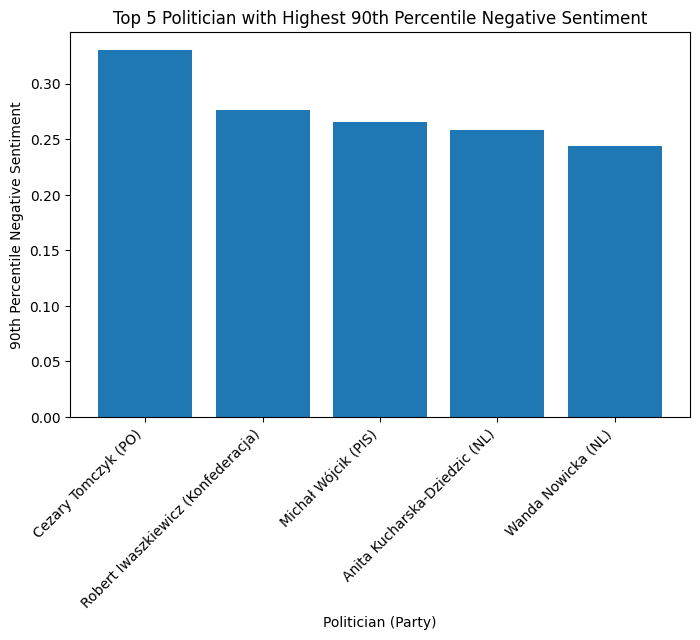

In [17]:
percentile_90_neg = df_no_na.groupby('username')['neg_vader'].quantile(0.90).reset_index()

top5_neg_sentiment = percentile_90_neg.sort_values(by='neg_vader', ascending=False).head(5)
top5_neg_sentiment = top5_neg_sentiment.merge(df[['username', 'name', 'party']].drop_duplicates(), on='username', how='left')

plt.figure(figsize=(8, 5))
top5_neg_sentiment['name_with_party'] = top5_neg_sentiment['name'].apply(
    lambda name: f"{name} ({df[df['name'] == name]['party'].iloc[0]})"
)
bars = plt.bar(top5_neg_sentiment['name_with_party'], top5_neg_sentiment["neg_vader"])
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.title('Top 5 Politician with Highest 90th Percentile Negative Sentiment')
plt.xlabel('Politician (Party)')
plt.ylabel('90th Percentile Negative Sentiment')
plt.show()

According to the VADER analysis, the top 5 politicians with the highest 90th percentile of negative sentiment in their tweets represent almost all parties except PL2050, with two individuals from Nowa Lewica included.

### 3.2. Top 5 most positive politicians

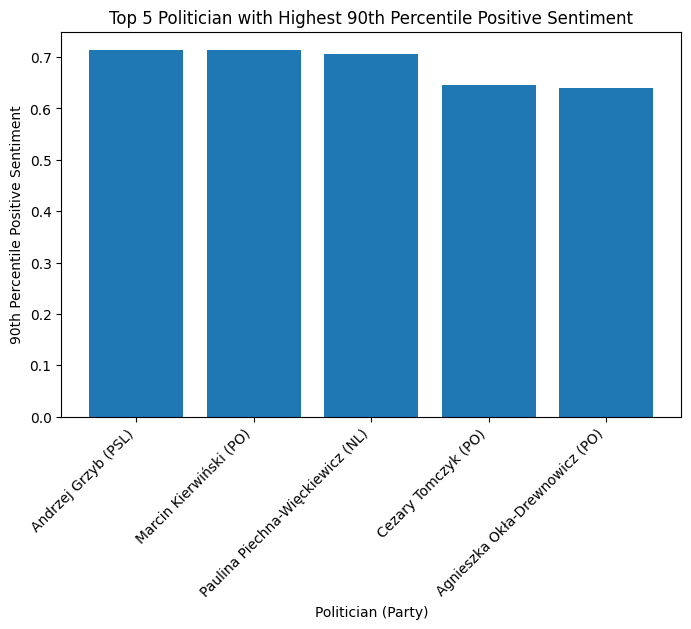

In [18]:
percentile_90_pos = df_no_na.groupby('username')['pos_vader'].quantile(0.90).reset_index()

top5_pos_sentiment = percentile_90_pos.sort_values(by='pos_vader', ascending=False).head(5)
top5_pos_sentiment = top5_pos_sentiment.merge(df[['username', 'name', 'party']].drop_duplicates(), on='username', how='left')

plt.figure(figsize=(8, 5))
top5_pos_sentiment['name_with_party'] = top5_pos_sentiment['name'].apply(
    lambda name: f"{name} ({df[df['name'] == name]['party'].iloc[0]})"
)
bars = plt.bar(top5_pos_sentiment['name_with_party'], top5_pos_sentiment["pos_vader"])
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.title('Top 5 Politician with Highest 90th Percentile Positive Sentiment')
plt.xlabel('Politician (Party)')
plt.ylabel('90th Percentile Positive Sentiment')
plt.show()

According to the VADER analysis, the top 5 politicians with the highest 90th percentile of positive sentiment in their tweets include 3 individuals from PO, 1 from PSL, and 1 from NL.

### 3.3. Negative Sentiment on party level

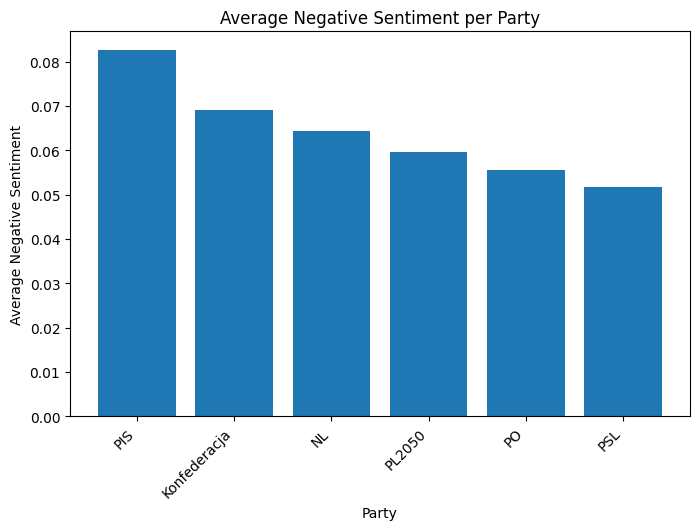

In [19]:
average_neg_sentiment_party = df_no_na.groupby('party')['neg_vader'].mean().reset_index()

top5_avg_neg_sentiment_party = average_neg_sentiment_party.sort_values(by='neg_vader', ascending=False)

plt.figure(figsize=(8, 5))
bars = plt.bar(top5_avg_neg_sentiment_party['party'], top5_avg_neg_sentiment_party["neg_vader"])
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.title('Average Negative Sentiment per Party')
plt.xlabel('Party')
plt.ylabel('Average Negative Sentiment')
plt.show()


We can observe that the plot shows the highest average negative sentiment for PIS, followed closely by Konfederacja. The lowest average negative sentiment is observed for PO and PSL.

### 3.4. Positive Sentiment on party level

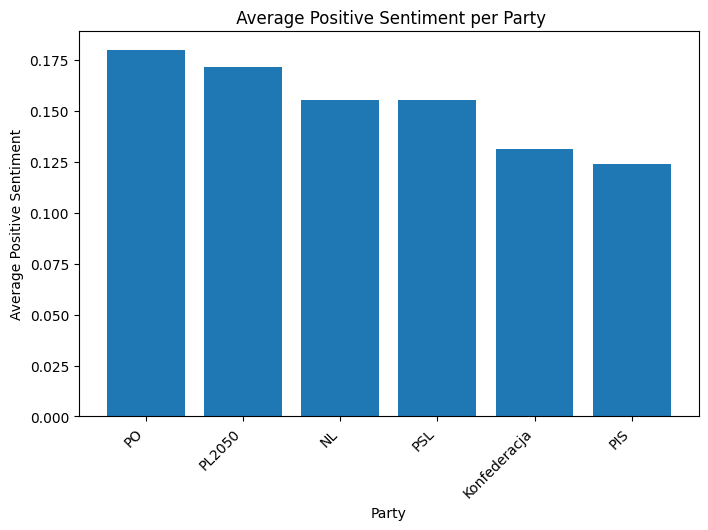

In [20]:
average_pos_sentiment_party = df_no_na.groupby('party')['pos_vader'].mean().reset_index()

top5_avg_pos_sentiment_party = average_pos_sentiment_party.sort_values(by='pos_vader', ascending=False)

plt.figure(figsize=(8, 5))
bars = plt.bar(top5_avg_pos_sentiment_party['party'], top5_avg_pos_sentiment_party["pos_vader"])
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.title(' Average Positive Sentiment per Party')
plt.xlabel('Party')
plt.ylabel('Average Positive Sentiment')
plt.show()


We can observe that the plot is a rotated version of the previous plot. The highest average positive sentiment is for PO, PL2050, NL, and PSL, while Konfederacja, and PIS have lower scores.

### 3.5. Most Negative Tweets 

In [21]:
top_5_negative_tweets = df_no_na.nlargest(10, 'neg_vader')[['name', 'party', 'text_clean_en', 'neg_vader']]
print("Top 5 Most Negative Tweets:")
print(top_5_negative_tweets)

Top 5 Most Negative Tweets:
                    name         party text_clean_en  neg_vader
2220    Konrad Berkowicz  Konfederacja    Criminals.        1.0
4317        Michał Wawer  Konfederacja            NO        1.0
4487        Michał Wawer  Konfederacja            NO        1.0
5087    Grzegorz Płaczek  Konfederacja     Disgrace!        1.0
5214    Grzegorz Płaczek  Konfederacja          - NO        1.0
7150   Witold Tumanowicz  Konfederacja           NO.        1.0
7155   Witold Tumanowicz  Konfederacja           NO.        1.0
9179    Marek Sypniewski  Konfederacja            NO        1.0
10551   Sławomir Mentzen  Konfederacja           NO.        1.0
10851    Krzysztof Tuduj  Konfederacja          Sad.        1.0


In [22]:
pd.set_option('display.max_colwidth', None)
df_no_na['word_count'] = df_no_na['text_clean_en'].apply(lambda x: len(str(x).split()))
df_no_na = df_no_na[df_no_na['word_count'] >= 3]
top_negative_posts = df_no_na.nlargest(10, 'neg_vader')[['name', 'party', 'text_clean_en', 'neg_vader']]
print("Top 5 Most Negative Tweets (longer than 2 words):")
print(top_negative_posts)

Top 5 Most Negative Tweets (longer than 2 words):
                             name         party                 text_clean_en  \
43414                  Paweł Śliz        PL2050      Terribly weak. Terrible.   
13707              Marcin Kulasek            NL             No more war!  🇵 🇱   
31305            Dorota Niedziela            PO    Shamelessness and villainy   
41882       Paulina Hennig-Kloska        PL2050         Sad and embarrassing.   
1841             Konrad Berkowicz  Konfederacja          PiS, PO - one evil!    
11148          Włodzimierz Skalik  Konfederacja          PiS, PO - one evil.    
40452                  Paweł Śliz        PL2050          Sarcasm was sarcasm.   
18069               Wanda Nowicka            NL              What a bastard!    
22640  Małgorzata Moskwa-Wodnicka            NL                 Quite a bomb!   
35714            Dorota Niedziela            PO  Liars, liars, liars... #PIS    

       neg_vader  
43414      1.000  
13707      0.870  
3

We can observe that VADER was able to capture negative tweets. However, they were not as negative as expected. Without filtering the shortest tweets, the most negative tweets were simply "NO." After filtering to consider tweets longer than two words, the tweets were still not very negative or offensive.

### 3.6. Most Positive Tweets 

In [23]:
top_5_positive_tweets = df_no_na.nlargest(10, 'pos_vader')[['name', 'party', 'text_clean_en', 'pos_vader']]
print("Top 5 Most Positive Tweets:")
print(top_5_positive_tweets)

Top 5 Most Positive Tweets:
                              name         party                text_clean_en  \
3892              Marek Sypniewski  Konfederacja                  Good luck !   
5922              Sławomir Mentzen  Konfederacja  Congratulations! Good luck!   
13553            Krzysztof Śmiszek            NL       Great! Welcome aboard!   
19908            Beata Maciejewska            NL                  I invite :)   
20817            Krzysztof Śmiszek            NL   Welcome aboard! Good luck!   
21189            Krzysztof Śmiszek            NL         Well, cool, cool :-)   
22747   Małgorzata Moskwa-Wodnicka            NL         Happy!!! 🇵 🇱 🇵 🇱 🇵 🇱   
22951  Paulina Piechna-Więckiewicz            NL                   I invite !   
41580                 Maciej Żywno        PL2050                good, good :)   
44423                 Maciej Żywno        PL2050              I invite :)       

       pos_vader  
3892         1.0  
5922         1.0  
13553        1.0  
1990

In [24]:
pd.set_option('display.max_colwidth', None)
df_no_na = df_no_na[df_no_na['word_count'] >= 10]
top_positive_posts = df_no_na.nlargest(10, 'pos_vader')[['name', 'party', 'text_clean_en', 'pos_vader']]
print("Top 5 Most Positive Tweets (longer than 9 words):")
print(top_positive_posts)

Top 5 Most Positive Tweets (longer than 9 words):
                            name         party  \
31354           Dorota Niedziela            PO   
48269           Stefan Krajewski           PSL   
18357      Włodzimierz Czarzasty            NL   
5535            Sławomir Mentzen  Konfederacja   
3484            Marek Sypniewski  Konfederacja   
31271           Dorota Niedziela            PO   
37692  Małgorzata Kidawa-Błońska            PO   
272              Bartłomiej Pejo  Konfederacja   
19195   Anita Kucharska-Dziedzic            NL   
41496               Maciej Żywno        PL2050   

                                                                                                           text_clean_en  \
31354                                                         Celebrating 🇵 🇱 🇵 🇱 🇵 🇱 🇵 🇱 #DzieńaflagiRP 🇵 🇱 🇵 🇱 🇵 🇱 🇵 🇱   
48269                                                                    Dear Ladies, please accept my best wishes 🌹 🌹 🌹   
18357             #EuropeFo

VADER effectively captured positive tweets. Unlike negative tweets, unfiltered positive tweets are meaningful and often congratulatory. Tweets longer than 9 words are also related to celebrations, congratulations, and positive events.

### 3.7. Wordclouds

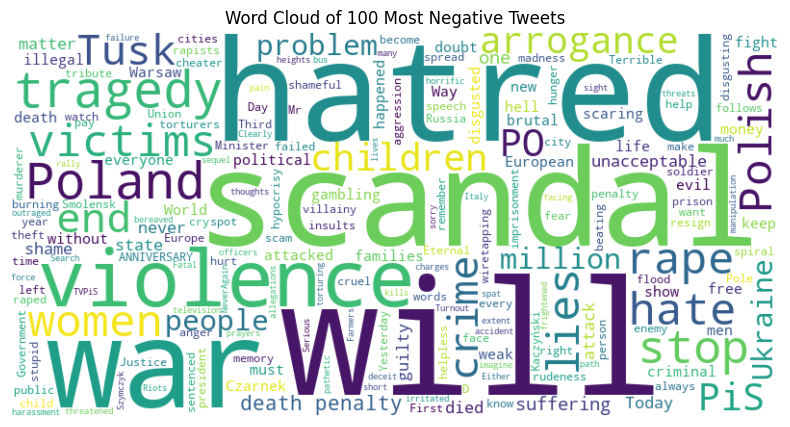

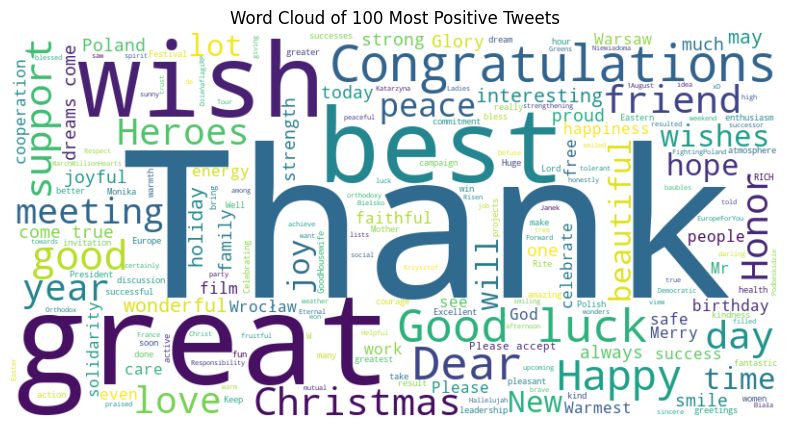

In [25]:
top_negative_posts = df_no_na.nlargest(100, 'neg_vader')[['name', 'party', 'text_clean_en', 'neg_vader']]
negative_texts = ' '.join(top_negative_posts['text_clean_en'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_texts)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of 100 Most Negative Tweets')
plt.show()

top_positive_posts = df_no_na.nlargest(100, 'pos_vader')[['name', 'party', 'text_clean_en', 'pos_vader']]
negative_texts = ' '.join(top_positive_posts['text_clean_en'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_texts)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of 100 Most Positive Tweets')
plt.show()

## 3. Supervised approach Sentiment Analysis (BERT)

In [26]:
# Load data and preprocess for HerBERT sentiment
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
from tqdm import tqdm

In [28]:
df = pd.read_parquet('../data/03.cleaned/df_combined.parquet')

def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

df_for_bert = df.copy()
df_for_bert['text_bert'] = df_for_bert['text_clean_demojized'].apply(preprocess)  # <- change YOUR_TEXT_COLUMN
# df_for_bert['text_bert_2'] = df_for_bert['text_clean'].apply(preprocess)  # <- second option

In [29]:
# 4.6 HerBERT sentiment with batching + checkpoints
import os

MODEL = "Voicelab/herbert-base-cased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BATCH_SIZE = 100
CHECKPOINT_PATH = '../data/03.cleaned/sentiment/sentiment_checkpoint.parquet'

# Create subfolder if not exists
os.makedirs('../data/03.cleaned/sentiment', exist_ok=True)

# Resume from checkpoint if exists
if os.path.exists(CHECKPOINT_PATH):
    df_for_bert = pd.read_parquet(CHECKPOINT_PATH)
    start_idx = df_for_bert['negative_herbert'].notna().sum()
    print(f"Resuming from index {start_idx}")
else:
    # df_for_bert['negative_herbert'] = None
    # df_for_bert['neutral_herbert'] = None
    # df_for_bert['positive_herbert'] = None
    df_for_bert['negative_herbert'] = np.nan
    df_for_bert['neutral_herbert'] = np.nan
    df_for_bert['positive_herbert'] = np.nan
    start_idx = 0

def herbert_predict(text):
    encoded = tokenizer(text, return_tensors='pt', truncation=True, max_length=512).to(device)
    with torch.no_grad():
        output = model(**encoded)
    scores = softmax(output.logits[0].cpu().numpy())
    return scores

# Process in batches with saves
for i in tqdm(range(start_idx, len(df_for_bert), BATCH_SIZE)):
    batch = df_for_bert.iloc[i:i+BATCH_SIZE]
    
    for j, row in batch.iterrows():
        scores = herbert_predict(row['text_bert'])
        df_for_bert.at[j, 'negative_herbert'] = float(scores[0])
        df_for_bert.at[j, 'neutral_herbert'] = float(scores[1])
        df_for_bert.at[j, 'positive_herbert'] = float(scores[2])
    
    # Save checkpoint every batch
    df_for_bert.to_parquet(CHECKPOINT_PATH, index=False)
    
print("Done!")

100%|██████████| 484/484 [54:58<00:00,  6.82s/it]

Done!


In [30]:
# 4.7 PaReS political Twitter sentiment (fine-tuned on 1k Polish political tweets)
# Base: dkleczek/bert-base-polish-cased-v1

MODEL_POL = "eevvgg/PaReS-sentimenTw-political-PL"
tokenizer_pol = AutoTokenizer.from_pretrained(MODEL_POL)
model_pol = AutoModelForSequenceClassification.from_pretrained(MODEL_POL)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_pol.to(device)

BATCH_SIZE = 100
CHECKPOINT_PATH_PARES = '../data/03.cleaned/sentiment/sentiment_checkpoint_pares.parquet'

os.makedirs('../data/03.cleaned/sentiment', exist_ok=True)

# Resume from checkpoint if exists
if os.path.exists(CHECKPOINT_PATH_PARES):
    df_for_bert = pd.read_parquet(CHECKPOINT_PATH_PARES)
    start_idx = df_for_bert['negative_pares'].notna().sum()
    print(f"Resuming from index {start_idx}")
else:
    df_for_bert['negative_pares'] = np.nan
    df_for_bert['neutral_pares'] = np.nan
    df_for_bert['positive_pares'] = np.nan
    start_idx = 0

def pares_predict(text):
    encoded = tokenizer_pol(text, return_tensors='pt', truncation=True, max_length=512).to(device)
    with torch.no_grad():
        output = model_pol(**encoded)
    scores = softmax(output.logits[0].cpu().numpy())
    return scores

# Process in batches with saves
for i in tqdm(range(start_idx, len(df_for_bert), BATCH_SIZE)):
    batch = df_for_bert.iloc[i:i+BATCH_SIZE]
    
    for j, row in batch.iterrows():
        scores = pares_predict(row['text_bert'])
        df_for_bert.at[j, 'negative_pares'] = float(scores[0])
        df_for_bert.at[j, 'neutral_pares'] = float(scores[1])
        df_for_bert.at[j, 'positive_pares'] = float(scores[2])
    
    # Save checkpoint every batch
    df_for_bert.to_parquet(CHECKPOINT_PATH_PARES, index=False)
    
print("Done!")

100%|██████████| 484/484 [48:35<00:00,  6.02s/it]

Done!


In [31]:
df_for_bert.to_parquet('../data/03.cleaned/df_herbert_values_GIT.parquet', index=False)

## 4. QUICK FIX - HERBERT MODEL

In [32]:
# QUICK FIX SCRIPT TO RENAME HERBERT COLUMNS TO BERT COLUMNS AND SAVE AS NEW FILE FOR FURTHER SECTIONS

import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np

# --- Configuration ---
# 1. Input file path: Reflects the original name created by the HerBERT processing
INPUT_FILE_GIT_HERBERT = '../data/03.cleaned/df_herbert_values_GIT.parquet' 

# 2. Output file path: The desired standard name for your downstream analysis
OUTPUT_FILE = '../data/03.cleaned/df_bert_values_GIT.parquet' 

# Define the mapping from 'herbert' suffix to 'bert' suffix
rename_mapping = {
    'negative_herbert': 'negative_bert',
    'neutral_herbert': 'neutral_bert',
    'positive_herbert': 'positive_bert'
}
sentiment_cols = ['negative_bert', 'neutral_bert', 'positive_bert']

# 1. Load the DataFrame using the new input variable name
try:
    df_for_bert = pd.read_parquet(INPUT_FILE_GIT_HERBERT)
    print(f"Successfully loaded DataFrame from {INPUT_FILE_GIT_HERBERT}.")
except FileNotFoundError:
    print(f"ERROR: Input file not found at {INPUT_FILE_GIT_HERBERT}. Please check the path.")
    raise FileNotFoundError(f"Input file not found: {INPUT_FILE_GIT_HERBERT}")

# 2. Apply the renaming (herbert -> bert)
df_for_bert.rename(columns=rename_mapping, inplace=True)
print("Renamed '_herbert' columns to '_bert'.")

# 3. Convert sentiment columns to float (to fix the TypeError for quantile())
for col in sentiment_cols:
    if col in df_for_bert.columns:
        # 'coerce' handles any non-numeric strings by turning them into NaN
        df_for_bert[col] = pd.to_numeric(df_for_bert[col], errors='coerce')
        # Drop NA values after conversion
        df_for_bert.dropna(subset=[col], inplace=True) 
        print(f"Converted column '{col}' to float.")
    else:
        # This will warn if the herbert columns were already renamed in a previous run
        print(f"Warning: Renamed column '{col}' not found in DataFrame.")

# 4. Save the processed DataFrame to the specified NEW output file
# This creates the new file 'df_bert_values.parquet' without affecting the input file.
df_for_bert.to_parquet(OUTPUT_FILE, index=False)
print(f"\nSaved CLEANED DataFrame to NEW file: {OUTPUT_FILE}.")

Successfully loaded DataFrame from ../data/03.cleaned/df_herbert_values_GIT.parquet.
Renamed '_herbert' columns to '_bert'.
Converted column 'negative_bert' to float.
Converted column 'neutral_bert' to float.
Converted column 'positive_bert' to float.

Saved CLEANED DataFrame to NEW file: ../data/03.cleaned/df_bert_values_GIT.parquet.


In [33]:
df_for_bert

in_reply_to_user_id reply_settings     author_id  \
0              375146901.0       everyone  1.182212e+09   
1                      NaN       everyone  1.182212e+09   
2                      NaN       everyone  1.182212e+09   
3                      NaN       everyone  1.182212e+09   
4                      NaN       everyone  1.182212e+09   
...                    ...            ...           ...   
48326                  NaN       everyone  9.611819e+08   
48327                  NaN       everyone  9.611819e+08   
48328                  NaN       everyone  9.611819e+08   
48329                  NaN       everyone  9.611819e+08   
48330                  NaN       everyone  9.611819e+08   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            context_annotations  \
0      [{'domain': {'description': 'Named people in the world like Nelson Mandela', 'id': '10', 'name': 'Person'}, 'entity': {'description': 'Donald Tusk', 'id': '847091557232664576', 'name': 'Donald Tusk'}}, {'domain': {'description': 'Politicians in the world, like Joe Biden', 'id': '35', 'name': 'Politician'}, 'entity': {'description': 'Donald Tusk', 'id': '847091557232664576', 'name': 'Donald Tusk'}}, {'domain': {'description': 'A taxonomy of user interests. ', 'id': '131', 'name': 'Unified Twitter Taxonomy'}, 'entity': {'description': 'Donald Tusk', 'id': '847091557232664576', 'name': 'Donald Tusk'}}, {'domain': {'description': 'A taxonomy of user interests. ', 'id': '131', 'name': 'Unified Twitter Taxonomy'}, 'entity': {'description': 'Politics', 'id': '847878884917886977', 'name': 'Politics'}}, {'domain': {'description': 'A taxonomy of user interests. ', 'id': '131', 'name': 'Unified Twitter Taxonomy'}, 'entity': {'description': 'Politician', 'id': '1070032753834438656', 'name': 'Political figures'}}]   
1      [{'domain': {'description': 'Named people in the world like Nelson Mandela', 'id': '10', 'name': 'Person'}, 'entity': {'description': 'Donald Tusk', 'id': '847091557232664576', 'name': 'Donald Tusk'}}, {'domain': {'description': 'Politicians in the world, like Joe Biden', 'id': '35', 'name': 'Politician'}, 'entity': {'description': 'Donald Tusk', 'id': '847091557232664576', 'name': 'Donald Tusk'}}, {'domain': {'description': 'A taxonomy of user interests. ', 'id': '131', 'name': 'Unified Twitter Taxonomy'}, 'entity': {'description': 'Donald Tusk', 'id': '847091557232664576', 'name': 'Donald Tusk'}}, {'domain': {'description': 'A taxonomy of user interests. ', 'id': '131', 'name': 'Unified Twitter Taxonomy'}, 'entity': {'description': 'Politics', 'id': '847878884917886977', 'name': 'Politics'}}, {'domain': {'description': 'A taxonomy of user interests. ', 'id': '131', 'name': 'Unified Twitter Taxonomy'}, 'entity': {'description': 'Politician', 'id': '1070032753834438656', 'name': 'Political figures'}}]   
2                                                                                                                                                                                                                        

In [34]:
df_for_bert.columns

Index(['in_reply_to_user_id', 'reply_settings', 'author_id',
       'context_annotations', 'id', 'text', 'edit_controls',
       'referenced_tweets', 'created_at', 'edit_history_tweet_ids', 'lang',
       'conversation_id', 'possibly_sensitive', 'category', 'attachments',
       'geo', 'username', 'party', 'text_clean', 'mentions', 'links',
       'hashtags', 'retweet_count', 'reply_count', 'like_count', 'quote_count',
       'impression_count', 'text_clean_en', 'text_clean_en_demojized',
       'text_clean_demojized', 'emoji_count_en', 'emoji_count', 'name',
       'text_bert', 'negative_bert', 'neutral_bert', 'positive_bert',
       'negative_pares', 'neutral_pares', 'positive_pares'],
      dtype='object')

MODEL COMPARISON: HerBERT vs PaReS

📊 DISTRIBUTION COMPARISON:

HerBERT: mean=0.288, std=0.696
PaReS:   mean=-0.182, std=0.804

🔗 CORRELATION: 0.608

🔴 HerBERT much more POSITIVE than PaReS:

PL2050 | HerBERT: 1.00 | PaReS: -1.00
      Pudło. O ile po mieście, z racji pracy musze mieć samochód to w podróżach dalszych uwielbiam transport koleją (no chyba że opóżnienie jest 240min i może ulec zmianie ;)...

PO | HerBERT: 1.00 | PaReS: -1.00
 Nic nie stoi. Wszystko idzie pełną parą. Wszystko co najważniejsze zostało już ustawione na właściwych miejscach....

NL | HerBERT: 1.00 | PaReS: -1.00
Warto było czekać - piękny dzień. Koniec TVPiS i szczucia na ludzi! ...

NL | HerBERT: 1.00 | PaReS: -1.00
Polki i Polacy mówią dość łamaniu praworządności, wojenkom z UE i okradaniu Polski. I dlatego chcą, aby po wyborach rząd stworzyła dzisiejsza opozycja.

Jako  mamy mocne 10 proc. Partia sympatyków Put...

PL2050 | HerBERT: 1.00 | PaReS: -1.00
Mistrzowski awans, szkoda, że nie jest to świat showbi

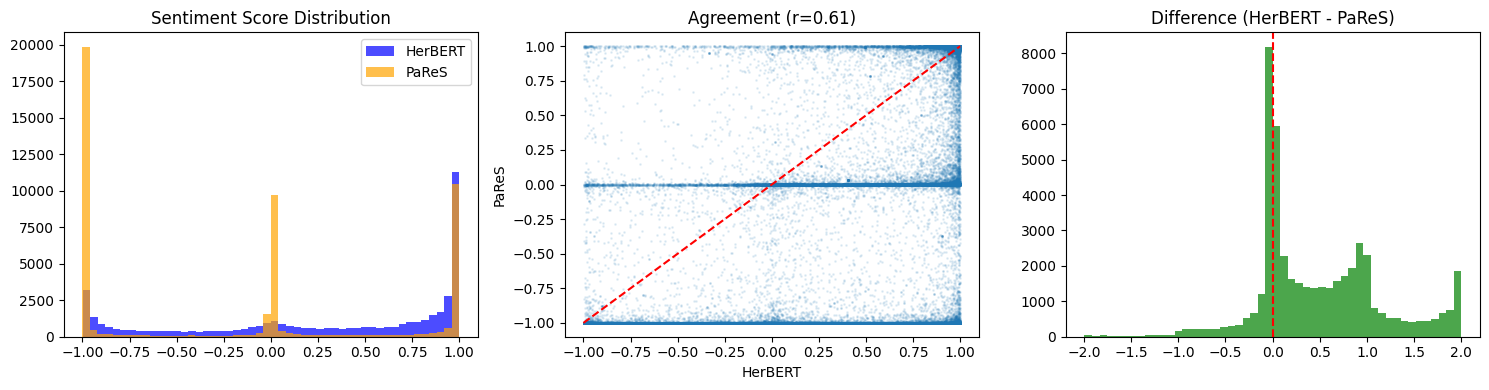


📊 CATEGORY AGREEMENT: 44.2%

📊 CONFUSION MATRIX:
score_pares    Very Negative  Negative  Neutral  Positive  Very Positive  \
score_herbert                                                              
Very Negative           7753        86      529        35            207   
Negative                2929        77      556        42            168   
Neutral                 4097       168     2520       100            400   
Positive                2138       105     2956       155            717   
Very Positive           4329       288     6362       750          10864   
All                    21246       724    12923      1082          12356   

score_pares      All  
score_herbert         
Very Negative   8610  
Negative        3772  
Neutral         7285  
Positive        6071  
Very Positive  22593  
All            48331  


In [36]:
# Create separate df for model comparison analysis
df_compare = pd.DataFrame({
    'party': df_for_bert['party'],
    'text_clean': df_for_bert['text_clean'],
    'score_herbert': df_for_bert['positive_bert'] - df_for_bert['negative_bert'],
    'score_pares': df_for_bert['positive_pares'] - df_for_bert['negative_pares']
})
df_compare['score_diff'] = df_compare['score_herbert'] - df_compare['score_pares']

print("="*80)
print("MODEL COMPARISON: HerBERT vs PaReS")
print("="*80)

# 1. Basic stats
print("\n📊 DISTRIBUTION COMPARISON:")
print(f"\nHerBERT: mean={df_compare['score_herbert'].mean():.3f}, std={df_compare['score_herbert'].std():.3f}")
print(f"PaReS:   mean={df_compare['score_pares'].mean():.3f}, std={df_compare['score_pares'].std():.3f}")

# 2. Correlation
corr = df_compare['score_herbert'].corr(df_compare['score_pares'])
print(f"\n🔗 CORRELATION: {corr:.3f}")

# 3. Biggest disagreements
print("\n" + "="*80)
print("🔴 HerBERT much more POSITIVE than PaReS:")
print("="*80)
for _, row in df_compare.nlargest(5, 'score_diff').iterrows():
    print(f"\n{row['party']} | HerBERT: {row['score_herbert']:.2f} | PaReS: {row['score_pares']:.2f}")
    print(f"{row['text_clean'][:200]}...")

print("\n" + "="*80)
print("🔵 PaReS much more POSITIVE than HerBERT:")
print("="*80)
for _, row in df_compare.nsmallest(5, 'score_diff').iterrows():
    print(f"\n{row['party']} | HerBERT: {row['score_herbert']:.2f} | PaReS: {row['score_pares']:.2f}")
    print(f"{row['text_clean'][:200]}...")

# 4. Plots
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(df_compare['score_herbert'], bins=50, alpha=0.7, label='HerBERT', color='blue')
axes[0].hist(df_compare['score_pares'], bins=50, alpha=0.7, label='PaReS', color='orange')
axes[0].set_title('Sentiment Score Distribution')
axes[0].legend()

axes[1].scatter(df_compare['score_herbert'], df_compare['score_pares'], alpha=0.1, s=1)
axes[1].plot([-1, 1], [-1, 1], 'r--')
axes[1].set_xlabel('HerBERT')
axes[1].set_ylabel('PaReS')
axes[1].set_title(f'Agreement (r={corr:.2f})')

axes[2].hist(df_compare['score_diff'], bins=50, color='green', alpha=0.7)
axes[2].axvline(0, color='red', linestyle='--')
axes[2].set_title('Difference (HerBERT - PaReS)')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'model_comparison_herbert_vs_pares.png'), dpi=300, bbox_inches='tight')
plt.show()

# 5. Category agreement
bins = [-1.01, -0.6, -0.2, 0.2, 0.6, 1.01]
labels_cat = ['Very Negative', 'Negative', 'Neutral', 'Positive', 'Very Positive']

cat_herbert = pd.cut(df_compare['score_herbert'], bins=bins, labels=labels_cat)
cat_pares = pd.cut(df_compare['score_pares'], bins=bins, labels=labels_cat)

print(f"\n📊 CATEGORY AGREEMENT: {(cat_herbert == cat_pares).mean():.1%}")
print("\n📊 CONFUSION MATRIX:")
print(pd.crosstab(cat_herbert, cat_pares, margins=True))

In [35]:
import os
output_dir = '../sentiment_OutputVisualizations'
os.makedirs(output_dir, exist_ok=True)

### 4.1. Top 5 most negative politicians

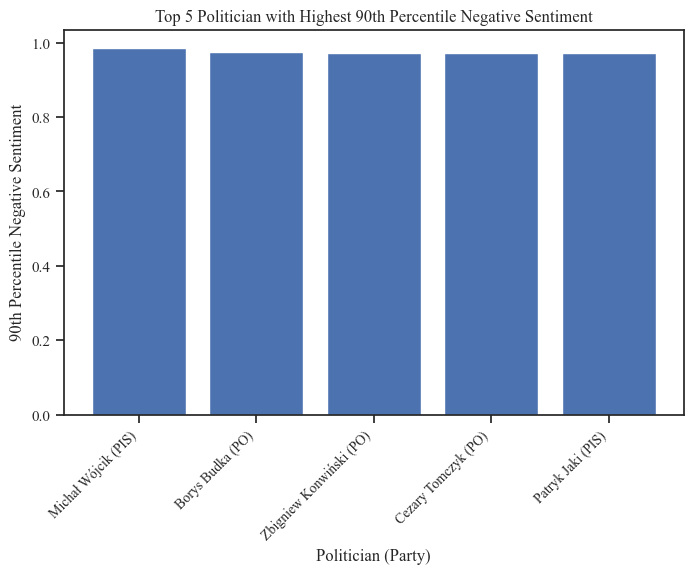

In [91]:
percentile_90_neg = df_for_bert.groupby('username')['negative_bert'].quantile(0.90).reset_index()

top5_neg_sentiment = percentile_90_neg.sort_values(by='negative_bert', ascending=False).head(5)
top5_neg_sentiment = top5_neg_sentiment.merge(df[['username', 'name', 'party']].drop_duplicates(), on='username', how='left')

plt.figure(figsize=(8, 5))
top5_neg_sentiment['name_with_party'] = top5_neg_sentiment['name'].apply(
    lambda name: f"{name} ({df[df['name'] == name]['party'].iloc[0]})"
)
bars = plt.bar(top5_neg_sentiment['name_with_party'], top5_neg_sentiment["negative_bert"])
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.title('Top 5 Politician with Highest 90th Percentile Negative Sentiment')
plt.xlabel('Politician (Party)')
plt.ylabel('90th Percentile Negative Sentiment')
plt.show()

We can observe that the 90th percentile Negative Sentiment scores are quite comparable among the top 5 politicians. In comparison to VADER three politicians remain the same, while two have changed. This indicates a difference in predictions made by the VADER and BERT models.

### 4.2. Top 5 most positive politicians

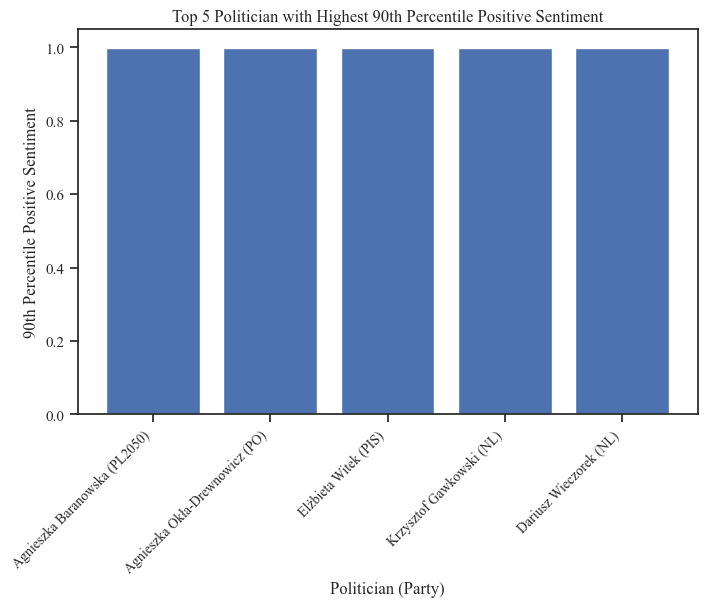

In [92]:
percentile_90_pos = df_for_bert.groupby('username')['positive_bert'].quantile(0.90).reset_index()

top5_pos_sentiment = percentile_90_pos.sort_values(by='positive_bert', ascending=False).head(5)
top5_pos_sentiment = top5_pos_sentiment.merge(df[['username', 'name', 'party']].drop_duplicates(), on='username', how='left')

plt.figure(figsize=(8, 5))
top5_pos_sentiment['name_with_party'] = top5_pos_sentiment['name'].apply(
    lambda name: f"{name} ({df[df['name'] == name]['party'].iloc[0]})"
)
bars = plt.bar(top5_pos_sentiment['name_with_party'], top5_pos_sentiment["positive_bert"])
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.title('Top 5 Politician with Highest 90th Percentile Positive Sentiment')
plt.xlabel('Politician (Party)')
plt.ylabel('90th Percentile Positive Sentiment')
plt.show()

We can observe that the 90th percentile Positive Sentiment scores are quite comparable among the top 5 politicians. Compared to the VADER method, there are significant changes; only one politician stays the same.

### 4.3. Negative Sentiment on party level

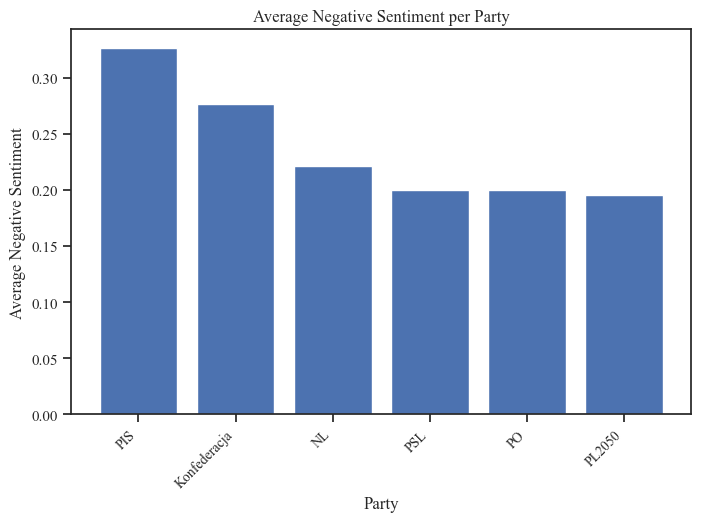

In [93]:
average_neg_sentiment_party = df_for_bert.groupby('party')['negative_bert'].mean().reset_index()

top5_avg_neg_sentiment_party = average_neg_sentiment_party.sort_values(by='negative_bert', ascending=False)

plt.figure(figsize=(8, 5))
bars = plt.bar(top5_avg_neg_sentiment_party['party'], top5_avg_neg_sentiment_party["negative_bert"])
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.title('Average Negative Sentiment per Party')
plt.xlabel('Party')
plt.ylabel('Average Negative Sentiment')
plt.show()


We can observe that the party ranking is the same to this one obtained using the VADER method.

### 4.4. Positive Sentiment on party level

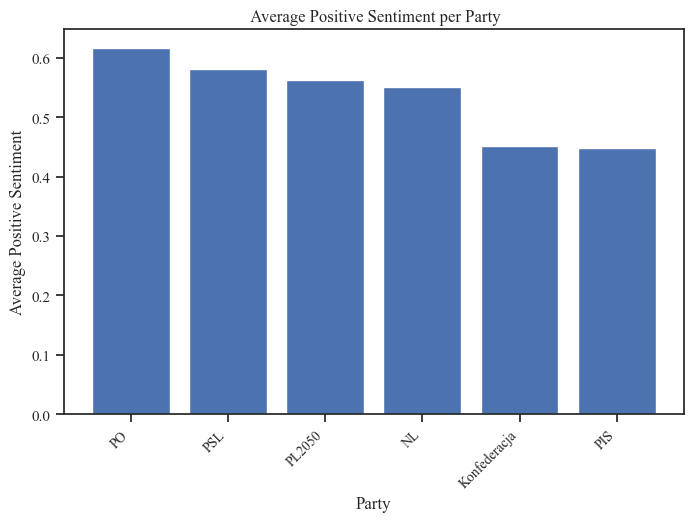

In [94]:
average_pos_sentiment_party = df_for_bert.groupby('party')['positive_bert'].mean().reset_index()

top5_avg_pos_sentiment_party = average_pos_sentiment_party.sort_values(by='positive_bert', ascending=False)

plt.figure(figsize=(8, 5))
bars = plt.bar(top5_avg_pos_sentiment_party['party'], top5_avg_pos_sentiment_party["positive_bert"])
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.title(' Average Positive Sentiment per Party')
plt.xlabel('Party')
plt.ylabel('Average Positive Sentiment')
plt.show()


In comparison to VADER, the first two positions remain unchanged, while the parties ranked third and fourth, as well as fifth and sixth, switch places.

### 4.5. Most Negative Tweets 

In [95]:
top_5_negative_tweets = df_for_bert.nlargest(10, 'negative_bert')[['name', 'party', 'text_clean', 'negative_bert']]
print("Top 5 Most Negative Tweets:")
print(top_5_negative_tweets)

Top 5 Most Negative Tweets:
                           name         party  \
16087              Tomasz Trela            NL   
43437                Paweł Śliz        PL2050   
5125           Grzegorz Płaczek  Konfederacja   
43240                Paweł Śliz        PL2050   
12663  Joanna Scheuring-Wielgus            NL   
46779              Adam Jarubas           PSL   
21171         Krzysztof Śmiszek            NL   
11199        Włodzimierz Skalik  Konfederacja   
35524          Dorota Niedziela            PO   
19214  Anita Kucharska-Dziedzic            NL   

                                              text_clean  negative_bert  
16087    Oj Mateuszku kłamczuszku, nic nie zrobiłeś p...       0.998083  
43437   No brawo!!! Jeden strzał i dwa razy pudło  😂  🤣        0.997968  
5125    ❌  Panie i Panowie ze sportowych redakcji i k...       0.997677  
43240  Zmasowana akcja . Przykryc kradzież Polaków 10...       0.997651  
12663  brak dosłownie słów na zachowanie  kretynizm d...      

The RoBERTa model is able to identify more sophisticated negative tweets. Unlike VADER, which often predicts that the most negative tweets are single negative words, RoBERTa captures the nuanced meaning of the tweets. There is no need to filter out short tweets with only one word (e.g., "NO") as was necessary with VADER. These tweets are mostly critical of the actions of other parties, with the majority coming from NL but also from PO, Konfederacja, PiS and PSL.

CHANGING ROBERTA MODEL TO HERBERT - POLISH MODEL

### 4.6. Most Positive Tweets 

In [24]:
top_5_positive_tweets = df_for_bert.nlargest(10, 'positive_bert')[['name', 'party', 'text_clean', 'positive_bert']]
print("Top 5 Most Positive Tweets:")
print(top_5_positive_tweets)

Top 5 Most Positive Tweets:
                            name   party  \
45183               Adam Jarubas     PSL   
45182               Adam Jarubas     PSL   
20996          Krzysztof Śmiszek      NL   
46752               Adam Jarubas     PSL   
43995             Paweł Zalewski  PL2050   
38287  Agnieszka Okła-Drewnowicz      PO   
25815         Mateusz Morawiecki     PIS   
41973      Paulina Hennig-Kloska  PL2050   
44421               Maciej Żywno  PL2050   
43204                 Paweł Śliz  PL2050   

                                              text_clean  positive_bert  
45183   Dla mnie mocna „4”. Trzyma uwagę przez całe 5...       0.999395  
45182                        Świetna książka. Polecam:-)       0.999379  
20996                             Dobry serial! Polecam!       0.999370  
46752                       Świetna książka. Szacunek:-)       0.999345  
43995                       Doskonały tekst. Polecam 👍         0.999337  
38287                                      

The most positive tweets from the RoBERTa model are more meaningful than those from the VADER method. They are notably longer and often reflect the authors' happiness following certain events, such as meetings with voters or positive election results.

### 4.7. Word clouds

In [27]:
from wordcloud import WordCloud

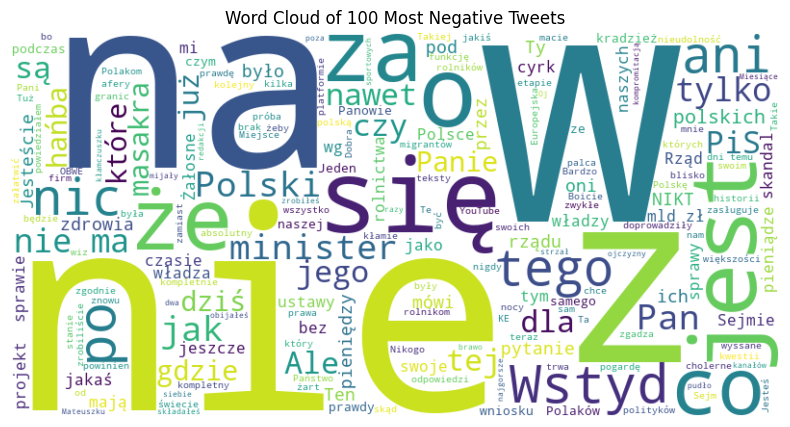

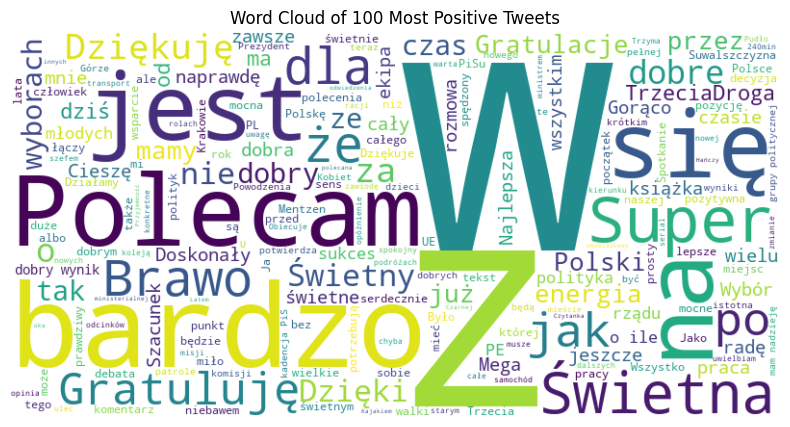

In [28]:
top_negative_posts = df_for_bert.nlargest(100, 'negative_bert')[['name', 'party', 'text_clean', 'negative_bert']]
negative_texts = ' '.join(top_negative_posts['text_clean'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_texts)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of 100 Most Negative Tweets')
plt.show()

top_positive_posts = df_for_bert.nlargest(100, 'positive_bert')[['name', 'party', 'text_clean', 'positive_bert']]
negative_texts = ' '.join(top_positive_posts['text_clean'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_texts)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of 100 Most Positive Tweets')
plt.show()

### 4.8. Sentiment Analysis over time

In [37]:
file_path = '../data/03.cleaned/df_bert_values_GIT.parquet'

# Read the Parquet file into a DataFrame
df_from_parquet = pd.read_parquet(file_path)

# Display the first few rows to verify it loaded correctly
display(df_from_parquet.head())

df_for_bert = df_from_parquet.copy()

# unique_usernames_count = df_for_bert['username'].nunique()
# print(f"Number of unique usernames: {unique_usernames_count}")

in_reply_to_user_id reply_settings     author_id  \
0          375146901.0       everyone  1.182212e+09   
1                  NaN       everyone  1.182212e+09   
2                  NaN       everyone  1.182212e+09   
3                  NaN       everyone  1.182212e+09   
4                  NaN       everyone  1.182212e+09   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        context_annotations  \
0  [{'domain': {'description': 'Named people in the world like Nelson Mandela', 'id': '10', 'name': 'Person'}, 'entity': {'description': 'Donald Tusk', 'id': '847091557232664576', 'name': 'Donald Tusk'}}, {'domain': {'description': 'Politicians in the world, like Joe Biden', 'id': '35', 'name': 'Politician'}, 'entity': {'description': 'Donald Tusk', 'id': '847091557232664576', 'name': 'Donald Tusk'}}, {'domain': {'description': 'A taxonomy of user interests. ', 'id': '131', 'name': 'Unified Twitter Taxonomy'}, 'entity': {'description': 'Donald Tusk', 'id': '847091557232664576', 'name': 'Donald Tusk'}}, {'domain': {'description': 'A taxonomy of user interests. ', 'id': '131', 'name': 'Unified Twitter Taxonomy'}, 'entity': {'description': 'Politics', 'id': '847878884917886977', 'name': 'Politics'}}, {'domain': {'description': 'A taxonomy of user interests. ', 'id': '131', 'name': 'Unified Twitter Taxonomy'}, 'entity': {'description': 'Politician', 'id': '1070032753834438656', 'name': 'Political figures'}}]   
1  [{'domain': {'description': 'Named people in the world like Nelson Mandela', 'id': '10', 'name': 'Person'}, 'entity': {'description': 'Donald Tusk', 'id': '847091557232664576', 'name': 'Donald Tusk'}}, {'domain': {'description': 'Politicians in the world, like Joe Biden', 'id': '35', 'name': 'Politician'}, 'entity': {'description': 'Donald Tusk', 'id': '847091557232664576', 'name': 'Donald Tusk'}}, {'domain': {'description': 'A taxonomy of user interests. ', 'id': '131', 'name': 'Unified Twitter Taxonomy'}, 'entity': {'description': 'Donald Tusk', 'id': '847091557232664576', 'name': 'Donald Tusk'}}, {'domain': {'description': 'A taxonomy of user interests. ', 'id': '131', 'name': 'Unified Twitter Taxonomy'}, 'entity': {'description': 'Politics', 'id': '847878884917886977', 'name': 'Politics'}}, {'domain': {'description': 'A taxonomy of user interests. ', 'id': '131', 'name': 'Unified Twitter Taxonomy'}, 'entity': {'description': 'Politician', 'id': '1070032753834438656', 'name': 'Political figures'}}]   
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

For our analysis, we use a Polarity Score to measure sentiment. It is calculated with the following formula:

Polarity Score = Positive Score - Negative Score

This approach is effective for several key reasons:

It captures the intensity of sentiment. Rather than a simple 'positive' or 'negative' label, this score shows us the bipo of sentiment. For instance, a score of +0.8 is clearly more positive than +0.2, providing crucial detail.

It enables better analysis. As a numerical value, the score can be averaged, tracked over time, and used to find relationships with other important data, such as sales trends.

It simplifies the model's output. The method condenses the three separate outputs from the model (positive, negative, and neutral) into a single, straightforward score that is easy to interpret and compare.

=== N/0 === 

To quantify sentiment, we constructed a continuous Polarity Score by calculating a weighted sum of the BERT model's output probabilities. The 'positive', 'neutral', and 'negative' probabilities were assigned weights of +1, 0, and -1, respectively. This method, equivalent to the formula P(Positive) - P(Negative), condenses the model's output into a single, bipolar metric ranging from -1 (most negative) to +1 (most positive). This approach was chosen as it captures the net sentiment valence and intensity in a format suitable for further analysis.

In [38]:
# Create the 'sentiment_score' column
df_for_bert['sentiment_score'] = df_for_bert['positive_bert'] - df_for_bert['negative_bert']
#df_for_bert['sentiment_score'] = (df_for_bert['positive_bert'] - df_for_bert['negative_bert']) / (df_for_bert['positive_bert'] + df_for_bert['negative_bert'])
# Display the relevant columns to see the result
display(df_for_bert[['positive_bert', 'neutral_bert', 'negative_bert', 'sentiment_score']].head())

positive_bert  neutral_bert  negative_bert  sentiment_score
0       0.001274      0.014289       0.984437        -0.983163
1       0.662464      0.261092       0.076444         0.586020
2       0.008395      0.274350       0.717255        -0.708860
3       0.050759      0.178405       0.770836        -0.720077
4       0.881542      0.086691       0.031766         0.849776

=== N/0 === 

To determine if the change in sentiment was statistically significant, we used the Mann-Whitney U test. It is Non-Parametric: The test does not assume that the data is normally distributed. Our initial distribution analysis with Q-Q plots and histograms confirmed that sentiment scores are skewed and do not follow a normal (Gaussian) distribution, making a standard t-test inappropriate and unreliable. The Mann-Whitney U test is a much safer and more accurate choice for this type of data. It Handles Imbalanced Sample Sizes: The number of tweets published before and after the election is naturally unequal. The Mann-Whitney U test is robust to this imbalance because it operates on the ranks of the data points from both groups combined, rather than their raw values. It checks if one group's ranks are systematically higher or lower than the other's, a method that isn't distorted by differences in sample size. It's Powerful with Large Datasets: With a large number of tweets, the Mann-Whitney U test becomes very effective at detecting true, albeit sometimes small, significant differences between the two periods, giving us high confidence in the results.

**Core Statistical Test:** 
The Mann-Whitney U Test

To determine if the change in sentiment was statistically significant, we used the Mann-Whitney U test. 

It is Non-Parametric: The test does not assume that the data is normally distributed. Our initial distribution analysis with Q-Q plots and histograms confirmed that sentiment scores are skewed and do not follow a normal (Gaussian) distribution, making a standard t-test inappropriate and unreliable. The Mann-Whitney U test is a much safer and more accurate choice for this type of data.

It Handles Imbalanced Sample Sizes: The number of tweets published before and after the election is naturally unequal. The Mann-Whitney U test is robust to this imbalance because it operates on the ranks of the data points from both groups combined, rather than their raw values. It checks if one group's ranks are systematically higher or lower than the other's, a method that isn't distorted by differences in sample size.

It's Powerful with Large Datasets: With a large number of tweets, the Mann-Whitney U test becomes very effective at detecting true, albeit sometimes small, significant differences between the two periods, giving us high confidence in the results.

Distribution Visualization: Histograms, KDE & Q-Q Plots
To understand the underlying structure of the sentiment data, we used a suite of plots:

Histograms and Kernel Density Estimates (KDE) provided a visual overview of the distribution of sentiment scores for each party, comparing the shape, peak, and spread of the data before and after the election.

Q-Q (Quantile-Quantile) Plots were used to formally check for normality. By plotting the quantiles of our data against the quantiles of a theoretical normal distribution, the clear deviation from the 45-degree line confirmed that our data is not normally distributed, thus validating our choice of a non-parametric test.


In [39]:
min_score = df_for_bert['sentiment_score'].min()
max_score = df_for_bert['sentiment_score'].max()

print(f"Minimum Sentiment Score: {min_score}")
print(f"Maximum Sentiment Score: {max_score}")

Minimum Sentiment Score: -0.9975737435743213
Maximum Sentiment Score: 0.9991951046104077


In [108]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from IPython.display import display
# from scipy import stats
# from matplotlib.patches import Patch
# from matplotlib.collections import PatchCollection
# import os

# # --- 0. Setup ---
# DPI_SETTING = 300
# font_settings = {
#     'title': {'size': 18, 'family': 'serif'},
#     'label': {'size': 14, 'family': 'serif'},
#     'tick': {'size': 12, 'family': 'serif'},
#     'legend': {'size': 12, 'family': 'serif'},
#     'annotation': {'size': 11, 'family': 'serif'}
# }
# party_colors = {
#     'Konfederacja': '#002366', 'NL': '#800000', 'PL2050': 'gold',
#     'PO': 'orange', 'PSL': 'green', 'PIS': 'navy', 'Unknown_Party': 'grey'
# }

# # ASSUMPTION: Your DataFrame 'df_for_bert' is loaded.
# # =======================================================
# # Make sure your DataFrame is loaded here, for example:
# # df_for_bert = pd.read_csv('your_data_file.csv') 
# # =======================================================

# if 'sentiment_score' not in df_for_bert.columns:
#     df_for_bert['sentiment_score'] = df_for_bert['positive_bert'] - df_for_bert['negative_bert']
# df_for_bert['created_at'] = pd.to_datetime(df_for_bert['created_at'], utc=True)
# election_date = pd.to_datetime('2023-10-15', utc=True)
# df_before = df_for_bert[df_for_bert['created_at'] < election_date].copy()
# df_after = df_for_bert[df_for_bert['created_at'] >= election_date].copy()

# # --- 1. Main Data Calculation ---
# def calculate_overall_sentiment_change(df_b, df_a):
#     if df_b.empty or df_a.empty: return None
#     senti_before = df_b.groupby('party')['sentiment_score'].agg(['mean', 'count']).rename(columns={'mean': 'sentiment_before', 'count': 'tweets_before'})
#     senti_after = df_a.groupby('party')['sentiment_score'].agg(['mean', 'count']).rename(columns={'mean': 'sentiment_after', 'count': 'tweets_after'})
#     comparison_df = pd.concat([senti_before, senti_after], axis=1).fillna(0)
#     comparison_df['change'] = comparison_df['sentiment_after'] - comparison_df['sentiment_before']
#     p_values = [stats.mannwhitneyu(df_b[df_b['party'] == p]['sentiment_score'], df_a[df_a['party'] == p]['sentiment_score']).pvalue 
#                 if not df_b[df_b['party'] == p].empty and not df_a[df_a['party'] == p].empty else np.nan 
#                 for p in comparison_df.index]
#     comparison_df['p_value'] = p_values
#     return comparison_df

# comparison_table = calculate_overall_sentiment_change(df_before, df_after) if not df_for_bert.empty else None
# if comparison_table is not None:
#     print("--- Overall Sentiment Change Data ---")
#     display(comparison_table)

# # --- 2. Visualization Functions ---
# def plot_main_vertical_bar(df, colors_dict):
#     if df is None: return
#     print("\n" + "="*80 + "\nPlot 1: Overall Sentiment Change (Vertical Bar Chart)\n" + "="*80 + "\n")
#     party_order = ['Konfederacja', 'NL', 'PO', 'PL2050', 'PSL', 'PIS']
#     plot_df = df.reindex(party_order).dropna(subset=['sentiment_before'])
#     parties = plot_df.index; x = np.arange(len(parties)); width = 0.4
#     fig, ax = plt.subplots(figsize=(12, 8))
#     ax.bar(x - width/2, plot_df['sentiment_before'], width, color=[colors_dict.get(p, 'grey') for p in parties], alpha=0.6, label='Before Election')
#     ax.bar(x + width/2, plot_df['sentiment_after'], width, color=[colors_dict.get(p, 'grey') for p in parties], alpha=1.0, label='After Election')
#     for i, party in enumerate(parties):
#         change_val = plot_df.loc[party, 'change']
#         p_val = plot_df.loc[party, 'p_value']
#         if p_val < 0.001: stars = '***'
#         elif p_val < 0.01: stars = '**'
#         elif p_val < 0.05: stars = '*'
#         else: stars = ''
#         change_text = f'{change_val:+.2f}\n({p_val:.3f}{stars})'
#         label_color = 'green' if change_val >= 0 else 'red'
#         val_before = plot_df.loc[party, 'sentiment_before']
#         val_after = plot_df.loc[party, 'sentiment_after']
#         if val_before < 0 and val_after < 0:
#             y_pos = min(val_before, val_after) - 0.01
#             va = 'top'
#         else:
#             y_pos = max(val_before, val_after) + 0.01
#             va = 'bottom'
#         ax.text(i, y_pos, change_text, ha='center', color=label_color, fontweight='bold', va=va, **font_settings['annotation'])
#     ax.set_ylabel('Average Sentiment Score', **font_settings['label'])
#     ax.set_title('Overall Sentiment Change by Party (Before vs. After Election)', **font_settings['title'])
#     ax.set_xticks(x); ax.set_xticklabels(parties, rotation=45, ha='right', **font_settings['tick'])
#     ax.set_ylim(-0.25, 0.4)
#     for tick_label in ax.get_xticklabels(): tick_label.set_color(colors_dict.get(tick_label.get_text(), 'black')); tick_label.set_fontweight('bold')
#     ax.legend(title="Period", fontsize=font_settings['legend']['size'])
#     ax.axhline(0, color='black', linewidth=1, linestyle=':'); ax.grid(axis='y', linestyle='--', alpha=0.7)
#     sns.despine(); fig.tight_layout()
#     plt.savefig(os.path.join(output_dir, 'plot1_vertical_bar_change.png'), dpi=DPI_SETTING, bbox_inches='tight')
#     plt.show()

# def plot_absolute_change_chart(df, colors_dict):
#     if df is None: return
#     print("\n" + "="*80 + "\nPlot 2: Bar Chart of Absolute Change\n" + "="*80 + "\n")
#     party_order = ['Konfederacja', 'NL', 'PO', 'PL2050', 'PSL', 'PIS']
#     plot_df = df.reindex(party_order).dropna(subset=['change']).copy()
#     fig, ax = plt.subplots(figsize=(12, 8))
#     bar_colors = [colors_dict.get(p, 'grey') for p in plot_df.index]
#     bars = ax.bar(plot_df.index, plot_df['change'], color=bar_colors, alpha=0.8)
#     for bar in bars:
#         yval = bar.get_height()
#         label_color = 'darkgreen' if yval >= 0 else 'darkred'
#         padding = 0.005 if yval >= 0 else -0.015
#         ax.text(bar.get_x() + bar.get_width()/2.0, yval + padding, f'{yval:+.2f}', va=('bottom' if yval >= 0 else 'top'), ha='center', color=label_color, fontweight='bold', **font_settings['annotation'])
#     ax.set_ylabel('Change in Average Sentiment (After - Before)', **font_settings['label'])
#     ax.set_title('Net Change in Sentiment After Election', **font_settings['title'])
#     ax.set_ylim(-0.3, 0.3)
#     ax.tick_params(axis='x', rotation=45, labelsize=font_settings['tick']['size'])
#     ax.tick_params(axis='y', labelsize=font_settings['tick']['size'])
#     for tick_label in ax.get_xticklabels(): tick_label.set_color(colors_dict.get(tick_label.get_text(), 'black')); tick_label.set_fontweight('bold')
#     ax.axhline(0, color='black', linewidth=0.8); ax.grid(axis='y', linestyle='--')
#     sns.despine(); fig.tight_layout()
#     plt.savefig(os.path.join(output_dir, 'plot2_absolute_change.png'), dpi=DPI_SETTING, bbox_inches='tight')
#     plt.show()
    
# def plot_distributions(df, colors_dict):
#     if df.empty: return
#     print("\n" + "="*80 + "\nPlot 3: Distribution Analysis\n" + "="*80 + "\n")
#     df['period'] = np.where(df['created_at'] < election_date, 'Before Election', 'After Election')
#     party_order = ['Konfederacja', 'NL', 'PO', 'PL2050', 'PSL', 'PIS']
    
#     print("--- Histogram Plot of Sentiment Score Distribution ---")
#     g_hist = sns.displot(data=df, x="sentiment_score", hue="party", col="period", kind="hist", bins=100, multiple="stack", 
#                          hue_order=party_order, palette=colors_dict, col_order=['Before Election', 'After Election'], height=6, aspect=1.2)
#     g_hist.fig.suptitle('Sentiment Score Distribution (Histogram): Before vs. After Election', y=1.03, **font_settings['title'])
#     for ax in g_hist.axes.flat:
#         ax.set_xlabel("Sentiment Score", **font_settings['label'])
#         ax.set_ylabel("Count", **font_settings['label'])
#         ax.tick_params(labelsize=font_settings['tick']['size'])
#     plt.savefig(os.path.join(output_dir, 'plot3a_distribution_histogram.png'), dpi=DPI_SETTING, bbox_inches='tight')
#     plt.show()

#     print("\n--- KDE Plot of Sentiment Score Distribution ---")
#     g_kde = sns.displot(data=df, x="sentiment_score", hue="party", col="period", kind="kde", 
#                         hue_order=party_order, palette=colors_dict, 
#                         col_order=['Before Election', 'After Election'], fill=True, alpha=0.2, height=6, aspect=1.2)
#     g_kde.fig.suptitle('Sentiment Score Distribution (KDE): Before vs. After Election', y=1.03, **font_settings['title'])
#     for ax in g_kde.axes.flat:
#         ax.set_xlabel("Sentiment Score", **font_settings['label'])
#         ax.set_ylabel("Density", **font_settings['label'])
#         ax.tick_params(labelsize=font_settings['tick']['size'])
#     plt.savefig(os.path.join(output_dir, 'plot3b_distribution_kde.png'), dpi=DPI_SETTING, bbox_inches='tight')
#     plt.show()
    
#     print("\n--- Q-Q Plots to Check for Normality ---")
#     parties_to_plot = sorted(df['party'].unique())
#     fig, axes = plt.subplots(len(parties_to_plot), 2, figsize=(12, 5 * len(parties_to_plot)), sharex=True, sharey=True)
#     if len(parties_to_plot) == 1: axes = np.array([axes])
#     fig.suptitle('Q-Q Plots: Before vs. After Election (per Party)', y=1.01, **font_settings['title'])
    
#     for i, party in enumerate(parties_to_plot):
#         data_before = df_before[df_before['party'] == party]['sentiment_score'].dropna()
#         if not data_before.empty:
#             stats.probplot(data_before, dist="norm", plot=axes[i, 0])
#             axes[i, 0].set_title(f"{party} - Before Election", **font_settings['label'])
#             axes[i, 0].tick_params(labelsize=font_settings['tick']['size'])
            
#         data_after = df_after[df_after['party'] == party]['sentiment_score'].dropna()
#         if not data_after.empty:
#             stats.probplot(data_after, dist="norm", plot=axes[i, 1])
#             axes[i, 1].set_title(f"{party} - After Election", **font_settings['label'])
#             axes[i, 1].tick_params(labelsize=font_settings['tick']['size'])
            
#     plt.tight_layout()
#     plt.savefig(os.path.join(output_dir, 'plot3c_qq_plots.png'), dpi=DPI_SETTING, bbox_inches='tight')
#     plt.show()

# # --- 3. Execute All Functions ---
# if comparison_table is not None:
#     plot_main_vertical_bar(comparison_table, party_colors)
#     plot_absolute_change_chart(comparison_table, party_colors)
#     plot_distributions(df_for_bert, party_colors)
#     print(f"\n✓ All plots saved with high quality (DPI={DPI_SETTING}).")
# else:
#     print("No data to plot.")

Further analysis

To analyze sentiment evolution over time, a 90-day rolling average is applied to the daily sentiment scores for each party. This technique is a standard method in time series analysis for signal processing.

Purpose: Raw daily sentiment data is inherently volatile, subject to sharp fluctuations from daily news cycles, specific events, or viral content. A rolling average acts as a low-pass filter, smoothing out this short-term noise to reveal the more meaningful, underlying long-term trend in a party's communication tone.

Window Selection: A 90-day (approximately one quarter) window was chosen as it provides a robust balance. It is long enough to smooth out weekly and monthly variations but short enough to remain sensitive to major, sustained shifts in communication strategy that occur over several months. This helps in visualizing the trajectory of sentiment leading into and coming out of the election period.

Statistical Significance and Directionality
The core of the analysis relies on rigorous statistical testing to ensure that observed changes are not merely due to random chance.

Choice of Test: Mann-Whitney U Test: This non-parametric test was selected to compare the sentiment distributions from the "before" and "after" periods. This is the correct choice because, as is common with sentiment scores and other real-world behavioral data, the distributions are not normally distributed. Unlike a t-test, the Mann-Whitney U test does not assume normality, making its results more valid and reliable for this type of data. It is also robust to unequal sample sizes between the comparison groups.

Directional Testing: A standard statistical test only indicates if a difference exists. To determine the nature of the change (i.e., an increase or a decrease), the analysis employs one-sided Mann-Whitney U tests. By setting the alternative parameter to 'less' and 'greater', two specific hypotheses are tested for each party and time window:

alternative='less': Tests if the sentiment scores in the "after" period are stochastically greater than the "before" period (a significant increase).

alternative='greater': Tests if the "after" period scores are stochastically less than the "before" period (a significant decrease).

This directional approach provides a more nuanced and complete picture, allowing for the confident classification of each sentiment shift. The results are then aggregated and visualized in the summary heatmap.

=== 0/N ===

To analyze sentiment evolution over time, a 90-day rolling average is applied to the daily sentiment scores for each party. This technique is a standard method in time series analysis for signal processing.

Purpose: Raw daily sentiment data is inherently volatile, subject to sharp fluctuations from daily news cycles, specific events, or viral content. A rolling average acts as a low-pass filter, smoothing out this short-term noise to reveal the more meaningful, underlying long-term trend in a party's communication tone.

Window Selection: A 90-day (approximately one quarter) window was chosen as it provides a robust balance. It is long enough to smooth out weekly and monthly variations but short enough to remain sensitive to major, sustained shifts in communication strategy that occur over several months. This helps in visualizing the trajectory of sentiment leading into and coming out of the election period.

Statistical Significance and Directionality
The core of the analysis relies on rigorous statistical testing to ensure that observed changes are not merely due to random chance.

Directional Testing: A standard statistical test only indicates if a difference exists. To determine the nature of the change (i.e., an increase or a decrease), the analysis employs introduced earlier, one-sided Mann-Whitney U tests. By setting the alternative parameter to 'less' and 'greater', two specific hypotheses are tested for each party and time window:

alternative='less': Tests if the sentiment scores in the "after" period are stochastically greater than the "before" period (a significant increase).

alternative='greater': Tests if the "after" period scores are stochastically less than the "before" period (a significant decrease).

This directional approach provides a more nuanced and complete picture, allowing for the confident classification of each sentiment shift. 

In [40]:
output_dir

'../sentiment_OutputVisualizations'

ANALYSIS 1: Granular Sentiment Change Across Different Time Windows
Directional significance tests complete.

ANALYSIS 2: Time Series Visualizations

--- Generating Combined Sentiment Trend Plot ---


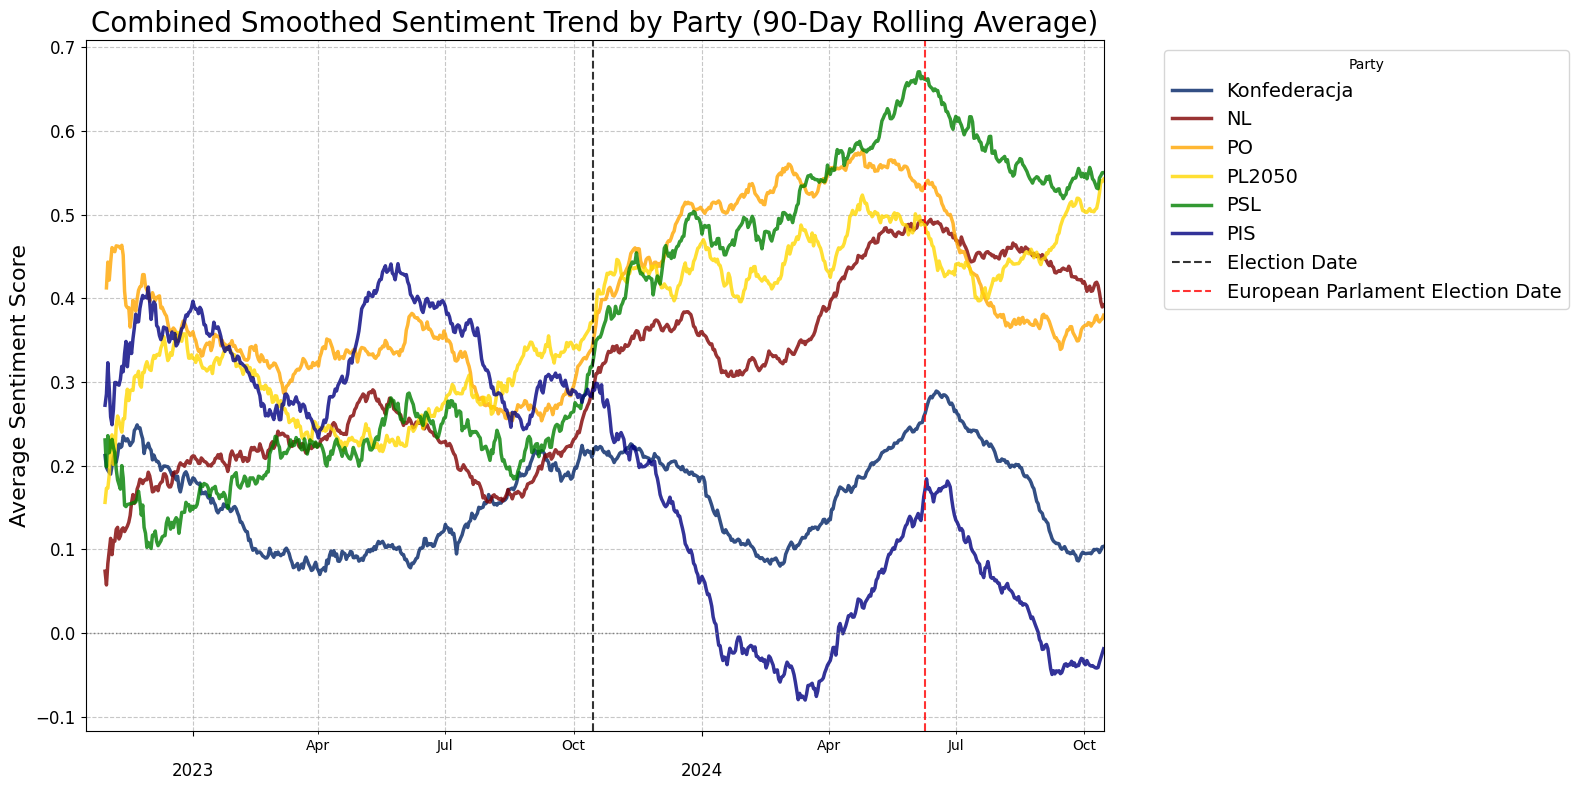


--- Generating Grid of Party Sentiment Trends ---


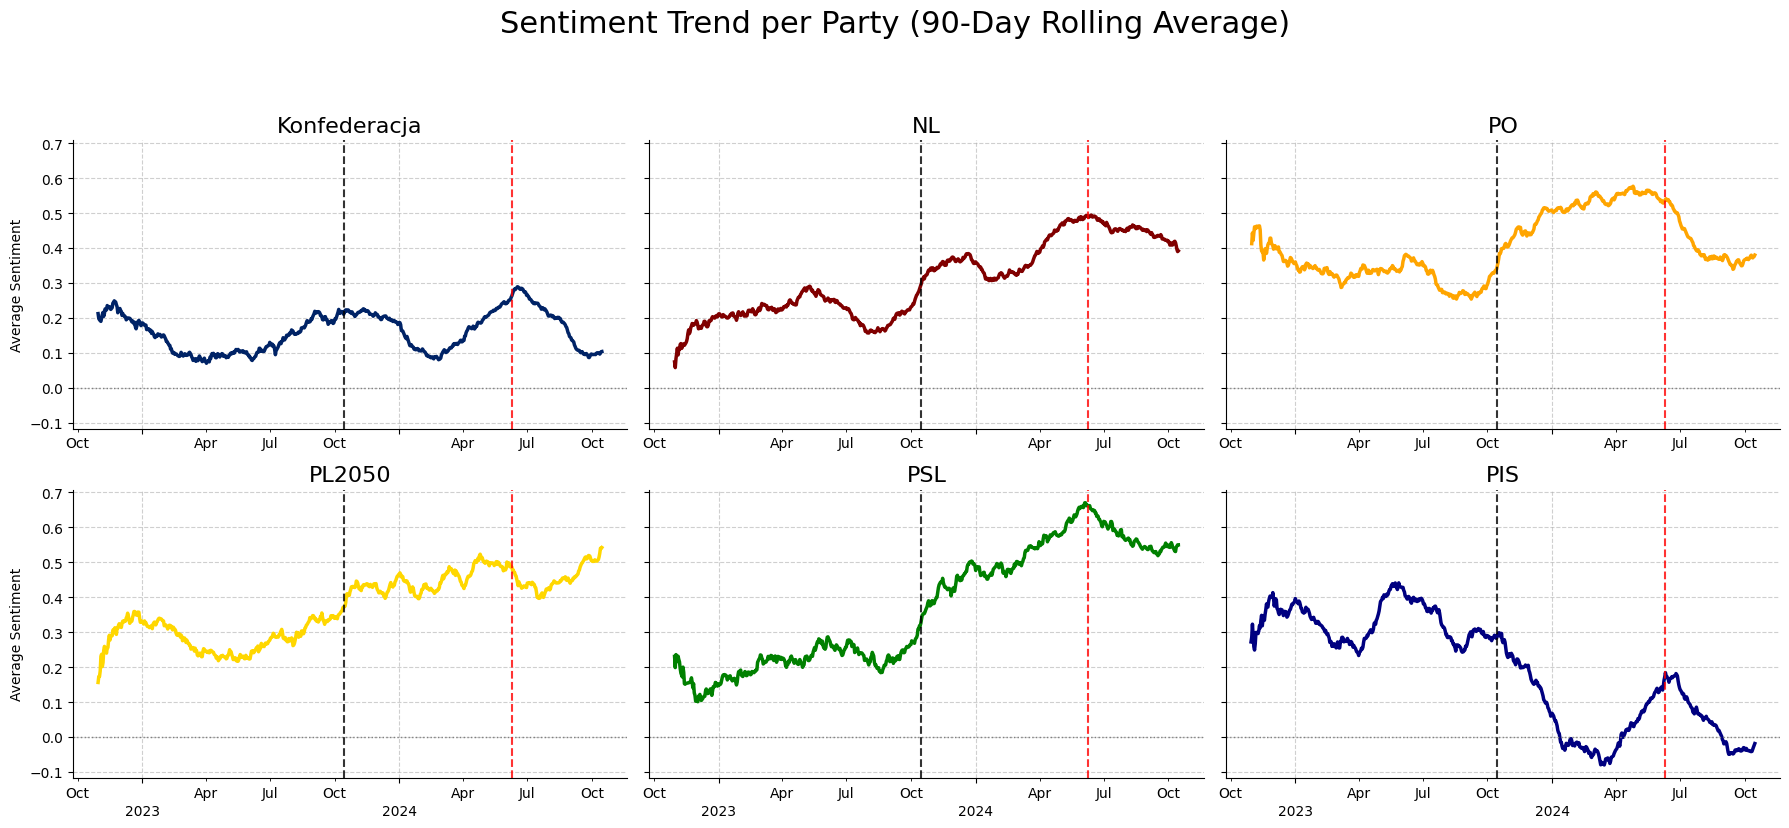


ANALYSIS 3: Significance Analysis Visualizations

--- Generating Heatmap Summary for All Time Windows ---


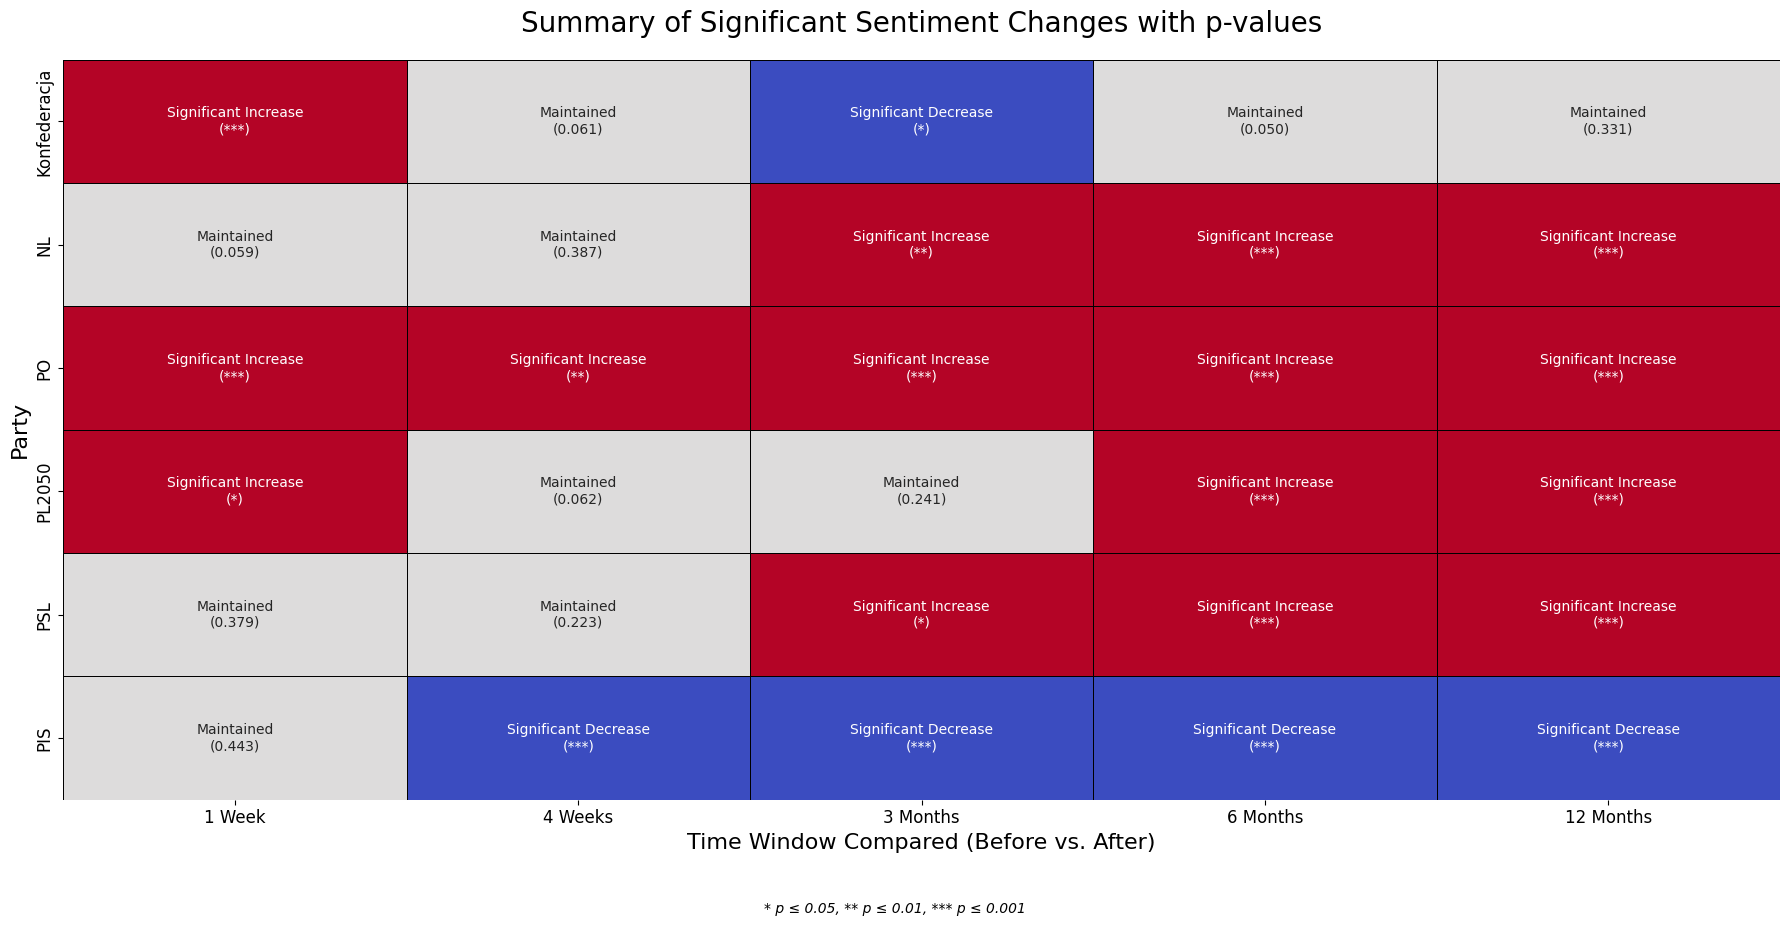


--- Generating Heatmap for 12-Month Window Only ---


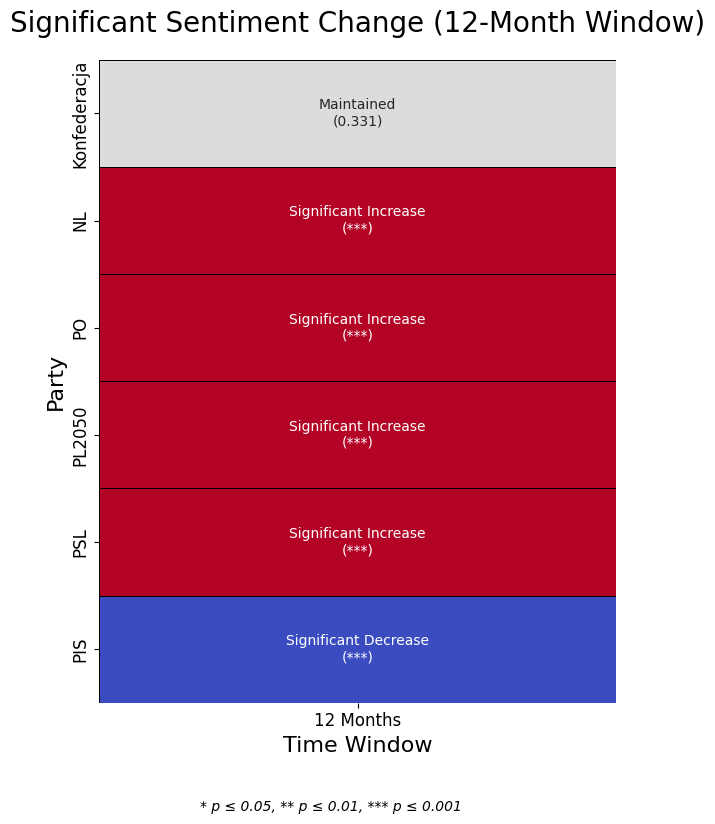


--- Generating Annotated Bar Chart for 12-Month Change ---


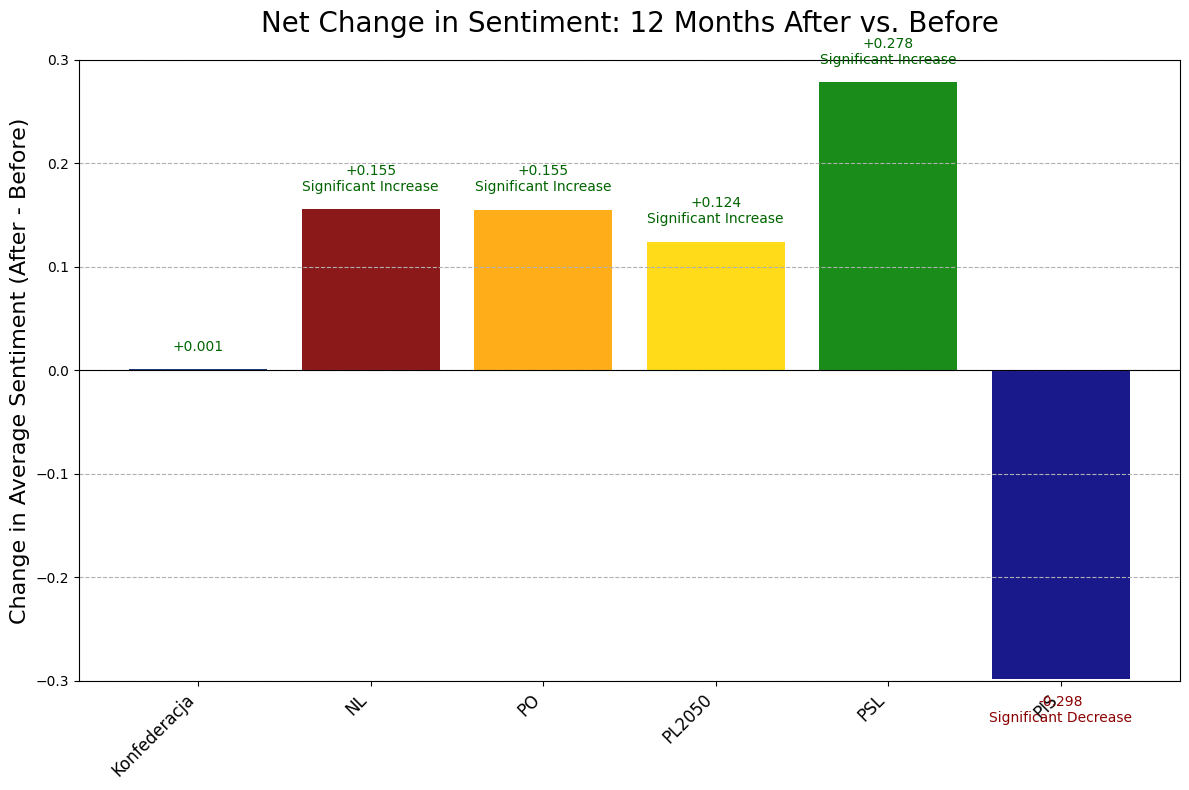


All analyses are complete. Plots have been saved to '../sentiment_OutputVisualizations/'


In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy import stats
from datetime import timedelta, timezone
from IPython.display import display
import os

# --- 0. Setup ---
font_settings = {
    'title': 20, 'suptitle': 22, 'label': 16,
    'tick': 12, 'legend': 14, 'annotation': 10, 'footnote': 10
}
key_dates = {
    "Election Date": ('2023-10-15', 'black', '--'),
    "European Parlament Election Date": ('2024-06-09', 'red', '--')
}
party_colors = {
    'Konfederacja': '#002366', 'NL': '#800000', 'PL2050': 'gold',
    'PO': 'orange', 'PSL': 'green', 'PIS': 'navy', 'Unknown_Party': 'grey'
}
party_order = ['Konfederacja', 'NL', 'PO', 'PL2050', 'PSL', 'PIS']

# ASSUMPTION: Your DataFrame 'df_for_bert' is loaded.
if 'df_for_bert' not in locals():
    raise NameError("Ensure 'df_for_bert' is defined before running this script.")

election_date = pd.to_datetime('2023-10-15', utc=True)

# --- 1. Granular Multi-Interval Sentiment Analysis ---
print("="*80 + "\nANALYSIS 1: Granular Sentiment Change Across Different Time Windows\n" + "="*80)
intervals = {'1 Week': 7, '4 Weeks': 28, '3 Months': 91, '6 Months': 182, '12 Months': 365}
all_results = []
directional_test_results = []
for label, days in intervals.items():
    before_start, after_end = election_date - timedelta(days=days), election_date + timedelta(days=days)
    df_b_interval = df_for_bert[(df_for_bert['created_at'] >= before_start) & (df_for_bert['created_at'] < election_date)]
    df_a_interval = df_for_bert[(df_for_bert['created_at'] >= election_date) & (df_for_bert['created_at'] < after_end)]
    for party in party_order:
        before_scores, after_scores = df_b_interval[df_b_interval['party'] == party]['sentiment_score'].dropna(), df_a_interval[df_a_interval['party'] == party]['sentiment_score'].dropna()
        if not before_scores.empty and not after_scores.empty:
            mean_before, mean_after = before_scores.mean(), after_scores.mean()
            all_results.append({'Party': party, 'Time Window': label, 'Sentiment Before': mean_before, 'Sentiment After': mean_after, 'Change': mean_after - mean_before})
            p_increase, p_decrease = stats.mannwhitneyu(before_scores, after_scores, alternative='less').pvalue, stats.mannwhitneyu(before_scores, after_scores, alternative='greater').pvalue
            direction = "Maintained"
            if p_increase < 0.05: direction = "Significant Increase"
            elif p_decrease < 0.05: direction = "Significant Decrease"
            directional_test_results.append({'Party': party, 'Time Window': label, 'P-Value (Increase)': p_increase, 'P-Value (Decrease)': p_decrease, 'Significant Direction': direction})
final_comparison_table, directional_stats_df = pd.DataFrame(all_results), pd.DataFrame(directional_test_results)
print("Directional significance tests complete.");

# --- 2. Time Series Visualizations ---
print("\n" + "="*80 + "\nANALYSIS 2: Time Series Visualizations\n" + "="*80)
def format_date_axis(ax):
    ax.xaxis.set_major_locator(mdates.YearLocator()); ax.xaxis.set_major_formatter(mdates.DateFormatter('\n%Y'))
    ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=[1, 4, 7, 10])); ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))
    ax.tick_params(axis='x', which='minor', labelsize=font_settings['tick'] - 2)
def add_event_lines(ax, dates_dict):
    for event, (date, color, style) in dates_dict.items():
        ax.axvline(pd.to_datetime(date, utc=True), color=color, linestyle=style, linewidth=1.5, label=event, alpha=0.8)

print("\n--- Generating Combined Sentiment Trend Plot ---")
fig, ax = plt.subplots(figsize=(16, 8))
for party in party_order:
    party_df = df_for_bert[df_for_bert['party'] == party]
    if not party_df.empty:
        party_df.set_index('created_at')['sentiment_score'].resample('D').mean().rolling(window=90, min_periods=15).mean().plot(label=party, color=party_colors.get(party, 'grey'), ax=ax, linewidth=2.5, alpha=0.8)
add_event_lines(ax, key_dates); ax.axhline(0, color='grey', linewidth=1, linestyle=':'); ax.set_title('Combined Smoothed Sentiment Trend by Party (90-Day Rolling Average)', fontsize=font_settings['title'])
ax.set_xlabel(None); ax.set_ylabel('Average Sentiment Score', fontsize=font_settings['label']); ax.tick_params(axis='both', labelsize=font_settings['tick'])
ax.grid(True, which='both', linestyle='--', alpha=0.7); format_date_axis(ax); ax.legend(title='Party', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=font_settings['legend'])
plt.tight_layout(); plt.savefig(os.path.join(output_dir, "sentiment_trend_combined.png")); plt.show()

print("\n--- Generating Grid of Party Sentiment Trends ---")
df_resampled = df_for_bert.groupby('party').resample('D', on='created_at')[['sentiment_score']].mean().reset_index()
df_resampled['rolling_sentiment'] = df_resampled.groupby('party')['sentiment_score'].transform(lambda x: x.rolling(window=90, min_periods=15).mean())
g = sns.FacetGrid(df_resampled, col="party", col_wrap=3, hue="party", palette=party_colors, col_order=party_order, height=4, aspect=1.5)
g.map(sns.lineplot, "created_at", "rolling_sentiment", lw=2.5); g.map(plt.axhline, y=0, color='grey', linestyle=':', lw=1)
for ax in g.axes.flat: format_date_axis(ax); ax.grid(True, linestyle='--', alpha=0.6); add_event_lines(ax, key_dates)
g.set_titles("{col_name}", size=font_settings['label']); g.set_axis_labels("", "Average Sentiment")
g.fig.suptitle('Sentiment Trend per Party (90-Day Rolling Average)', fontsize=font_settings['suptitle'], y=1.03)
plt.tight_layout(rect=[0, 0, 1, 0.97]); plt.savefig(os.path.join(output_dir, "sentiment_trend_grid.png")); plt.show()

# --- 3. Significance Analysis Visualizations ---
print("\n" + "="*80 + "\nANALYSIS 3: Significance Analysis Visualizations\n" + "="*80)
if not directional_stats_df.empty:
    def format_annotation(row):
        direction = row['Significant Direction']
        if direction == 'Significant Increase': p_val = row['P-Value (Increase)']
        elif direction == 'Significant Decrease': p_val = row['P-Value (Decrease)']
        else: p_val = min(row['P-Value (Increase)'], row['P-Value (Decrease)'])
        if p_val <= 0.001: p_text = '(***)'
        elif p_val <= 0.01: p_text = '(**)'
        elif p_val <= 0.05: p_text = '(*)'
        else: p_text = f'({p_val:.3f})'
        return f"{direction}\n{p_text}"
    directional_stats_df['heatmap_annotation'] = directional_stats_df.apply(format_annotation, axis=1)
    direction_map = {"Significant Increase": 1, "Maintained": 0, "Significant Decrease": -1}
    
    print("\n--- Generating Heatmap Summary for All Time Windows ---")
    heatmap_data = directional_stats_df.copy(); heatmap_data['direction_code'] = heatmap_data['Significant Direction'].map(direction_map)
    heatmap_pivot = heatmap_data.pivot_table(index='Party', columns='Time Window', values='direction_code')
    annot_pivot_text = heatmap_data.pivot_table(index='Party', columns='Time Window', values='heatmap_annotation', aggfunc='first')
    time_window_order = ['1 Week', '4 Weeks', '3 Months', '6 Months', '12 Months']
    heatmap_pivot = heatmap_pivot.reindex(columns=time_window_order, level=0).reindex(index=party_order)
    annot_pivot_text = annot_pivot_text.reindex(columns=time_window_order, level=0).reindex(index=party_order)
    plt.figure(figsize=(18, 9)); sns.heatmap(heatmap_pivot, annot=annot_pivot_text, fmt="", cmap="coolwarm", center=0, linewidths=.5, linecolor='black', cbar=False, annot_kws={"size": font_settings['annotation']})
    plt.title('Summary of Significant Sentiment Changes with p-values', fontsize=font_settings['title'], pad=20)
    plt.xlabel('Time Window Compared (Before vs. After)', fontsize=font_settings['label']); plt.ylabel('Party', fontsize=font_settings['label'])
    plt.tick_params(axis='both', labelsize=font_settings['tick'])
    plt.figtext(0.5, -0.02, '* p ≤ 0.05, ** p ≤ 0.01, *** p ≤ 0.001', ha="center", fontsize=font_settings['footnote'], style='italic')
    plt.tight_layout(rect=[0, 0.03, 1, 1]); plt.savefig(os.path.join(output_dir, "heatmap_summary_all_windows_with_pvalues.png")); plt.show()
    
    print("\n--- Generating Heatmap for 12-Month Window Only ---")
    df_12m_sig = directional_stats_df[directional_stats_df['Time Window'] == '12 Months'].copy()
    df_12m_sig['direction_code'] = df_12m_sig['Significant Direction'].map(direction_map)
    heatmap_pivot_12m = df_12m_sig.pivot_table(index='Party', columns='Time Window', values='direction_code').reindex(index=party_order)
    annot_pivot_12m = df_12m_sig.pivot_table(index='Party', columns='Time Window', values='heatmap_annotation', aggfunc='first').reindex(index=party_order)
    plt.figure(figsize=(6, 8)); sns.heatmap(heatmap_pivot_12m, annot=annot_pivot_12m, fmt="", cmap="coolwarm", center=0, linewidths=.5, linecolor='black', cbar=False, annot_kws={"size": font_settings['annotation']})
    plt.title('Significant Sentiment Change (12-Month Window)', fontsize=font_settings['title'], pad=20)
    plt.xlabel('Time Window', fontsize=font_settings['label']); plt.ylabel('Party', fontsize=font_settings['label'])
    plt.tick_params(axis='both', labelsize=font_settings['tick'])
    plt.figtext(0.5, -0.02, '* p ≤ 0.05, ** p ≤ 0.01, *** p ≤ 0.001', ha="center", fontsize=font_settings['footnote'], style='italic')
    plt.tight_layout(rect=[0, 0.03, 1, 1]); plt.savefig(os.path.join(output_dir, "heatmap_summary_12_months_with_pvalues.png")); plt.show()

    print("\n--- Generating Annotated Bar Chart for 12-Month Change ---")
    df_12m_full = final_comparison_table[final_comparison_table['Time Window'] == '12 Months'].set_index('Party')
    df_12m_sig_info = directional_stats_df[directional_stats_df['Time Window'] == '12 Months'].set_index('Party')
    df_12m_full = df_12m_full.join(df_12m_sig_info.drop('Time Window', axis=1))
    if not df_12m_full.empty:
        df_sorted = df_12m_full.reindex(party_order).dropna()
        plt.figure(figsize=(12, 8)); bar_colors = [party_colors.get(p, 'grey') for p in df_sorted.index]
        bars = plt.bar(df_sorted.index, df_sorted['Change'], color=bar_colors, alpha=0.9)
        plt.axhline(0, color='black', linewidth=0.8); plt.ylabel('Change in Average Sentiment (After - Before)', fontsize=font_settings['label'])
        plt.title('Net Change in Sentiment: 12 Months After vs. Before', fontsize=font_settings['title'], pad=20)
        plt.xticks(rotation=45, ha='right', fontsize=font_settings['tick']); plt.ylim(-0.3, 0.3)
        for i, party in enumerate(df_sorted.index):
            row = df_sorted.loc[party]; y_val = row['Change']; label_text = f"{y_val:+.3f}"
            if row['Significant Direction'] != 'Maintained': label_text += f"\n{row['Significant Direction']}"
            text_color = 'darkgreen' if y_val > 0 else 'darkred'; vertical_offset = y_val + (0.015 if y_val > 0 else -0.015)
            plt.text(i, vertical_offset, label_text, ha='center', va='bottom' if y_val > 0 else 'top', fontsize=font_settings['annotation'], color=text_color, bbox=dict(facecolor='white', alpha=0.0, edgecolor='none'))
        plt.grid(axis='y', linestyle='--'); plt.tight_layout()
        plt.savefig(os.path.join(output_dir, "annotated_barchart_12_month_change.png")); plt.show()
else:
    print("Significance tables not generated, skipping visualizations.")

print("\n" + "="*80); print(f"All analyses are complete. Plots have been saved to '{output_dir}/'"); print("="*80)

Additional analysis

**Methodology of the Analysis**

**1. Time Series Analysis and Signal Smoothing**
To analyze the evolution of sentiment over time, a 90-day rolling average was applied to the daily mean sentiment scores for each political party. 
This technique is a standard method of signal smoothing used in time series analysis to reduce noise and reveal underlying patterns.

Purpose: Raw daily sentiment data is inherently volatile, subject to sharp fluctuations from daily news cycles, specific events, or viral content. A rolling average acts as a low-pass filter, smoothing this short-term noise to reveal the more meaningful, underlying long-term trend in a party's communication tone. This makes it possible to distinguish sustained strategic shifts from ephemeral reactions.

Window Selection: A 90-day window was chosen as it provides an effective balance. It is long enough to mitigate the effects of weekly and monthly variations but short enough to remain sensitive to major, sustained shifts in communication strategy that occur over several months. This is crucial for visualizing the trajectory of sentiment leading into and following the election period.

**2. Statistical Significance and Directionality Testing**
The core of the analysis relies on statistical testing to ensure that observed changes are not the result of random chance.

**Choice of Test:** 

Mann-Whitney U Test: To compare the sentiment distributions from the periods before and after the election, the Mann-Whitney U test was selected. This non-parametric test is the correct choice for this application for few reasons:

It does not assume a normal distribution. As in Our sentiment scores, the distributions do not follow a Gaussian curve. The Mann-Whitney U test is valid for non-normal data, making its results more reliable than parametric tests like the t-test.

It is robust to imbalanced sample sizes. The number of posts before and after the election per party is not equal. The test effectively handles this imbalance by comparing the rank ordering of the data, not just the means, which prevents distortion from unequal group sizes.

Directional Testing for Analysis. A standard (two-sided) statistical test only indicates if a difference exists. To determine the nature of the change (i.e., an increase or a decrease), the analysis employs one-sided Mann-Whitney U tests. By setting the alternative parameter to 'less' and 'greater', two specific hypotheses are tested for each party across various time windows (e.g., 1 week, 4 weeks, 3 months, 6 months, 12 months):

alternative='less': Tests if the distribution of sentiment scores in the "after" period is stochastically greater than the "before" period, indicating a significant increase.

alternative='greater': Tests if the "after" period scores are stochastically less than the "before" period, indicating a significant decrease.

This directional approach provides much more complete picture, allowing for the classification of each sentiment shift. 

### 4.9. Virality Analysis

Early analyses - distributions

Exploratory Data Analysis: Skewness and Bin Distribution

--- Skewness of Engagement Metrics ---
A skewness value > 1 or < -1 suggests high skewness.
The table below shows how log transformation reduces this skewness.


Skewness Before Log  Skewness After Log
impression_count                14.344341                 NaN
like_count                       8.670951                 NaN
log_impression_count                  NaN           -0.916279
log_like_count                        NaN           -0.023387
log_reply_count                       NaN            0.378759
log_retweet_count                     NaN            0.293226
reply_count                      6.674852                 NaN
retweet_count                    9.205060                 NaN


--- Visualizing a reduction in skewness after log transformation ---


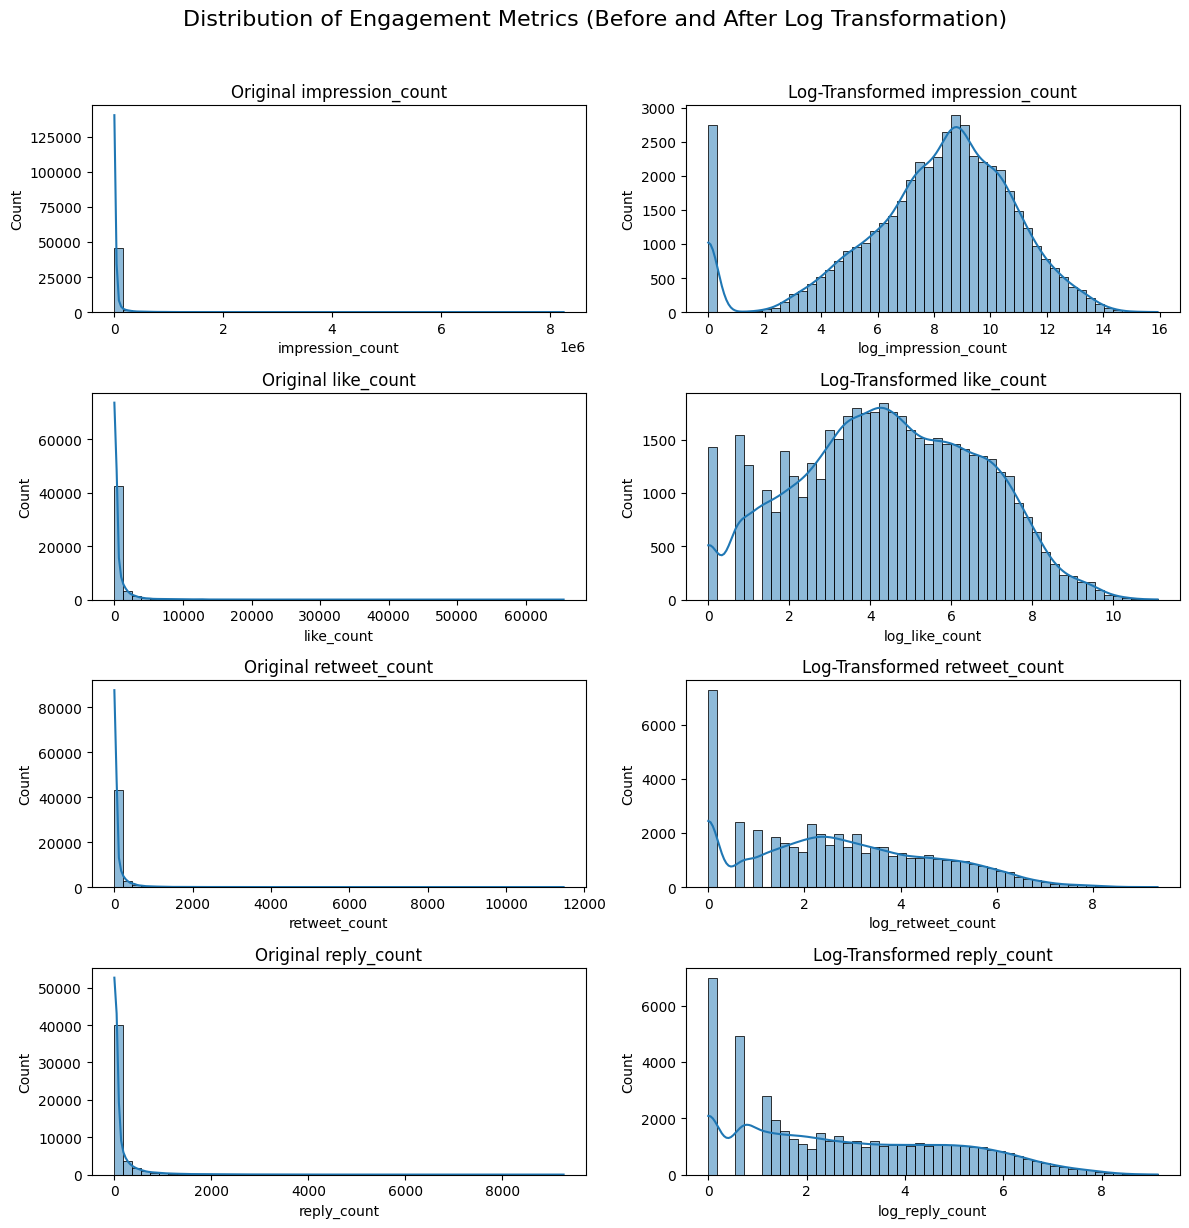



Bin Count Analysis (5-Category Approach)
Counts for the 5 sentiment categories:


Tweet Count  Percentage
sentiment_bin_labels                         
Very Negative                9500       19.66
Negative                     4156        8.60
Neutral                      4353        9.01
Positive                     6126       12.68
Very Positive               24196       50.06



Bin Count Analysis (0.1 Interval Approach)

Counts for sentiment bins with 0.1 width:


Tweet Count  Percentage
sentiment_granular_bin                         
(-1.0, -0.9]                   4917       10.17
(-0.9, -0.8]                   1651        3.42
(-0.8, -0.7]                   1112        2.30
(-0.7, -0.6]                    930        1.92
(-0.6, -0.5]                    890        1.84
(-0.5, -0.4]                    941        1.95
(-0.4, -0.3]                    906        1.87
(-0.3, -0.2]                   1035        2.14
(-0.2, -0.1]                   1274        2.64
(-0.1, -2.22e-16]              2013        4.17
(-2.22e-16, 0.1]               2340        4.84
(0.1, 0.2]                     1658        3.43
(0.2, 0.3]                     1470        3.04
(0.3, 0.4]                     1439        2.98
(0.4, 0.5]                     1559        3.23
(0.5, 0.6]                     1603        3.32
(0.6, 0.7]                     1793        3.71
(0.7, 0.8]                     2422        5.01
(0.8, 0.9]                     3359        6.95
(0.9, 1.0]                    15019       31.08

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# --- Exploratory Data Analysis (EDA) ---
print("="*80)
print("Exploratory Data Analysis: Skewness and Bin Distribution")
print("="*80)

virality_metrics = ['impression_count', 'like_count', 'retweet_count', 'reply_count']

# === 1. Skewness Analysis for Engagement Metrics ===
print("\n--- Skewness of Engagement Metrics ---")
skew_before = df_for_bert[virality_metrics].skew()

for metric in virality_metrics:
    df_for_bert[f'log_{metric}'] = np.log(df_for_bert[metric] + 1)
skew_after = df_for_bert[[f'log_{metric}' for metric in virality_metrics]].skew()

skew_df = pd.DataFrame({'Skewness Before Log': skew_before, 'Skewness After Log': skew_after})
print("A skewness value > 1 or < -1 suggests high skewness.")
print("The table below shows how log transformation reduces this skewness.")
display(skew_df)

print("\n--- Visualizing a reduction in skewness after log transformation ---")
fig, axes = plt.subplots(len(virality_metrics), 2, figsize=(12, 12))
fig.suptitle('Distribution of Engagement Metrics (Before and After Log Transformation)', fontsize=16, y=1.02)
for i, metric in enumerate(virality_metrics):
    sns.histplot(df_for_bert[metric], ax=axes[i, 0], kde=True, bins=50).set_title(f'Original {metric}')
    sns.histplot(df_for_bert[f'log_{metric}'], ax=axes[i, 1], kde=True, bins=50).set_title(f'Log-Transformed {metric}')
plt.tight_layout()
plt.show()


# === 2. Bin Count Analysis (5-Category Approach) ===
print("\n\n" + "="*50)
print("Bin Count Analysis (5-Category Approach)")
print("="*50)

bins = [-1.01, -0.5, -0.1, 0.1, 0.5, 1.01]
labels = ['Very Negative', 'Negative', 'Neutral', 'Positive', 'Very Positive']
df_for_bert['sentiment_bin_labels'] = pd.cut(df_for_bert['sentiment_score'], bins=bins, labels=labels, ordered=True)

bin_counts = df_for_bert['sentiment_bin_labels'].value_counts().sort_index().to_frame('Tweet Count')
bin_counts['Percentage'] = (bin_counts['Tweet Count'] / bin_counts['Tweet Count'].sum() * 100).round(2)
print("Counts for the 5 sentiment categories:")
display(bin_counts)


# === 3. Bin Count Analysis (0.1 Interval Approach) ===
print("\n\n" + "="*50)
print("Bin Count Analysis (0.1 Interval Approach)")
print("="*50)

# Create bins from -1.0 to 1.0 with a step of 0.1
granular_bins = np.arange(-1.0, 1.1, 0.1)
df_for_bert['sentiment_granular_bin'] = pd.cut(df_for_bert['sentiment_score'], bins=granular_bins)

granular_counts = df_for_bert['sentiment_granular_bin'].value_counts().sort_index().to_frame('Tweet Count')
granular_counts['Percentage'] = (granular_counts['Tweet Count'] / granular_counts['Tweet Count'].sum() * 100).round(2)

print("\nCounts for sentiment bins with 0.1 width:")
display(granular_counts)

count    48331.000000
mean         0.288117
std          0.696095
min         -0.997574
25%         -0.228351
50%          0.502389
75%          0.950317
max          0.999195
Name: sentiment_score, dtype: float64


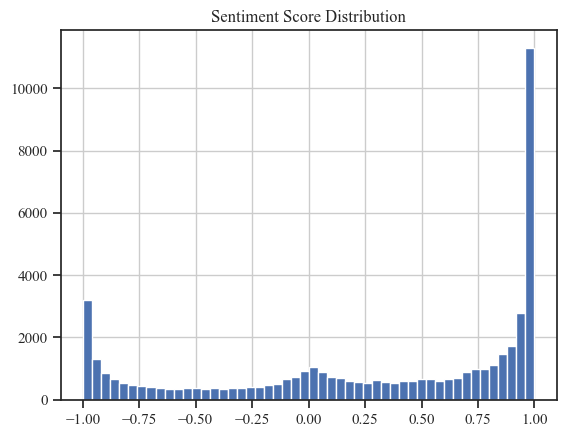

In [59]:
print(df_for_bert['sentiment_score'].describe())
df_for_bert['sentiment_score'].hist(bins=50)
plt.title('Sentiment Score Distribution')
plt.show()

---

#### Part I: The Research Challenge

##### Why This Analysis Matters

Political communication has fundamentally shifted to digital platforms, yet most analyses of this space suffer from critical flaws that render their conclusions unreliable. Traditional approaches count raw likes or retweets, which tells us more about who is popular than what content actually works. They treat all sentiment equally, missing the crucial intensity differences between mild criticism and fierce attacks. They ignore that social media dynamics change rapidly, making yesterday's baseline obsolete today.

Our methodology systematically addresses each of these problems to extract insights from the noise of social media data.

##### The Core Questions

1. **Does sentiment affect political engagement on Twitter?** Not just whether positive or negative content gets more likes, but whether emotional framing genuinely changes how content performs relative to expectations.

2. **Do different parties benefit differently from sentiment strategies?** Is there a universal "best" approach, or do parties need customized strategies based on their position and audience?

3. **How robust are these patterns?** Are findings artifacts of analytical choices, or do they represent real, actionable patterns?

---

#### Part II: Methodological Framework

##### Step 1: Measuring Sentiment as a Spectrum

**What We Do:**
Calculate sentiment scores as the weighted sum of sentiment probabilities, where positive sentiment contributes +1, neutral contributes 0, and negative contributes -1. This creates a continuous scale from -1 (purely negative) to +1 (purely positive).

**Formula:**
$$S_i = 1 \cdot Pos_i + 0 \cdot Neu_{i} + (-1) \cdot Neg_{i}$$

Since probabilities sum to 1 ($Pos_i + Neu_{i} + Neg_{i} = 1$), this simplifies to:
$$S_i = Pos_i - Neg_{i}$$

Where:
- $S_i$ = Sentiment score for tweet $i$
- $Pos_i$ = Positive probability from BERT model (0 to 1)
- $Neu_{i}$ = Neutral probability from BERT model (0 to 1)
- $Neg_{i}$ = Negative probability from BERT model (0 to 1)

**Why This Approach:**
Binary positive/negative classification loses critical information. A tweet with 90% negative probability is fundamentally different from one with 55% negative probability, yet traditional analysis treats them identically. Our continuous score preserves these intensity differences, capturing the full emotional spectrum of political discourse.

The weighted sum approach naturally accounts for mixed sentiment—tweets that contain both positive and negative elements. When neutral probability is high, the score approaches zero, correctly identifying genuinely neutral content. When sentiment is polarized (high positive or negative), the score moves toward the extremes, capturing strong emotional content.

**The Binning Strategy:**
We divide the continuous scores into five categories:
- Very Negative (-1.0 to -0.6)
- Negative (-0.6 to -0.2)
- Neutral (-0.2 to 0.2)
- Positive (0.2 to 0.6)
- Very Positive (0.6 to 1.0)

These thresholds aren't arbitrary—they emerge from the actual distribution of Polish political tweets, which shows natural clustering around these points. The narrow neutral zone reflects reality: true neutrality is rare in political communication. Politicians are in the business of persuasion, not balanced reporting.

##### Step 2: Solving the Popularity Problem

**The Fundamental Challenge:**
A tweet from a major politician getting 1,000 retweets might be underperforming, while 100 retweets for a local councillor could be exceptional. Raw metrics conflate popularity with performance, making it impossible to determine what actually drives engagement.

**Our Solution - Relative Virality:**

**Formula:**
$$RV_{i,m} = \frac{E_{i,m}}{B_{a[i],t[i],m} + 1}$$

Where:
- $RV_{i,m}$ = Relative virality for tweet $i$ on metric $m$
- $E_{i,m}$ = Actual engagement for tweet $i$
- $B_{a[i],t[i],m}$ = Baseline (expected engagement) for author $a$ at time $t$
- +1 prevents division by zero

Expected engagement is the author's average performance over the previous 90 days, requiring at least 10 tweets for reliability. This transforms raw metrics into performance ratios:
- 1.0 means performing exactly as expected
- 2.0 means twice normal engagement
- 0.5 means half normal engagement 

**Why 90 Days Specifically:**
- **30 days is too volatile:** One viral tweet or temporary campaign skews the baseline
- **180 days is too static:** Misses changes in political relevance, appointments, scandals
- **90 days is optimal:** Balances stability

The rolling window adapts to each author's changing relevance. A politician appointed to cabinet sees their baseline gradually adjust to their new prominence. Someone involved in a scandal sees their temporary spike smooth out over three months.

**The Technical Details That Matter:**
- We exclude the current tweet from its own baseline (no data leakage)
- Adding 1 to the denominator prevents division by zero and acts as statistical smoothing
- This approach is mathematically equivalent to empirical Bayes estimation

##### Step 3: Handling Extreme Outliers

**The Problem:**
Social media has extreme skewness. One mega-viral tweet (often due to external media coverage or breaking news) can get 1000x normal engagement, completely distorting averages and making statistical tests invalid.

**Our Solution:**
Cap relative virality scores at the 99th percentile.

**Formula:**
$$RV^{cap}_{i,m} = \min(RV_{i,m}, Q_{99}(RV_m))$$

Where $Q_{99}(RV_m)$ = 99th percentile of all $RV$ scores for metric $m$

**Why This Specific Approach:**
- **Capping at 95th percentile:** Too aggressive, removes genuinely successful content strategies
- **No capping:** Allows single tweets to dominate entire party averages
- **99th percentile:** Optimal balance—preserves 99% of variation while removing distortions (also to consider, 99.5th or 99.8th)

Capping is superior to removing outliers (which creates selection bias) or log transformation (which changes interpretation). Our approach keeps all data points while preventing extreme values from dominating results.

**Why Not Log Transformation?**
While log transformation can normalize skewed distributions (as shown in our diagnostic plots), we chose capping because:
- Relative virality already handles much of the skewness
- Capped scores remain directly interpretable ("2x baseline")
- Log-transformed ratios lose intuitive meaning
- Our non-parametric tests don't require normality anyway

##### Step 4: From Individual to Party-Level Insights

**The Aggregation Challenge:**
Parties consist of members with vastly different activity levels and roles. Some tweet 50 times per day, others once per week. Some are attack dogs posting mostly negative content, others focus on policy. Simple averages would be meaningless.

**Our Three-Stage Solution:**

**1. Calculate author-sentiment averages:**
$$\overline{RV}_{a,s,m} = \frac{1}{n_{a,s}} \sum_{i \in T_{a,s}} RV^{cap}_{i,m}$$

Where:
- $\overline{RV}_{a,s,m}$ = Average relative virality for author $a$, sentiment $s$, metric $m$
- $a$ = Specific author/politician
- $s$ = Sentiment category (Very Negative, Negative, Neutral, Positive, Very Positive)
- $m$ = Engagement metric (impressions, likes, retweets, replies)
- $n_{a,s}$ = Number of tweets by author $a$ with sentiment $s$
- $T_{a,s}$ = Set of all tweets by author $a$ with sentiment $s$
- $i$ = Individual tweet index
- $RV^{cap}_{i,m}$ = Capped relative virality score for tweet $i$ on metric $m$

Each author's typical performance when posting each sentiment type.

**2. Weight by contribution:**
$$w_{a,p,s} = \frac{n_{a,s}}{\sum_{a' \in p} n_{a',s}}$$

Where:
- $w_{a,p,s}$ = Weight for author $a$ in party $p$ for sentiment $s$
- $p$ = Political party
- $n_{a,s}$ = Number of tweets by author $a$ with sentiment $s$
- $a' \in p$ = All authors belonging to party $p$
- $\sum_{a' \in p} n_{a',s}$ = Total number of tweets with sentiment $s$ from all party $p$ members

Authors who post more of a particular sentiment get more weight in that category's party score. We use tweet counts, not engagement, to avoid double-counting popularity.

**3. Aggregate to party scores:**
$$\text{PartyRV}_{p,s,m} = \sum_{a \in p} w_{a,p,s} \times \overline{RV}_{a,s,m}$$

Where:
- $\text{PartyRV}_{p,s,m}$ = Party-level relative virality for party $p$, sentiment $s$, metric $m$
- $\sum_{a \in p}$ = Sum over all authors in party $p$
- $w_{a,p,s}$ = Weight for author $a$ (from step 2)
- $\overline{RV}_{a,s,m}$ = Author's average relative virality (from step 1)

Weighted average gives us party-level performance for each sentiment.

**Why This Matters:**
This method reveals both individual strategies (how each politician optimizes their content) and collective patterns (how parties as organizations use sentiment). It makes parties comparable despite having different numbers of members and activity levels.

##### Step 5: Statistical Validation

**The Statistical Challenges:**
Social media data violates every assumption of traditional statistics:
- Extreme skewness (even after transformation)
- Hierarchical structure (tweets within authors within parties)
- Temporal dependencies (viral cascades)
- Heterogeneous variance across groups

**Our Multi-Method Approach:**

**Kruskal-Wallis Test:**
$$H = \frac{12}{N(N+1)} \sum_{s=1}^{5} \frac{R_s^2}{n_s} - 3(N+1)$$

Where:
- $H$ = Kruskal-Wallis test statistic
- $N$ = Total number of observations (all tweets)
- $s$ = Sentiment category index (1 to 5 for our five categories)
- $R_s$ = Sum of ranks for all tweets in sentiment category $s$
- $n_s$ = Number of tweets in sentiment category $s$

A non-parametric alternative to ANOVA that requires no distributional assumptions. This tests whether sentiment groups differ significantly without assuming normality.

**Mixed-Effects Regression:**
$$RV^{cap}_{i,m} = \beta_0 + \sum_{s \neq \text{Neutral}} \beta_s \cdot I(S_i = s) + u_{a[i]} + \epsilon_i$$

Where:
- $RV^{cap}_{i,m}$ = Capped relative virality for tweet $i$ on metric $m$ (dependent variable)
- $\beta_0$ = Intercept (baseline effect for neutral sentiment)
- $\beta_s$ = Fixed effect coefficient for sentiment category $s$
- $I(S_i = s)$ = Indicator function (1 if tweet $i$ has sentiment $s$, 0 otherwise)
- $S_i$ = Sentiment category of tweet $i$
- $u_{a[i]}$ = Random effect for the author of tweet $i$ (captures author-specific variation)
- $a[i]$ = Author who posted tweet $i$
- $\epsilon_i$ = Residual error for tweet $i$

Accounts for the nested data structure with random effects for authors. This prevents prolific tweeters from inflating significance and provides unbiased estimates of sentiment effects.

**Cohen's d Effect Sizes:**
$$d = \frac{\overline{RV}_{\text{Very Negative}} - \overline{RV}_{\text{Very Positive}}}{\sqrt{\frac{s^2_{\text{VN}} + s^2_{\text{VP}}}{2}}}$$

Where:
- $d$ = Cohen's d effect size
- $\overline{RV}_{\text{Very Negative}}$ = Mean relative virality for Very Negative tweets
- $\overline{RV}_{\text{Very Positive}}$ = Mean relative virality for Very Positive tweets
- $s^2_{\text{VN}}$ = Variance of relative virality for Very Negative tweets
- $s^2_{\text{VP}}$ = Variance of relative virality for Very Positive tweets

Quantifies the practical magnitude of differences. With large datasets, everything is "statistically significant"—effect sizes tell us what actually matters:
- d < 0.2: Negligible (not worth changing strategy)
- d = 0.2-0.5: Small (marginal strategic value)
- d = 0.5-0.8: Medium (significant opportunity)
- d > 0.8: Large (critical strategic factor)

**Interaction Models:**
$$RV^{cap}_{i,m} = \beta_0 + \sum_{s} \sum_{p} \beta_{s,p} \cdot I(S_i = s) \cdot I(P_i = p) + u_{a[i]} + \epsilon_i$$

Where:
- $\beta_{s,p}$ = Interaction coefficient for sentiment $s$ and party $p$
- $I(S_i = s)$ = 1 if tweet $i$ has sentiment $s$, 0 otherwise
- $I(P_i = p)$ = 1 if tweet $i$ is from party $p$, 0 otherwise
- $P_i$ = Party of tweet $i$'s author
- All other terms as defined above

Test whether parties benefit differently from sentiment strategies. Significant interactions mean one-size-fits-all advice is wrong—parties need customized approaches.

##### Step 6: Ensuring Robustness

**Sensitivity Analysis:**
We test whether findings depend on specific analytical choices:
- Different baseline windows (30, 60, 120 days)
- Different capping thresholds (95th, 97.5th percentiles)
- Different weighting methods (tweet-based vs. engagement-based)

Consistent results across variations confirm robust patterns, not analytical artifacts.

**Bootstrap Confidence Intervals:**
$$CI_{95\%} = [Q_{2.5}(\theta^*), Q_{97.5}(\theta^*)]$$

Where $\theta^*$ = Bootstrap distribution of statistic

Provides robust uncertainty estimates without distributional assumptions.

---

#### Part III: Key Findings

FIX

---

#### Part IV: Statistical Validation

FIX

---

#### Part V: Strategic Implications

##### For Political Communicators

**The Uncomfortable Truth:**
The platform rewards negativity. Fighting this means accepting lower engagement. The question isn't whether to use negative content, but how to use it strategically while maintaining authentic voice and values.

**Optimization Strategies:**

1. **Sandwich Approach:** Surround positive announcements with critical framing to maintain algorithmic visibility

2. **Audience Segmentation:** Use negativity for broad reach, positivity for base mobilization

3. **Platform Diversification:** Reserve positive messaging for platforms with different dynamics

4. **Timing Optimization:** Negative content for peak hours (maximum reach), positive for off-hours (dedicated followers)

##### For Platforms

These findings reveal how engagement-optimized algorithms shape political discourse. Platforms must decide whether maximum engagement or democratic discourse quality is the priority. Current systems create powerful incentives for polarization.

##### For Democracy

The systematic advantage of negative content raises questions about digital public spheres. When the infrastructure of political communication rewards conflict over construction, what happens to democratic deliberation? These aren't just technical issues—they're fundamental challenges to democratic discourse.

---

#### Part VI: Methodological Advantages

##### Why This Analysis Is Superior

**Versus Raw Metrics:**
We measure performance relative to expectations, not absolute numbers. This reveals what actually drives engagement versus what just correlates with popularity.

**Versus Simple Sentiment Analysis:**
Our intensity-preserving approach captures the full spectrum of emotional expression, not just binary classification.

**Versus Static Baselines:**
Our rolling windows adapt to changing political dynamics, maintaining relevance as contexts shift.

**Versus Single-Level Analysis:**
Our hierarchical approach provides insights from individual tweets through party strategies, revealing patterns at every level.

**Versus P-Values Alone:**
Effect sizes quantify practical importance, preventing "significant but meaningless" findings common in big data.

**Versus Log Transformation:**
While log transformation can normalize distributions, our approach maintains interpretability. A relative virality of 2.0 clearly means "twice expected engagement," while log-transformed metrics lose this intuitive meaning.

##### The Technical Innovation

This methodology introduces several innovations to social media analysis:

1. **Temporal Baseline Normalization:** 90-day rolling windows that adapt to changing author prominence

2. **Hierarchical Aggregation:** Preserving individual variation while generating party-level insights

3. **Robust Statistical Framework:** Combining non-parametric tests, mixed-effects models, and effect sizes

4. **Sensitivity-Tested Conclusions:** Ensuring findings aren't artifacts of analytical choices

---

#### Part VII: The Conclusion

FIX

####  PART VIII: THE CODE

In short

1. Sentiment Quantification
What: The first step is to quantify the emotional tone of each tweet on a continuous scale.


How: The analysis uses a RoBERTa-based language model to assign probabilities for negative, neutral, and positive sentiment to each tweet. A sentiment score is then calculated for each tweet using the formula 

**Formula:**
$$S_i = 1 \cdot Pos_i + 0 \cdot Neu_{i} + (-1) \cdot Neg_{i}$$

Since probabilities sum to 1 ($Pos_i + Neu_{i} + Neg_{i} = 1$), this simplifies to:
$$S_i = Pos_i - Neg_{i}$$

Where:
- $S_i$ = Sentiment score for tweet $i$
- $Pos_i$ = Positive probability from BERT model (0 to 1)
- $Neu_{i}$ = Neutral probability from BERT model (0 to 1)
- $Neg_{i}$ = Negative probability from BERT model (0 to 1)

​
 , resulting in a scale from -1 (most negative) to +1 (most positive). These scores are then grouped into five distinct categories (e.g., Very Negative, Neutral, etc.).

2. Normalizing Engagement
What: The second step is to create a fair metric for audience engagement that is not biased by a politician's existing popularity.


How: The analysis introduces a Relative Virality (RV) score. This is calculated by taking a tweet's actual engagement (such as likes or impressions) and dividing it by that specific author's own 90-day average performance. This normalizes the data, meaning a tweet from any politician with an RV score of 2.0 performed twice as well as their personal baseline. To handle extreme outliers, these RV scores are capped at the 99th percentile.

3. Statistical Analysis
What: The final step is to use the prepared data (sentiment categories and RV scores) to formally test the relationship between a tweet's emotional framing and the engagement it receives.

How: A multi-method approach is used for robust validation:


Kruskal-Wallis Test: A non-parametric test is first used to confirm that there are statistically significant differences in engagement across the sentiment groups without assuming the data fits a normal distribution.


Model A (Overall Effects): A mixed-effects regression model is used to measure the average effect of each sentiment category across all parties combined. This model includes "random effects" for each author, which statistically controls for their individual baseline popularity, preventing prolific tweeters from skewing the results.


Model B (Interaction Effects): A second, more complex mixed-effects model is used to test if the relationship between sentiment and engagement is different for different political parties. This model checks for significant "interaction effects" to see if parties benefit differently from using certain emotional tones.

##### ARTICLE #1

In [77]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from IPython.display import display
# from scipy import stats
# from matplotlib.patches import Patch
# from matplotlib.collections import PatchCollection
# from pathlib import Path
# import warnings

# warnings.filterwarnings('ignore')

# # --- Font Configuration ---
# try:
#     sns.set_theme(
#         style="ticks",
#         font="Times New Roman",
#         rc={
#             "font.weight": "normal",
#             "axes.labelweight": "normal",
#             "axes.titleweight": "normal"
#         }
#     )
#     print("Theme set to seaborn 'ticks' with Times New Roman.")
# except RuntimeError:
#     sns.set_theme(style="ticks")
#     print("Warning: Times New Roman not found. Using seaborn 'ticks' style with default font.")

# # --- 0. Setup ---
# plots_dir = Path(output_dir) / 'plots'
# plots_dir.mkdir(parents=True, exist_ok=True)

# DPI_SETTING = 300
# font_settings = {
#     'title': {'size': 18, 'family': 'serif'},
#     'label': {'size': 14, 'family': 'serif'},
#     'tick': {'size': 12, 'family': 'serif'},
#     'legend': {'size': 12, 'family': 'serif'},
#     'annotation': {'size': 11, 'family': 'serif'}
# }
# party_colors = {
#     'Konfederacja': '#002366', 'NL': '#800000', 'PL2050': 'gold',
#     'PO': 'orange', 'PSL': 'green', 'PIS': 'navy', 'Unknown_Party': 'grey'
# }

# # ASSUMPTION: Your DataFrame 'df_for_bert' is loaded.
# if 'sentiment_score' not in df_for_bert.columns:
#     df_for_bert['sentiment_score'] = df_for_bert['positive_bert'] - df_for_bert['negative_bert']
# df_for_bert['created_at'] = pd.to_datetime(df_for_bert['created_at'], utc=True)
# election_date = pd.to_datetime('2023-10-15', utc=True)
# df_before = df_for_bert[df_for_bert['created_at'] < election_date].copy()
# df_after = df_for_bert[df_for_bert['created_at'] >= election_date].copy()

# # --- 1. Main Data Calculation ---
# def calculate_overall_sentiment_change(df_b, df_a):
#     if df_b.empty or df_a.empty: return None
#     senti_before = df_b.groupby('party')['sentiment_score'].agg(['mean', 'count']).rename(columns={'mean': 'sentiment_before', 'count': 'tweets_before'})
#     senti_after = df_a.groupby('party')['sentiment_score'].agg(['mean', 'count']).rename(columns={'mean': 'sentiment_after', 'count': 'tweets_after'})
#     comparison_df = pd.concat([senti_before, senti_after], axis=1).fillna(0)
#     comparison_df['change'] = comparison_df['sentiment_after'] - comparison_df['sentiment_before']
#     p_values = [stats.mannwhitneyu(df_b[df_b['party'] == p]['sentiment_score'], df_a[df_a['party'] == p]['sentiment_score']).pvalue 
#                 if not df_b[df_b['party'] == p].empty and not df_a[df_a['party'] == p].empty else np.nan 
#                 for p in comparison_df.index]
#     comparison_df['p_value'] = p_values
#     return comparison_df

# comparison_table = calculate_overall_sentiment_change(df_before, df_after) if not df_for_bert.empty else None
# if comparison_table is not None:
#     print("--- Overall Sentiment Change Data ---")
#     display(comparison_table)

# # --- 2. Visualization Functions ---
# def plot_main_vertical_bar(df, colors_dict):
#     if df is None: return
#     print("\n" + "="*80 + "\nPlot 1: Overall Sentiment Change (Vertical Bar Chart)\n" + "="*80 + "\n")
#     party_order = ['Konfederacja', 'NL', 'PO', 'PL2050', 'PSL', 'PIS']
#     plot_df = df.reindex(party_order).dropna(subset=['sentiment_before'])
#     parties = plot_df.index; x = np.arange(len(parties)); width = 0.4
#     fig, ax = plt.subplots(figsize=(12, 8))
#     ax.bar(x - width/2, plot_df['sentiment_before'], width, color=[colors_dict.get(p, 'grey') for p in parties], alpha=0.6, label='Before Election')
#     ax.bar(x + width/2, plot_df['sentiment_after'], width, color=[colors_dict.get(p, 'grey') for p in parties], alpha=1.0, label='After Election')
#     for i, party in enumerate(parties):
#         change_val = plot_df.loc[party, 'change']
#         p_val = plot_df.loc[party, 'p_value']
#         if p_val < 0.001: stars = '***'
#         elif p_val < 0.01: stars = '**'
#         elif p_val < 0.05: stars = '*'
#         else: stars = ''
#         change_text = f'{change_val:+.2f}\n({p_val:.3f}{stars})'
#         label_color = 'green' if change_val >= 0 else 'red'
#         val_before = plot_df.loc[party, 'sentiment_before']
#         val_after = plot_df.loc[party, 'sentiment_after']
#         y_pos = max(val_before, val_after) + 0.02
#         va = 'bottom'
#         ax.text(i, y_pos, change_text, ha='center', color=label_color, fontweight='bold', va=va, **font_settings['annotation'])
#     ax.set_ylabel('Average Sentiment Score', **font_settings['label'])
#     ax.set_title('Overall Sentiment Change by Party (Before vs. After Election)', **font_settings['title'])
#     ax.set_xticks(x); ax.set_xticklabels(parties, rotation=45, ha='right', **font_settings['tick'])
#     ax.set_ylim(-0.1, 0.8)  # Extended range
#     for tick_label in ax.get_xticklabels(): 
#         tick_label.set_color(colors_dict.get(tick_label.get_text(), 'black'))
#         tick_label.set_fontweight('bold')
#     ax.legend(title="Period", fontsize=font_settings['legend']['size'])
#     ax.axhline(0, color='black', linewidth=1, linestyle=':')
#     ax.grid(axis='y', linestyle='--', alpha=0.7)
#     sns.despine()
#     fig.tight_layout()
    
#     # Save plot
#     png_path = plots_dir / 'plot1_vertical_bar_change.png'
#     pdf_path = plots_dir / 'plot1_vertical_bar_change.pdf'
#     plt.savefig(png_path, dpi=DPI_SETTING, bbox_inches='tight')
#     plt.savefig(pdf_path, bbox_inches='tight')
#     print(f"Saved as PNG: '{png_path}'")
#     print(f"Saved as PDF: '{pdf_path}'")
#     plt.show()

# def plot_absolute_change_chart(df, colors_dict):
#     if df is None: return
#     print("\n" + "="*80 + "\nPlot 2: Bar Chart of Absolute Change\n" + "="*80 + "\n")
#     party_order = ['Konfederacja', 'NL', 'PO', 'PL2050', 'PSL', 'PIS']
#     plot_df = df.reindex(party_order).dropna(subset=['change']).copy()
#     fig, ax = plt.subplots(figsize=(12, 8))
#     bar_colors = [colors_dict.get(p, 'grey') for p in plot_df.index]
#     bars = ax.bar(plot_df.index, plot_df['change'], color=bar_colors, alpha=0.8)
#     for bar in bars:
#         yval = bar.get_height()
#         label_color = 'darkgreen' if yval >= 0 else 'darkred'
#         padding = 0.005 if yval >= 0 else -0.015
#         ax.text(bar.get_x() + bar.get_width()/2.0, yval + padding, f'{yval:+.2f}', 
#                 va=('bottom' if yval >= 0 else 'top'), ha='center', color=label_color, 
#                 fontweight='bold', **font_settings['annotation'])
#     ax.set_ylabel('Change in Average Sentiment (After - Before)', **font_settings['label'])
#     ax.set_title('Net Change in Sentiment After Election', **font_settings['title'])
#     ax.set_ylim(-0.3, 0.3)
#     ax.tick_params(axis='x', rotation=45, labelsize=font_settings['tick']['size'])
#     ax.tick_params(axis='y', labelsize=font_settings['tick']['size'])
#     for tick_label in ax.get_xticklabels(): 
#         tick_label.set_color(colors_dict.get(tick_label.get_text(), 'black'))
#         tick_label.set_fontweight('bold')
#     ax.axhline(0, color='black', linewidth=0.8)
#     ax.grid(axis='y', linestyle='--')
#     sns.despine()
#     fig.tight_layout()
    
#     # Save plot
#     png_path = plots_dir / 'plot2_absolute_change.png'
#     pdf_path = plots_dir / 'plot2_absolute_change.pdf'
#     plt.savefig(png_path, dpi=DPI_SETTING, bbox_inches='tight')
#     plt.savefig(pdf_path, bbox_inches='tight')
#     print(f"Saved as PNG: '{png_path}'")
#     print(f"Saved as PDF: '{pdf_path}'")
#     plt.show()
    
# def plot_distributions(df, colors_dict):
#     if df.empty: return
#     print("\n" + "="*80 + "\nPlot 3: Distribution Analysis\n" + "="*80 + "\n")
#     df['period'] = np.where(df['created_at'] < election_date, 'Before Election', 'After Election')
#     party_order = ['Konfederacja', 'NL', 'PO', 'PL2050', 'PSL', 'PIS']
    
#     print("--- Histogram Plot of Sentiment Score Distribution ---")
#     g_hist = sns.displot(data=df, x="sentiment_score", hue="party", col="period", kind="hist", bins=100, multiple="stack", 
#                          hue_order=party_order, palette=colors_dict, col_order=['Before Election', 'After Election'], 
#                          height=6, aspect=1.2)
#     g_hist.fig.suptitle('Sentiment Score Distribution (Histogram): Before vs. After Election', y=1.03, **font_settings['title'])
#     for ax in g_hist.axes.flat:
#         ax.set_xlabel("Sentiment Score", **font_settings['label'])
#         ax.set_ylabel("Count", **font_settings['label'])
#         ax.tick_params(labelsize=font_settings['tick']['size'])
#     sns.despine()
    
#     # Save histogram
#     png_path = plots_dir / 'plot3a_distribution_histogram.png'
#     pdf_path = plots_dir / 'plot3a_distribution_histogram.pdf'
#     plt.savefig(png_path, dpi=DPI_SETTING, bbox_inches='tight')
#     plt.savefig(pdf_path, bbox_inches='tight')
#     print(f"Saved as PNG: '{png_path}'")
#     print(f"Saved as PDF: '{pdf_path}'")
#     plt.show()

#     print("\n--- KDE Plot of Sentiment Score Distribution ---")
#     g_kde = sns.displot(data=df, x="sentiment_score", hue="party", col="period", kind="kde", 
#                         hue_order=party_order, palette=colors_dict, 
#                         col_order=['Before Election', 'After Election'], fill=True, alpha=0.2, 
#                         height=6, aspect=1.2)
#     g_kde.fig.suptitle('Sentiment Score Distribution (KDE): Before vs. After Election', y=1.03, **font_settings['title'])
#     for ax in g_kde.axes.flat:
#         ax.set_xlabel("Sentiment Score", **font_settings['label'])
#         ax.set_ylabel("Density", **font_settings['label'])
#         ax.tick_params(labelsize=font_settings['tick']['size'])
#     sns.despine()
    
#     # Save KDE
#     png_path = plots_dir / 'plot3b_distribution_kde.png'
#     pdf_path = plots_dir / 'plot3b_distribution_kde.pdf'
#     plt.savefig(png_path, dpi=DPI_SETTING, bbox_inches='tight')
#     plt.savefig(pdf_path, bbox_inches='tight')
#     print(f"Saved as PNG: '{png_path}'")
#     print(f"Saved as PDF: '{pdf_path}'")
#     plt.show()
    
#     print("\n--- Q-Q Plots to Check for Normality ---")
#     parties_to_plot = sorted(df['party'].unique())
#     fig, axes = plt.subplots(len(parties_to_plot), 2, figsize=(12, 5 * len(parties_to_plot)), 
#                             sharex=True, sharey=True)
#     if len(parties_to_plot) == 1: axes = np.array([axes])
#     fig.suptitle('Q-Q Plots: Before vs. After Election (per Party)', y=1.01, **font_settings['title'])
    
#     for i, party in enumerate(parties_to_plot):
#         data_before = df_before[df_before['party'] == party]['sentiment_score'].dropna()
#         if not data_before.empty:
#             stats.probplot(data_before, dist="norm", plot=axes[i, 0])
#             axes[i, 0].set_title(f"{party} - Before Election", **font_settings['label'])
#             axes[i, 0].tick_params(labelsize=font_settings['tick']['size'])
            
#         data_after = df_after[df_after['party'] == party]['sentiment_score'].dropna()
#         if not data_after.empty:
#             stats.probplot(data_after, dist="norm", plot=axes[i, 1])
#             axes[i, 1].set_title(f"{party} - After Election", **font_settings['label'])
#             axes[i, 1].tick_params(labelsize=font_settings['tick']['size'])
    
#     sns.despine()
#     plt.tight_layout()
    
#     # Save Q-Q plots
#     png_path = plots_dir / 'plot3c_qq_plots.png'
#     pdf_path = plots_dir / 'plot3c_qq_plots.pdf'
#     plt.savefig(png_path, dpi=DPI_SETTING, bbox_inches='tight')
#     plt.savefig(pdf_path, bbox_inches='tight')
#     print(f"Saved as PNG: '{png_path}'")
#     print(f"Saved as PDF: '{pdf_path}'")
#     plt.show()

# # --- 3. Execute All Functions ---
# if comparison_table is not None:
#     plot_main_vertical_bar(comparison_table, party_colors)
#     plot_absolute_change_chart(comparison_table, party_colors)
#     plot_distributions(df_for_bert, party_colors)
#     print(f"\n✓ All plots saved with high quality (DPI={DPI_SETTING}).")
#     print(f"✓ Plots saved to: '{plots_dir}/'")
# else:
#     print("No data to plot.")


Article-Ready Plot: Overall Sentiment Change (No Title)

Article-ready plot saved:
  PNG: ..\sentiment_OutputVisualizations\plots\article_sentiment_change_no_title.png
  PDF: ..\sentiment_OutputVisualizations\plots\article_sentiment_change_no_title.pdf


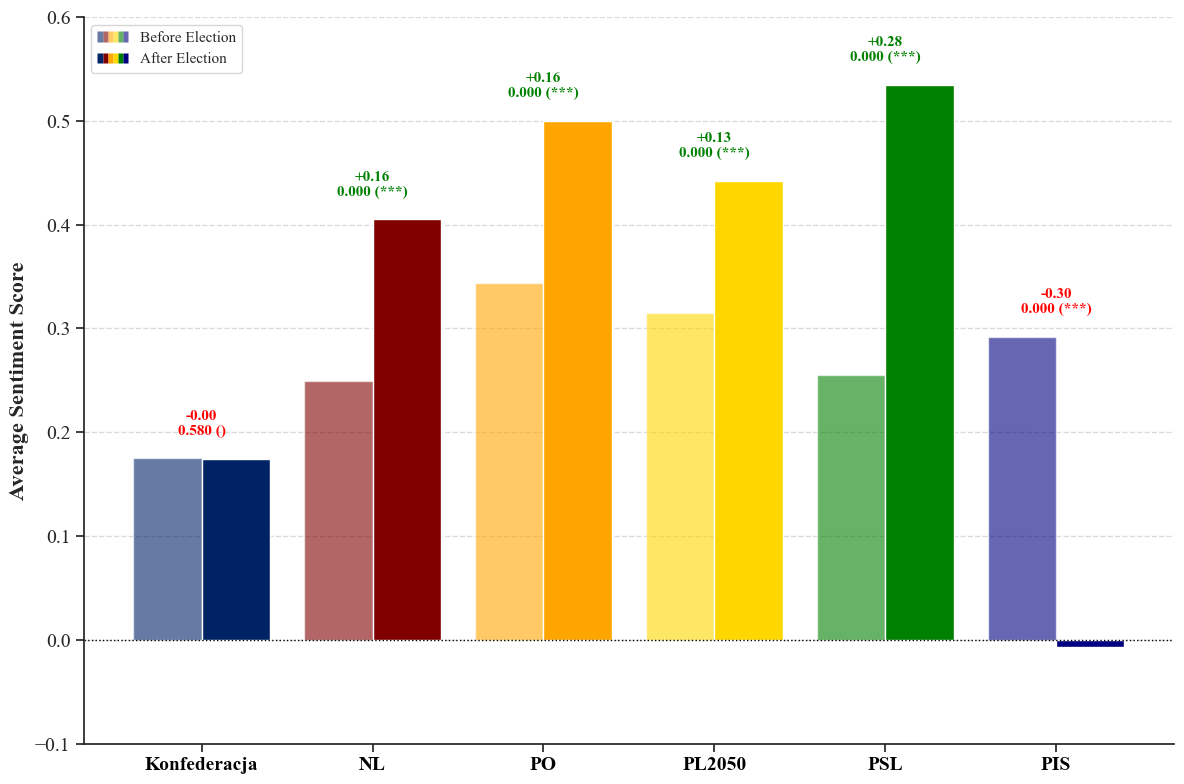

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pathlib import Path
from matplotlib.collections import PatchCollection
import warnings

warnings.filterwarnings('ignore')

# --- Font Configuration ---
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 12

# Define multicolor patch classes for legend
class MulticolorPatch(object):
    def __init__(self, colors):
        self.colors = colors
        
class MulticolorPatchHandler(object):
    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        width, height = handlebox.width, handlebox.height
        patches = []
        for i, c in enumerate(orig_handle.colors):
            patches.append(plt.Rectangle([width/len(orig_handle.colors) * i - handlebox.xdescent, 
                                          -handlebox.ydescent],
                           width / len(orig_handle.colors),
                           height, 
                           facecolor=c, 
                           edgecolor='none'))
        patch = PatchCollection(patches, match_original=True)
        handlebox.add_artist(patch)
        return patch

# --- Setup ---
plots_dir = Path(output_dir) / 'plots'
plots_dir.mkdir(parents=True, exist_ok=True)

DPI_SETTING = 300
font_settings = {
    'label': 16,
    'tick': 14,
    'legend': 14,
    'annotation': 11
}

party_colors = {
    'Konfederacja': '#002366', 'NL': '#800000', 'PL2050': 'gold',
    'PO': 'orange', 'PSL': 'green', 'PIS': 'navy', 'Unknown_Party': 'grey'
}

# Load data
if 'sentiment_score' not in df_for_bert.columns:
    df_for_bert['sentiment_score'] = df_for_bert['positive_bert'] - df_for_bert['negative_bert']
df_for_bert['created_at'] = pd.to_datetime(df_for_bert['created_at'], utc=True)
election_date = pd.to_datetime('2023-10-15', utc=True)
df_before = df_for_bert[df_for_bert['created_at'] < election_date].copy()
df_after = df_for_bert[df_for_bert['created_at'] >= election_date].copy()

# Calculate sentiment change
def calculate_overall_sentiment_change(df_b, df_a):
    if df_b.empty or df_a.empty: return None
    senti_before = df_b.groupby('party')['sentiment_score'].agg(['mean', 'count']).rename(columns={'mean': 'sentiment_before', 'count': 'tweets_before'})
    senti_after = df_a.groupby('party')['sentiment_score'].agg(['mean', 'count']).rename(columns={'mean': 'sentiment_after', 'count': 'tweets_after'})
    comparison_df = pd.concat([senti_before, senti_after], axis=1).fillna(0)
    comparison_df['change'] = comparison_df['sentiment_after'] - comparison_df['sentiment_before']
    p_values = [stats.mannwhitneyu(df_b[df_b['party'] == p]['sentiment_score'], df_a[df_a['party'] == p]['sentiment_score']).pvalue 
                if not df_b[df_b['party'] == p].empty and not df_a[df_a['party'] == p].empty else np.nan 
                for p in comparison_df.index]
    comparison_df['p_value'] = p_values
    return comparison_df

comparison_table = calculate_overall_sentiment_change(df_before, df_after)

if comparison_table is not None:
    print("\n" + "="*80)
    print("Article-Ready Plot: Overall Sentiment Change (No Title)")
    print("="*80 + "\n")
    
    party_order = ['Konfederacja', 'NL', 'PO', 'PL2050', 'PSL', 'PIS']
    plot_df = comparison_table.reindex(party_order).dropna(subset=['sentiment_before'])
    parties = plot_df.index
    x = np.arange(len(parties))
    width = 0.4
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Plot bars with party colors
    ax.bar(x - width/2, plot_df['sentiment_before'], width, 
           color=[party_colors.get(p, 'grey') for p in parties], 
           alpha=0.6)
    ax.bar(x + width/2, plot_df['sentiment_after'], width, 
           color=[party_colors.get(p, 'grey') for p in parties], 
           alpha=1.0)
    
    # Add annotations
    for i, party in enumerate(parties):
        change_val = plot_df.loc[party, 'change']
        p_val = plot_df.loc[party, 'p_value']
        if p_val < 0.001: stars = '(***)'
        elif p_val < 0.01: stars = '(**)'
        elif p_val < 0.05: stars = '(*)'
        else: stars = '()'
        change_text = f'{change_val:+.2f}\n{p_val:.3f} {stars}'
        label_color = 'green' if change_val >= 0 else 'red'
        val_before = plot_df.loc[party, 'sentiment_before']
        val_after = plot_df.loc[party, 'sentiment_after']
        y_pos = max(val_before, val_after) + 0.02
        va = 'bottom'
        ax.text(i, y_pos, change_text, ha='center', color=label_color, 
                fontweight='bold', va=va, fontsize=font_settings['annotation'],
                fontfamily='Times New Roman')
    
    # Formatting
    ax.set_ylabel('Average Sentiment Score', fontsize=font_settings['label'], 
                  fontfamily='Times New Roman', fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(parties, rotation=0, ha='center', fontsize=font_settings['tick'], 
                       fontfamily='Times New Roman', fontweight='bold')
    ax.set_ylim(-0.1, 0.6)
    ax.tick_params(axis='y', labelsize=font_settings['tick'])
    
    # Make x-axis labels BLACK (bold is already set above)
    for tick_label in ax.get_xticklabels():
        tick_label.set_color('black')
    
    # Create multicolor legend with all party colors
    import matplotlib.colors as mcolors
    colors_before_alpha = [mcolors.to_rgba(party_colors.get(p, 'grey'), alpha=0.6) for p in party_order]
    colors_after_alpha = [mcolors.to_rgba(party_colors.get(p, 'grey'), alpha=1.0) for p in party_order]
    
    # Get legend handles
    h = []
    l = []
    h.append(MulticolorPatch(colors_before_alpha))
    l.append("Before Election")
    h.append(MulticolorPatch(colors_after_alpha))
    l.append("After Election")
    
    # Create legend
    legend = ax.legend(h, l, loc='upper left', 
                      handler_map={MulticolorPatch: MulticolorPatchHandler()},
                      fontsize=font_settings['legend'],
                      frameon=True,
                      prop={'family': 'Times New Roman'})
    
    ax.axhline(0, color='black', linewidth=1, linestyle=':')
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    fig.tight_layout()
    
    # Save as both PNG and PDF
    png_path = plots_dir / 'article_sentiment_change_no_title.png'
    pdf_path = plots_dir / 'article_sentiment_change_no_title.pdf'
    plt.savefig(png_path, dpi=DPI_SETTING, bbox_inches='tight')
    plt.savefig(pdf_path, bbox_inches='tight')
    print("Article-ready plot saved:")
    print(f"  PNG: {png_path}")
    print(f"  PDF: {pdf_path}")
    plt.show()
else:
    print("No data to plot.")

##### ARTICLE #2

Theme set to seaborn 'ticks' with Times New Roman.
ANALYSIS 1: Granular Sentiment Change Across Different Time Windows
Directional significance tests complete.

ANALYSIS 2: Time Series Visualizations

--- Generating Combined Sentiment Trend Plot ---
Combined sentiment trend saved as PNG: '..\sentiment_OutputVisualizations\plots\sentiment_trend_combined.png'
Combined sentiment trend saved as PDF: '..\sentiment_OutputVisualizations\plots\sentiment_trend_combined.pdf'


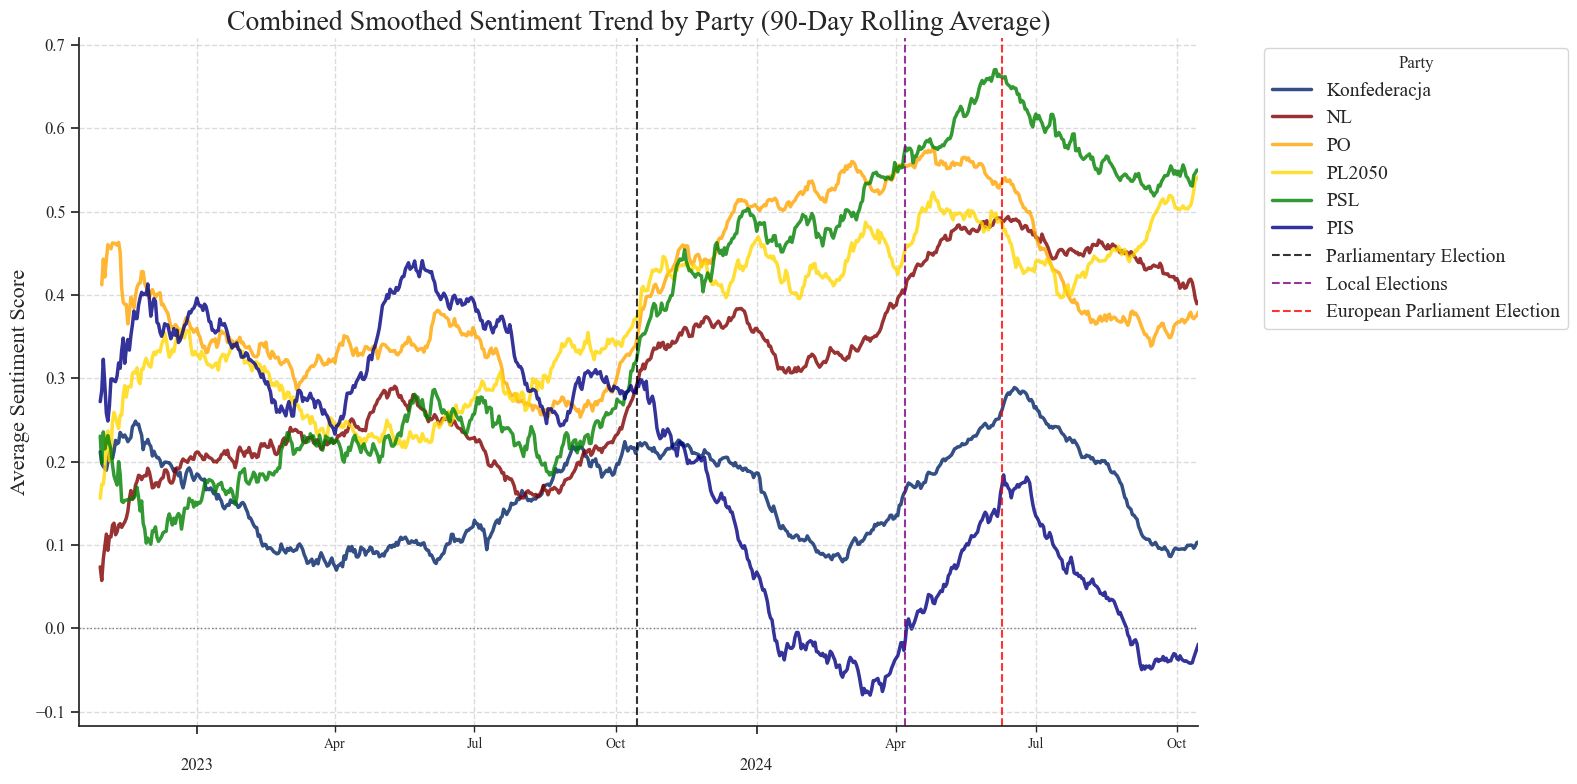


--- Generating Grid of Party Sentiment Trends ---
Grid sentiment trend saved as PNG: '..\sentiment_OutputVisualizations\plots\sentiment_trend_grid.png'
Grid sentiment trend saved as PDF: '..\sentiment_OutputVisualizations\plots\sentiment_trend_grid.pdf'


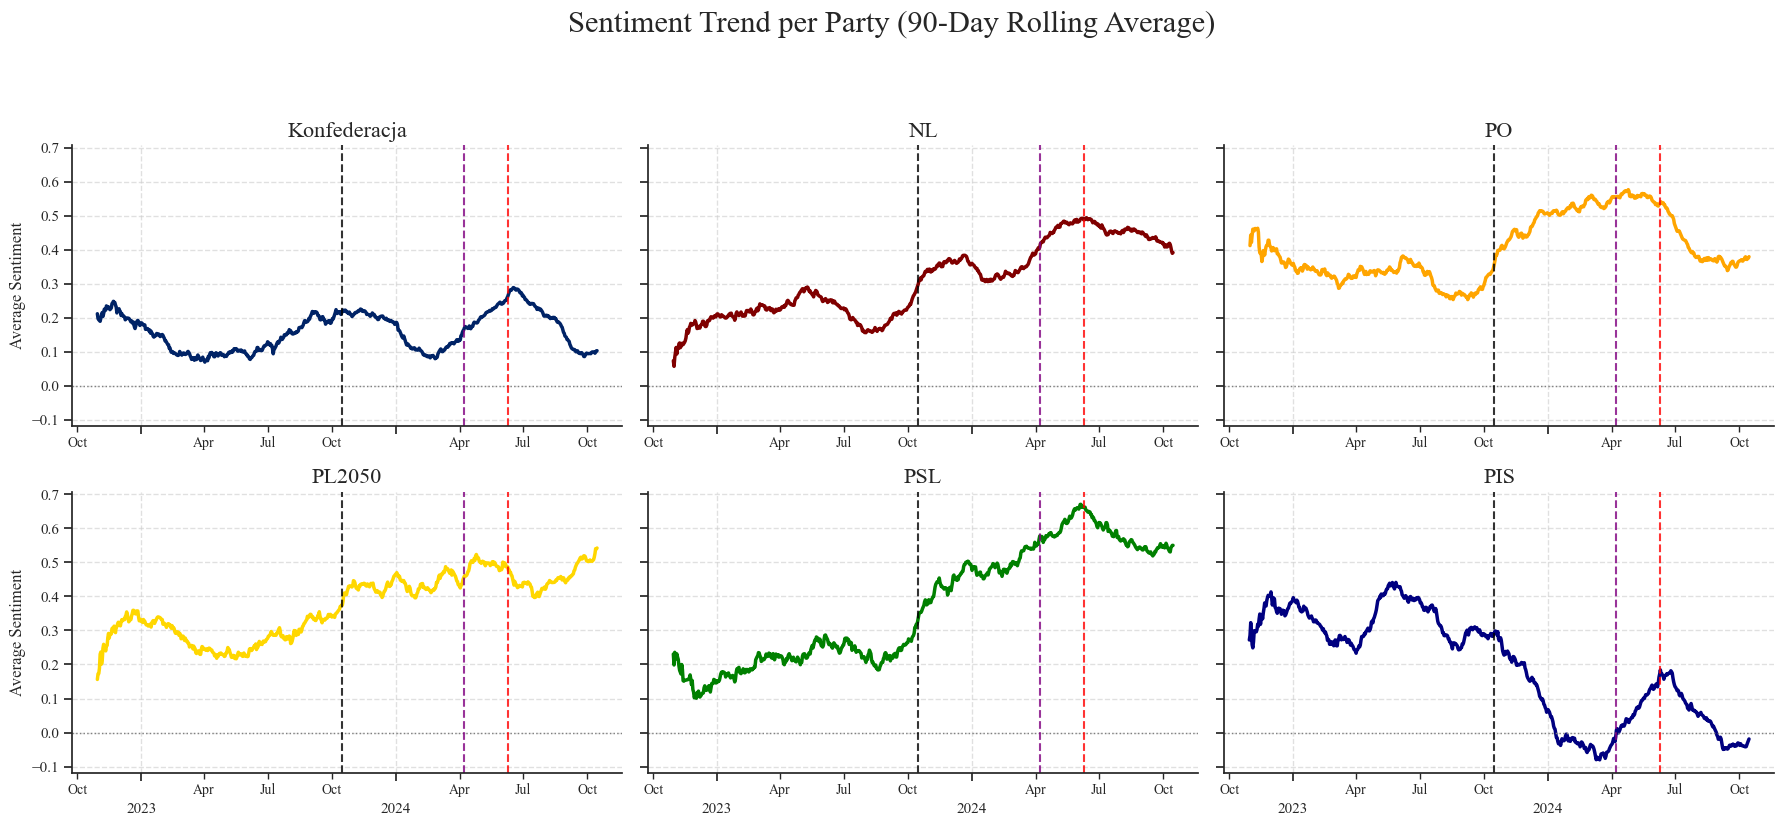


ANALYSIS 3: Significance Analysis Visualizations

--- Generating Heatmap Summary for All Time Windows ---
Heatmap (all windows) saved as PNG: '..\sentiment_OutputVisualizations\plots\heatmap_summary_all_windows_with_pvalues.png'
Heatmap (all windows) saved as PDF: '..\sentiment_OutputVisualizations\plots\heatmap_summary_all_windows_with_pvalues.pdf'


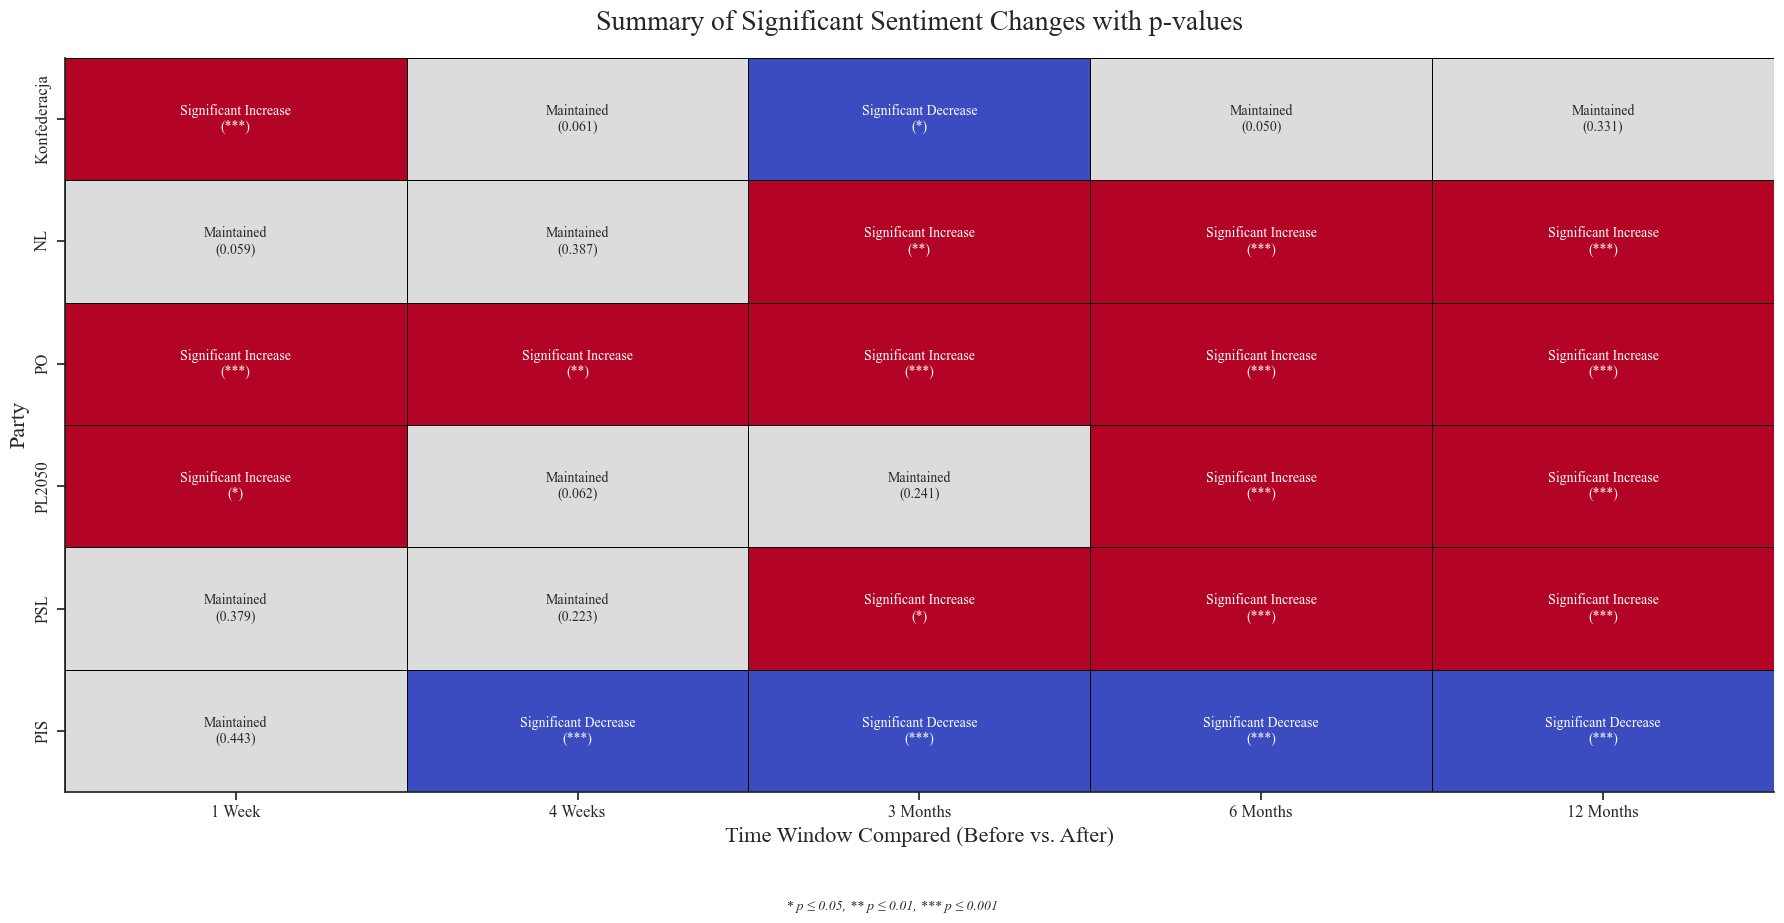


--- Generating Heatmap for 12-Month Window Only ---
Heatmap (12-month) saved as PNG: '..\sentiment_OutputVisualizations\plots\heatmap_summary_12_months_with_pvalues.png'
Heatmap (12-month) saved as PDF: '..\sentiment_OutputVisualizations\plots\heatmap_summary_12_months_with_pvalues.pdf'


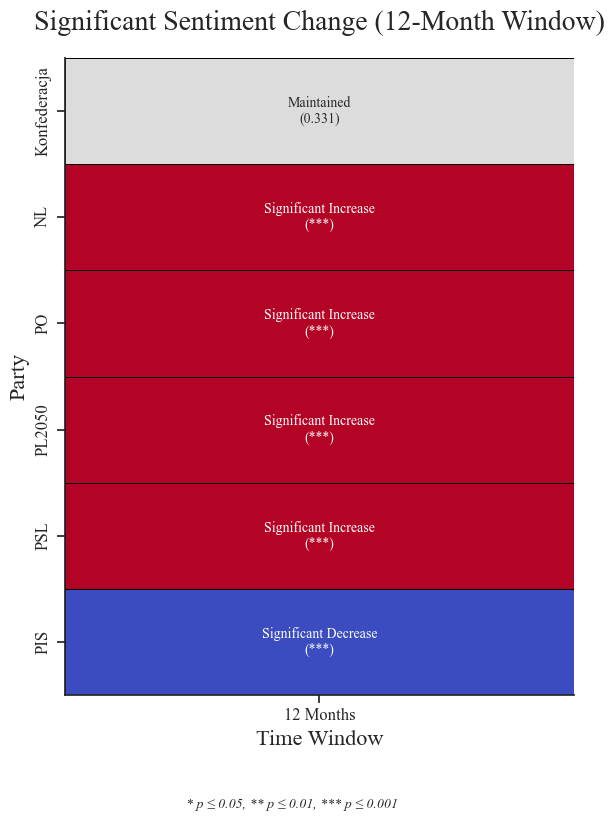


--- Generating Annotated Bar Chart for 12-Month Change ---
Bar chart saved as PNG: '..\sentiment_OutputVisualizations\plots\annotated_barchart_12_month_change.png'
Bar chart saved as PDF: '..\sentiment_OutputVisualizations\plots\annotated_barchart_12_month_change.pdf'


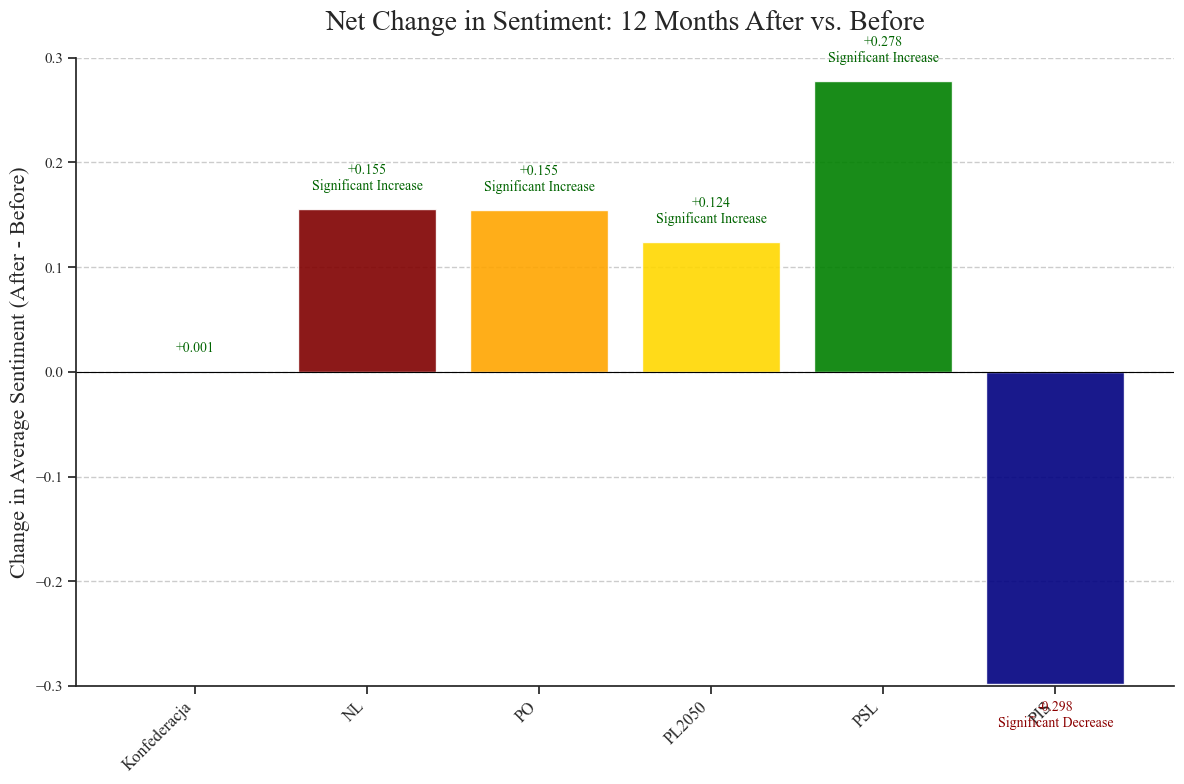


All analyses are complete. Plots have been saved to '..\sentiment_OutputVisualizations\plots/'


In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy import stats
from datetime import timedelta, timezone
from IPython.display import display
from pathlib import Path
import warnings

warnings.filterwarnings('ignore')

# --- Font Configuration ---
try:
    sns.set_theme(
        style="ticks",
        font="Times New Roman",
        rc={
            "font.weight": "normal",
            "axes.labelweight": "normal",
            "axes.titleweight": "normal"
        }
    )
    print("Theme set to seaborn 'ticks' with Times New Roman.")
except RuntimeError:
    sns.set_theme(style="ticks")
    print("Warning: Times New Roman not found. Using seaborn 'ticks' style with default font.")

# --- Create output subfolder ---
plots_dir = Path(output_dir) / 'plots'
plots_dir.mkdir(parents=True, exist_ok=True)

# --- 0. Setup ---
font_settings = {
    'title': 20, 'suptitle': 22, 'label': 16,
    'tick': 12, 'legend': 14, 'annotation': 10, 'footnote': 10
}
key_dates = {
    "Parliamentary Election": ('2023-10-15', 'black', '--'),
    "Local Elections": ('2024-04-07', 'purple', '--'),
    "European Parliament Election": ('2024-06-09', 'red', '--')
}
party_colors = {
    'Konfederacja': '#002366', 'NL': '#800000', 'PL2050': 'gold',
    'PO': 'orange', 'PSL': 'green', 'PIS': 'navy', 'Unknown_Party': 'grey'
}
party_order = ['Konfederacja', 'NL', 'PO', 'PL2050', 'PSL', 'PIS']

# ASSUMPTION: Your DataFrame 'df_for_bert' is loaded.
if 'df_for_bert' not in locals():
    raise NameError("Ensure 'df_for_bert' is defined before running this script.")

election_date = pd.to_datetime('2023-10-15', utc=True)

# --- 1. Granular Multi-Interval Sentiment Analysis ---
print("="*80 + "\nANALYSIS 1: Granular Sentiment Change Across Different Time Windows\n" + "="*80)
intervals = {'1 Week': 7, '4 Weeks': 28, '3 Months': 91, '6 Months': 182, '12 Months': 365}
all_results = []
directional_test_results = []
for label, days in intervals.items():
    before_start, after_end = election_date - timedelta(days=days), election_date + timedelta(days=days)
    df_b_interval = df_for_bert[(df_for_bert['created_at'] >= before_start) & (df_for_bert['created_at'] < election_date)]
    df_a_interval = df_for_bert[(df_for_bert['created_at'] >= election_date) & (df_for_bert['created_at'] < after_end)]
    for party in party_order:
        before_scores, after_scores = df_b_interval[df_b_interval['party'] == party]['sentiment_score'].dropna(), df_a_interval[df_a_interval['party'] == party]['sentiment_score'].dropna()
        if not before_scores.empty and not after_scores.empty:
            mean_before, mean_after = before_scores.mean(), after_scores.mean()
            all_results.append({'Party': party, 'Time Window': label, 'Sentiment Before': mean_before, 'Sentiment After': mean_after, 'Change': mean_after - mean_before})
            p_increase, p_decrease = stats.mannwhitneyu(before_scores, after_scores, alternative='less').pvalue, stats.mannwhitneyu(before_scores, after_scores, alternative='greater').pvalue
            direction = "Maintained"
            if p_increase < 0.05: direction = "Significant Increase"
            elif p_decrease < 0.05: direction = "Significant Decrease"
            directional_test_results.append({'Party': party, 'Time Window': label, 'P-Value (Increase)': p_increase, 'P-Value (Decrease)': p_decrease, 'Significant Direction': direction})
final_comparison_table, directional_stats_df = pd.DataFrame(all_results), pd.DataFrame(directional_test_results)
print("Directional significance tests complete.")

# --- 2. Time Series Visualizations ---
print("\n" + "="*80 + "\nANALYSIS 2: Time Series Visualizations\n" + "="*80)
def format_date_axis(ax):
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('\n%Y'))
    ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=[1, 4, 7, 10]))
    ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))
    ax.tick_params(axis='x', which='minor', labelsize=font_settings['tick'] - 2)

def add_event_lines(ax, dates_dict):
    for event, (date, color, style) in dates_dict.items():
        ax.axvline(pd.to_datetime(date, utc=True), color=color, linestyle=style, linewidth=1.5, label=event, alpha=0.8)

print("\n--- Generating Combined Sentiment Trend Plot ---")
fig, ax = plt.subplots(figsize=(16, 8))
for party in party_order:
    party_df = df_for_bert[df_for_bert['party'] == party]
    if not party_df.empty:
        party_df.set_index('created_at')['sentiment_score'].resample('D').mean().rolling(window=90, min_periods=15).mean().plot(
            label=party, color=party_colors.get(party, 'grey'), ax=ax, linewidth=2.5, alpha=0.8)
add_event_lines(ax, key_dates)
ax.axhline(0, color='grey', linewidth=1, linestyle=':')
ax.set_title('Combined Smoothed Sentiment Trend by Party (90-Day Rolling Average)', fontsize=font_settings['title'])
ax.set_xlabel(None)
ax.set_ylabel('Average Sentiment Score', fontsize=font_settings['label'])
ax.tick_params(axis='both', labelsize=font_settings['tick'])
ax.grid(True, which='both', linestyle='--', alpha=0.7)
format_date_axis(ax)
ax.legend(title='Party', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=font_settings['legend'])
sns.despine()
plt.tight_layout()

# Save combined sentiment trend
combined_png = plots_dir / 'sentiment_trend_combined.png'
combined_pdf = plots_dir / 'sentiment_trend_combined.pdf'
plt.savefig(combined_png, dpi=300, bbox_inches='tight')
plt.savefig(combined_pdf, bbox_inches='tight')
print(f"Combined sentiment trend saved as PNG: '{combined_png}'")
print(f"Combined sentiment trend saved as PDF: '{combined_pdf}'")
plt.show()

print("\n--- Generating Grid of Party Sentiment Trends ---")
df_resampled = df_for_bert.groupby('party').resample('D', on='created_at')[['sentiment_score']].mean().reset_index()
df_resampled['rolling_sentiment'] = df_resampled.groupby('party')['sentiment_score'].transform(lambda x: x.rolling(window=90, min_periods=15).mean())
g = sns.FacetGrid(df_resampled, col="party", col_wrap=3, hue="party", palette=party_colors, col_order=party_order, height=4, aspect=1.5)
g.map(sns.lineplot, "created_at", "rolling_sentiment", lw=2.5)
g.map(plt.axhline, y=0, color='grey', linestyle=':', lw=1)
for ax in g.axes.flat:
    format_date_axis(ax)
    ax.grid(True, linestyle='--', alpha=0.6)
    add_event_lines(ax, key_dates)
g.set_titles("{col_name}", size=font_settings['label'])
g.set_axis_labels("", "Average Sentiment")
g.fig.suptitle('Sentiment Trend per Party (90-Day Rolling Average)', fontsize=font_settings['suptitle'], y=1.03)
sns.despine()
plt.tight_layout(rect=[0, 0, 1, 0.97])

# Save grid sentiment trend
grid_png = plots_dir / 'sentiment_trend_grid.png'
grid_pdf = plots_dir / 'sentiment_trend_grid.pdf'
plt.savefig(grid_png, dpi=300, bbox_inches='tight')
plt.savefig(grid_pdf, bbox_inches='tight')
print(f"Grid sentiment trend saved as PNG: '{grid_png}'")
print(f"Grid sentiment trend saved as PDF: '{grid_pdf}'")
plt.show()

# --- 3. Significance Analysis Visualizations ---
print("\n" + "="*80 + "\nANALYSIS 3: Significance Analysis Visualizations\n" + "="*80)
if not directional_stats_df.empty:
    def format_annotation(row):
        direction = row['Significant Direction']
        if direction == 'Significant Increase': p_val = row['P-Value (Increase)']
        elif direction == 'Significant Decrease': p_val = row['P-Value (Decrease)']
        else: p_val = min(row['P-Value (Increase)'], row['P-Value (Decrease)'])
        if p_val <= 0.001: p_text = '(***)'
        elif p_val <= 0.01: p_text = '(**)'
        elif p_val <= 0.05: p_text = '(*)'
        else: p_text = f'({p_val:.3f})'
        return f"{direction}\n{p_text}"
    
    directional_stats_df['heatmap_annotation'] = directional_stats_df.apply(format_annotation, axis=1)
    direction_map = {"Significant Increase": 1, "Maintained": 0, "Significant Decrease": -1}
    
    print("\n--- Generating Heatmap Summary for All Time Windows ---")
    heatmap_data = directional_stats_df.copy()
    heatmap_data['direction_code'] = heatmap_data['Significant Direction'].map(direction_map)
    heatmap_pivot = heatmap_data.pivot_table(index='Party', columns='Time Window', values='direction_code')
    annot_pivot_text = heatmap_data.pivot_table(index='Party', columns='Time Window', values='heatmap_annotation', aggfunc='first')
    time_window_order = ['1 Week', '4 Weeks', '3 Months', '6 Months', '12 Months']
    heatmap_pivot = heatmap_pivot.reindex(columns=time_window_order, level=0).reindex(index=party_order)
    annot_pivot_text = annot_pivot_text.reindex(columns=time_window_order, level=0).reindex(index=party_order)
    
    plt.figure(figsize=(18, 9))
    sns.heatmap(heatmap_pivot, annot=annot_pivot_text, fmt="", cmap="coolwarm", center=0, linewidths=.5, 
                linecolor='black', cbar=False, annot_kws={"size": font_settings['annotation']})
    plt.title('Summary of Significant Sentiment Changes with p-values', fontsize=font_settings['title'], pad=20)
    plt.xlabel('Time Window Compared (Before vs. After)', fontsize=font_settings['label'])
    plt.ylabel('Party', fontsize=font_settings['label'])
    plt.tick_params(axis='both', labelsize=font_settings['tick'])
    plt.figtext(0.5, -0.02, '* p ≤ 0.05, ** p ≤ 0.01, *** p ≤ 0.001', ha="center", 
                fontsize=font_settings['footnote'], style='italic')
    sns.despine()
    plt.tight_layout(rect=[0, 0.03, 1, 1])
    
    # Save heatmap all windows
    heatmap_all_png = plots_dir / 'heatmap_summary_all_windows_with_pvalues.png'
    heatmap_all_pdf = plots_dir / 'heatmap_summary_all_windows_with_pvalues.pdf'
    plt.savefig(heatmap_all_png, dpi=300, bbox_inches='tight')
    plt.savefig(heatmap_all_pdf, bbox_inches='tight')
    print(f"Heatmap (all windows) saved as PNG: '{heatmap_all_png}'")
    print(f"Heatmap (all windows) saved as PDF: '{heatmap_all_pdf}'")
    plt.show()
    
    print("\n--- Generating Heatmap for 12-Month Window Only ---")
    df_12m_sig = directional_stats_df[directional_stats_df['Time Window'] == '12 Months'].copy()
    df_12m_sig['direction_code'] = df_12m_sig['Significant Direction'].map(direction_map)
    heatmap_pivot_12m = df_12m_sig.pivot_table(index='Party', columns='Time Window', values='direction_code').reindex(index=party_order)
    annot_pivot_12m = df_12m_sig.pivot_table(index='Party', columns='Time Window', values='heatmap_annotation', aggfunc='first').reindex(index=party_order)
    
    plt.figure(figsize=(6, 8))
    sns.heatmap(heatmap_pivot_12m, annot=annot_pivot_12m, fmt="", cmap="coolwarm", center=0, linewidths=.5, 
                linecolor='black', cbar=False, annot_kws={"size": font_settings['annotation']})
    plt.title('Significant Sentiment Change (12-Month Window)', fontsize=font_settings['title'], pad=20)
    plt.xlabel('Time Window', fontsize=font_settings['label'])
    plt.ylabel('Party', fontsize=font_settings['label'])
    plt.tick_params(axis='both', labelsize=font_settings['tick'])
    plt.figtext(0.5, -0.02, '* p ≤ 0.05, ** p ≤ 0.01, *** p ≤ 0.001', ha="center", 
                fontsize=font_settings['footnote'], style='italic')
    sns.despine()
    plt.tight_layout(rect=[0, 0.03, 1, 1])
    
    # Save 12-month heatmap
    heatmap_12m_png = plots_dir / 'heatmap_summary_12_months_with_pvalues.png'
    heatmap_12m_pdf = plots_dir / 'heatmap_summary_12_months_with_pvalues.pdf'
    plt.savefig(heatmap_12m_png, dpi=300, bbox_inches='tight')
    plt.savefig(heatmap_12m_pdf, bbox_inches='tight')
    print(f"Heatmap (12-month) saved as PNG: '{heatmap_12m_png}'")
    print(f"Heatmap (12-month) saved as PDF: '{heatmap_12m_pdf}'")
    plt.show()

    print("\n--- Generating Annotated Bar Chart for 12-Month Change ---")
    df_12m_full = final_comparison_table[final_comparison_table['Time Window'] == '12 Months'].set_index('Party')
    df_12m_sig_info = directional_stats_df[directional_stats_df['Time Window'] == '12 Months'].set_index('Party')
    df_12m_full = df_12m_full.join(df_12m_sig_info.drop('Time Window', axis=1))
    
    if not df_12m_full.empty:
        df_sorted = df_12m_full.reindex(party_order).dropna()
        plt.figure(figsize=(12, 8))
        bar_colors = [party_colors.get(p, 'grey') for p in df_sorted.index]
        bars = plt.bar(df_sorted.index, df_sorted['Change'], color=bar_colors, alpha=0.9)
        plt.axhline(0, color='black', linewidth=0.8)
        plt.ylabel('Change in Average Sentiment (After - Before)', fontsize=font_settings['label'])
        plt.title('Net Change in Sentiment: 12 Months After vs. Before', fontsize=font_settings['title'], pad=20)
        plt.xticks(rotation=45, ha='right', fontsize=font_settings['tick'])
        plt.ylim(-0.3, 0.3)
        
        for i, party in enumerate(df_sorted.index):
            row = df_sorted.loc[party]
            y_val = row['Change']
            label_text = f"{y_val:+.3f}"
            if row['Significant Direction'] != 'Maintained':
                label_text += f"\n{row['Significant Direction']}"
            text_color = 'darkgreen' if y_val > 0 else 'darkred'
            vertical_offset = y_val + (0.015 if y_val > 0 else -0.015)
            plt.text(i, vertical_offset, label_text, ha='center', va='bottom' if y_val > 0 else 'top', 
                    fontsize=font_settings['annotation'], color=text_color, 
                    bbox=dict(facecolor='white', alpha=0.0, edgecolor='none'))
        
        plt.grid(axis='y', linestyle='--')
        sns.despine()
        plt.tight_layout()
        
        # Save bar chart
        bar_png = plots_dir / 'annotated_barchart_12_month_change.png'
        bar_pdf = plots_dir / 'annotated_barchart_12_month_change.pdf'
        plt.savefig(bar_png, dpi=300, bbox_inches='tight')
        plt.savefig(bar_pdf, bbox_inches='tight')
        print(f"Bar chart saved as PNG: '{bar_png}'")
        print(f"Bar chart saved as PDF: '{bar_pdf}'")
        plt.show()
else:
    print("Significance tables not generated, skipping visualizations.")

print("\n" + "="*80)
print(f"All analyses are complete. Plots have been saved to '{plots_dir}/'")
print("="*80)


--- Generating Grid of Party Sentiment Trends ---
Grid sentiment trend saved as PNG: '..\sentiment_OutputVisualizations\plots\sentiment_trend_grid.png'
Grid sentiment trend saved as PDF: '..\sentiment_OutputVisualizations\plots\sentiment_trend_grid.pdf'


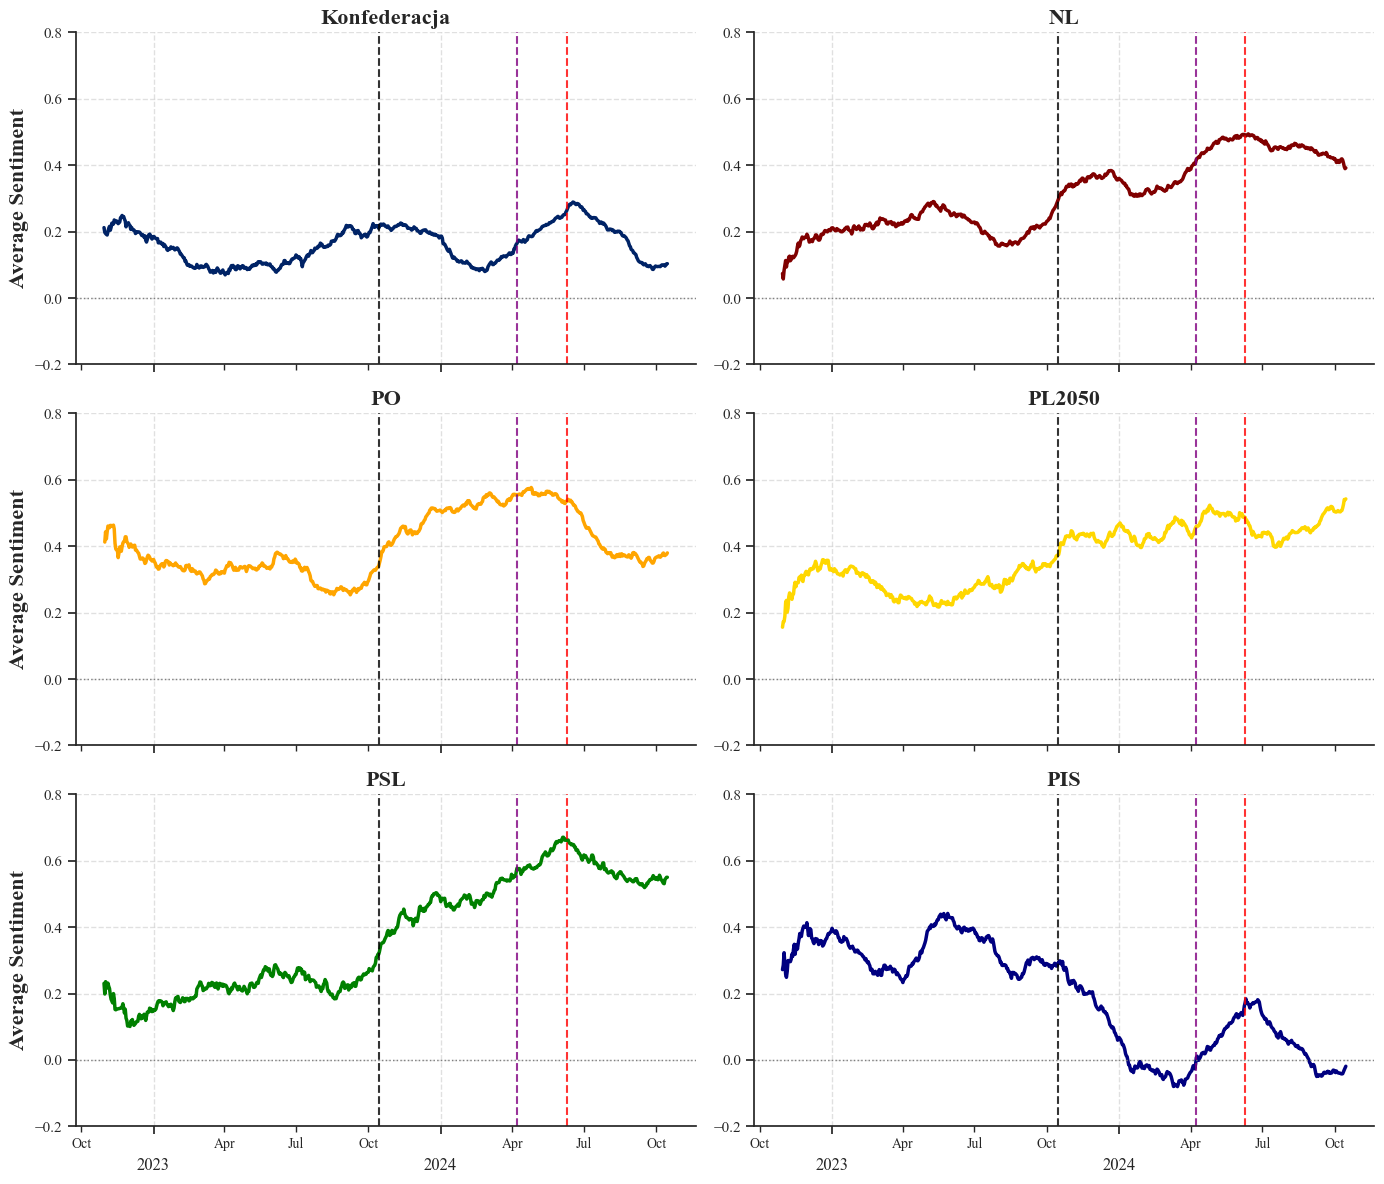


Plot generation complete.


In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from pathlib import Path
import warnings

warnings.filterwarnings('ignore')

# --- Font Configuration ---
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 12

# --- Create output subfolder ---
plots_dir = Path(output_dir) / 'plots'
plots_dir.mkdir(parents=True, exist_ok=True)

# --- Setup ---
font_settings = {
    'title': 20, 'suptitle': 22, 'label': 16,
    'tick': 12, 'legend': 14, 'annotation': 10, 'footnote': 10
}

key_dates = {
    "Parliamentary Election": ('2023-10-15', 'black', '--'),
    "Local Elections": ('2024-04-07', 'purple', '--'),
    "European Parliament Election": ('2024-06-09', 'red', '--')
}

party_colors = {
    'Konfederacja': '#002366', 'NL': '#800000', 'PL2050': 'gold',
    'PO': 'orange', 'PSL': 'green', 'PIS': 'navy', 'Unknown_Party': 'grey'
}

party_order = ['Konfederacja', 'NL', 'PO', 'PL2050', 'PSL', 'PIS']

# --- Helper Functions ---
def format_date_axis(ax):
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('\n%Y'))
    ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=[1, 4, 7, 10]))
    ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))
    ax.tick_params(axis='x', which='minor', labelsize=font_settings['tick'] - 2)
    ax.tick_params(axis='x', which='major', labelsize=font_settings['tick'])

def add_event_lines(ax, dates_dict):
    for event, (date, color, style) in dates_dict.items():
        ax.axvline(pd.to_datetime(date, utc=True), color=color, linestyle=style, linewidth=1.5, alpha=0.8)

# --- Prepare Data ---
df_resampled = df_for_bert.groupby('party').resample('D', on='created_at')[['sentiment_score']].mean().reset_index()
df_resampled['rolling_sentiment'] = df_resampled.groupby('party')['sentiment_score'].transform(
    lambda x: x.rolling(window=90, min_periods=15).mean()
)

# --- Generate Grid of Party Sentiment Trends (3 rows x 2 columns) ---
print("\n--- Generating Grid of Party Sentiment Trends ---")

# DO NOT USE sharey=True - we will set it manually
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 12), sharex=True)
axes = axes.flatten()

for idx, party in enumerate(party_order):
    ax = axes[idx]
    party_data = df_resampled[df_resampled['party'] == party]
    
    if not party_data.empty:
        ax.plot(party_data['created_at'], party_data['rolling_sentiment'], 
                color=party_colors.get(party, 'grey'), linewidth=2.5)
    
    # Add horizontal line at 0
    ax.axhline(0, color='grey', linestyle=':', linewidth=1)
    
    # Add event lines
    add_event_lines(ax, key_dates)
    
    # Set party name as title (BOLD)
    ax.set_title(party, fontsize=font_settings['label'], fontweight='bold', fontfamily='Times New Roman')
    
    # Grid
    ax.grid(True, linestyle='--', alpha=0.6)
    
    # Format date axis
    format_date_axis(ax)
    
    # ============================================
    # SET Y-AXIS LIMITS FOR EACH SUBPLOT
    # ============================================
    ax.set_ylim(-0.2, 0.8)  # Adjusted range to fit all data
    
    # Y-axis label only for leftmost plots
    if idx % 2 == 0:
        ax.set_ylabel('Average Sentiment', fontsize=font_settings['label'], 
                      fontweight='bold', fontfamily='Times New Roman')

# Remove x-axis label (dates are self-explanatory)
for ax in axes:
    ax.set_xlabel('')

# Remove top and right spines for all subplots
for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Adjust layout
plt.tight_layout()

# Save grid sentiment trend
grid_png = plots_dir / 'sentiment_trend_grid.png'
grid_pdf = plots_dir / 'sentiment_trend_grid.pdf'
plt.savefig(grid_png, dpi=300, bbox_inches='tight')
plt.savefig(grid_pdf, bbox_inches='tight')
print(f"Grid sentiment trend saved as PNG: '{grid_png}'")
print(f"Grid sentiment trend saved as PDF: '{grid_pdf}'")
plt.show()

print("\nPlot generation complete.")

##### END

################################################################################
# STEP 1: SENTIMENT & RELATIVE VIRALITY CALCULATION
################################################################################
Data preparation complete.

################################################################################
# STEP 2: FITTING STATISTICAL MODELS
################################################################################

--- Fitting models for: Impression Count ---
  > Model A fitted successfully.
  > Model B fitted successfully.

--- Fitting models for: Like Count ---


d:\Python_env\Twitter\.venv_twitter\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


  > Model A fitted successfully.


d:\Python_env\Twitter\.venv_twitter\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


  > Model B fitted successfully.

--- Fitting models for: Retweet Count ---
  > Model A fitted successfully.
  > Model B fitted successfully.

--- Fitting models for: Reply Count ---
  > Model A fitted successfully.
  > Model B fitted successfully.

################################################################################
# STEP 2.5: KRUSKAL-WALLIS TESTS
################################################################################

--- Kruskal-Wallis H Test for: Impression Count ---
  > H-statistic: 684.56
  > P-value: 7.674e-147
  > Result: Significant difference detected across sentiment groups.

--- Kruskal-Wallis H Test for: Like Count ---
  > H-statistic: 1401.98
  > P-value: 2.567e-302
  > Result: Significant difference detected across sentiment groups.

--- Kruskal-Wallis H Test for: Retweet Count ---
  > H-statistic: 1593.42
  > P-value: 0.000e+00
  > Result: Significant difference detected across sentiment groups.

--- Kruskal-Wallis H Test for: Reply Count ---
  > H

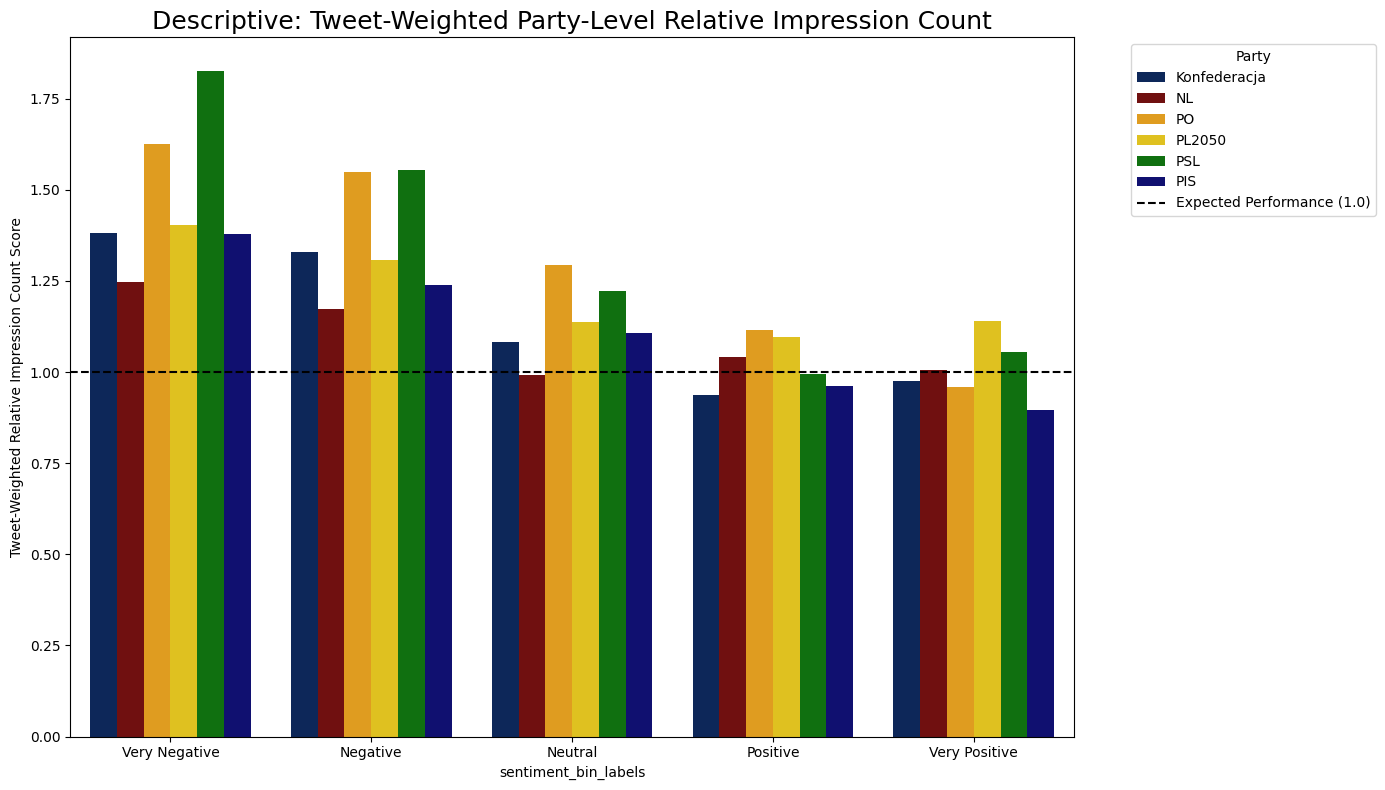

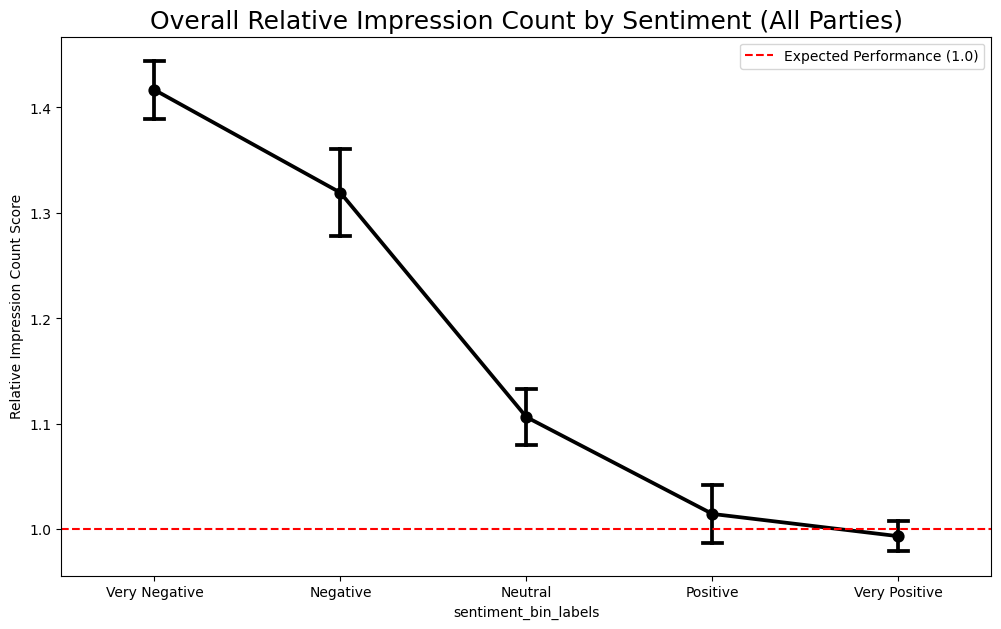

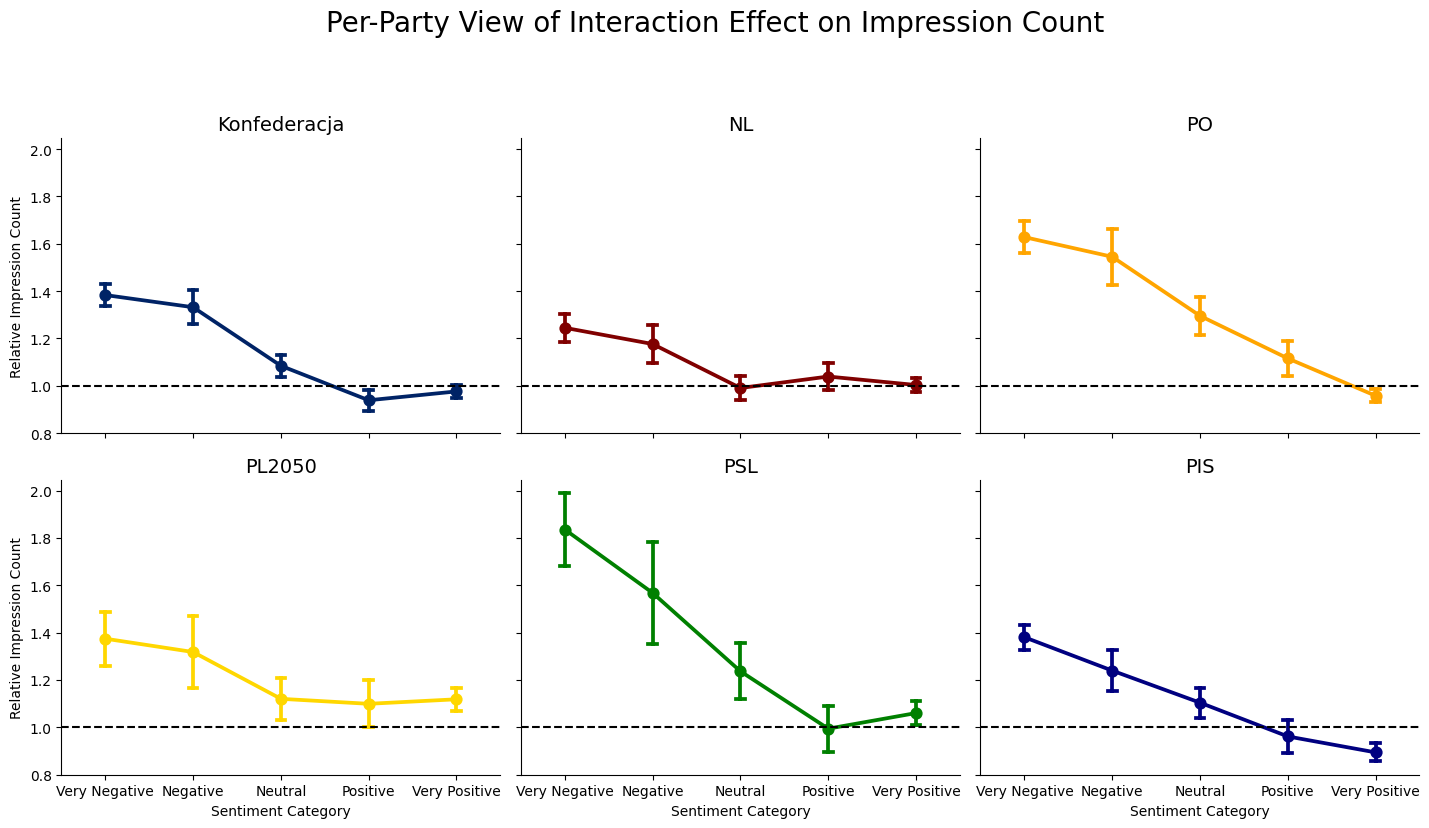


--- Generating plots for: Like Count ---


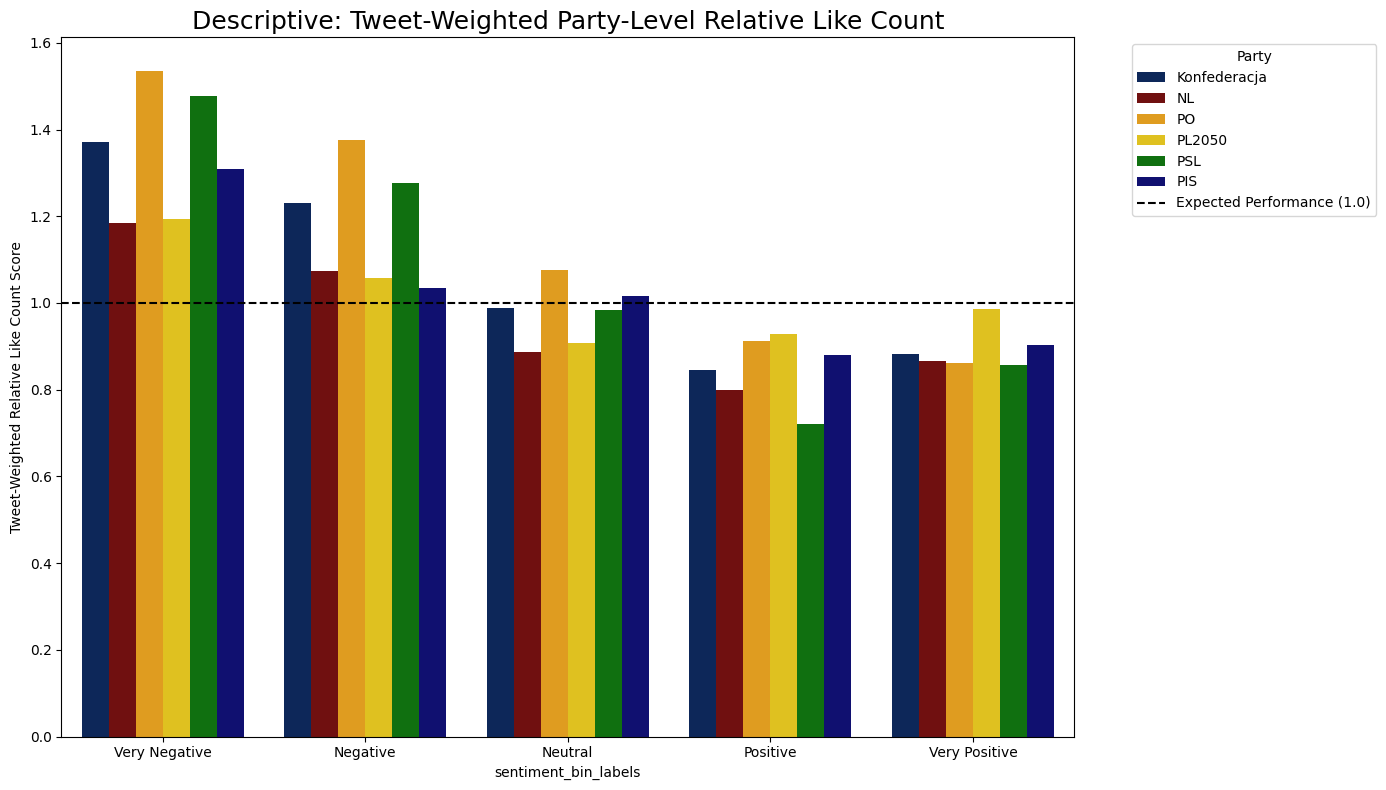

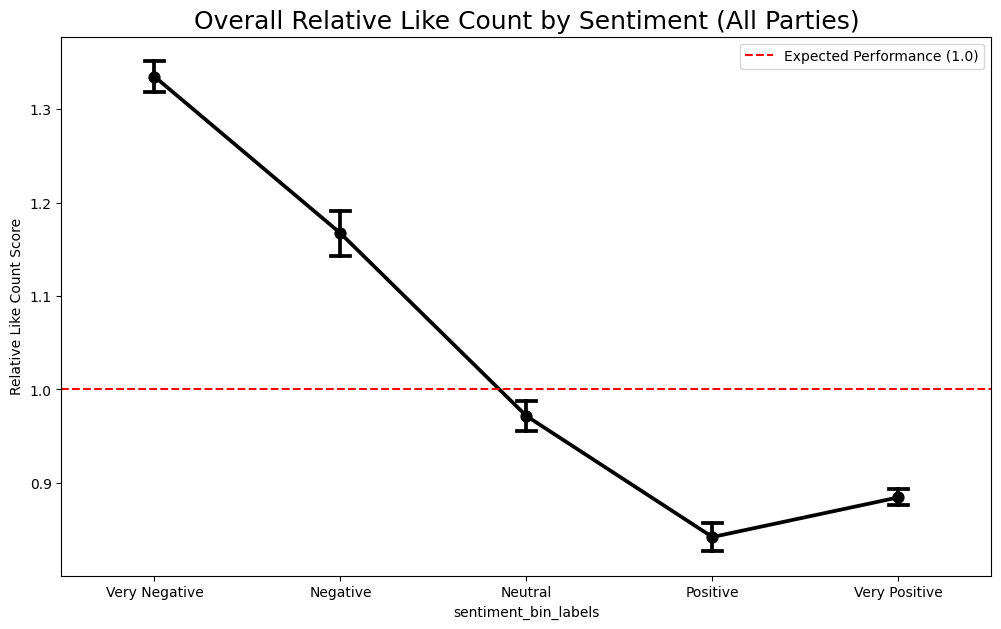

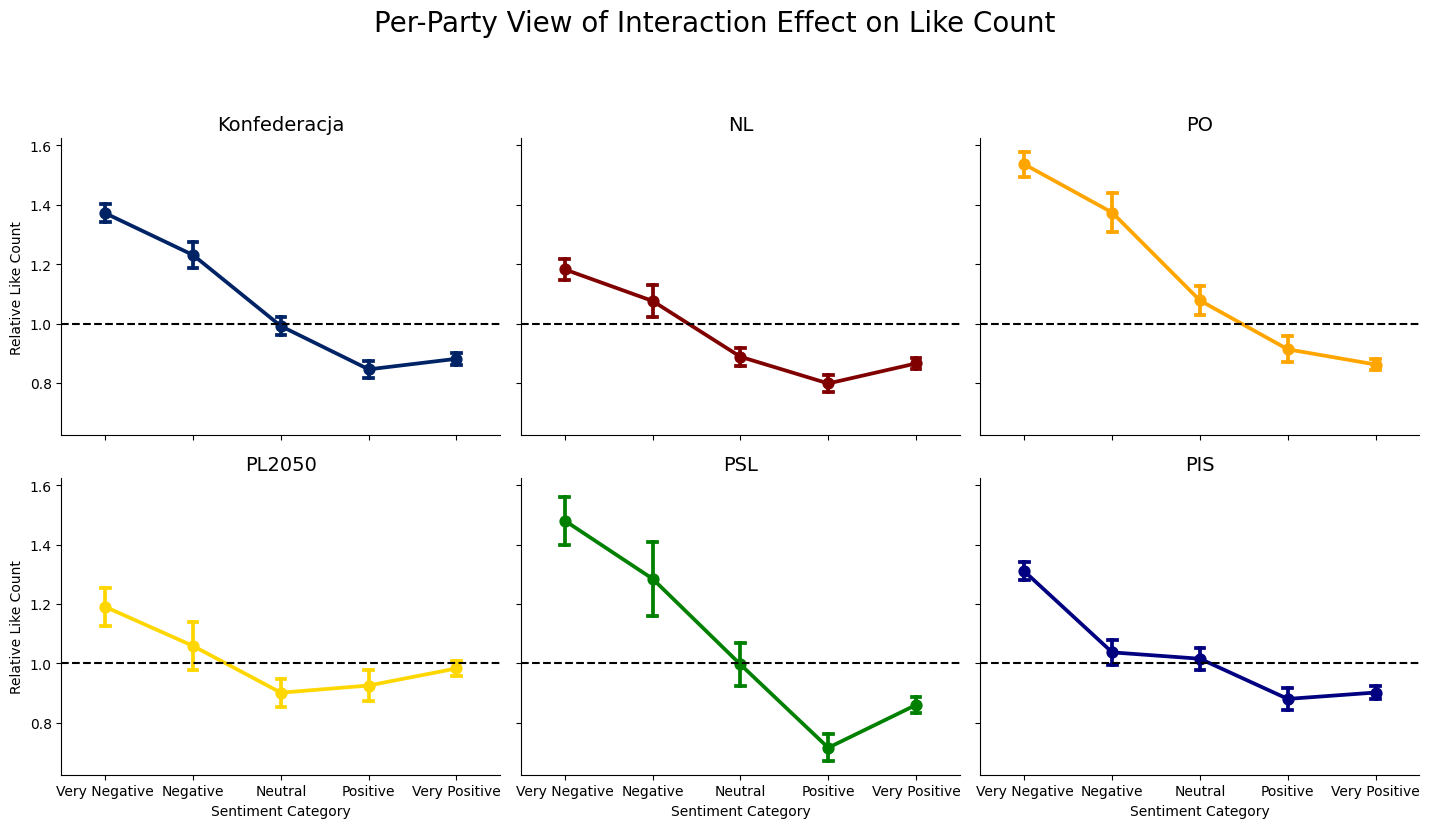


--- Generating plots for: Retweet Count ---


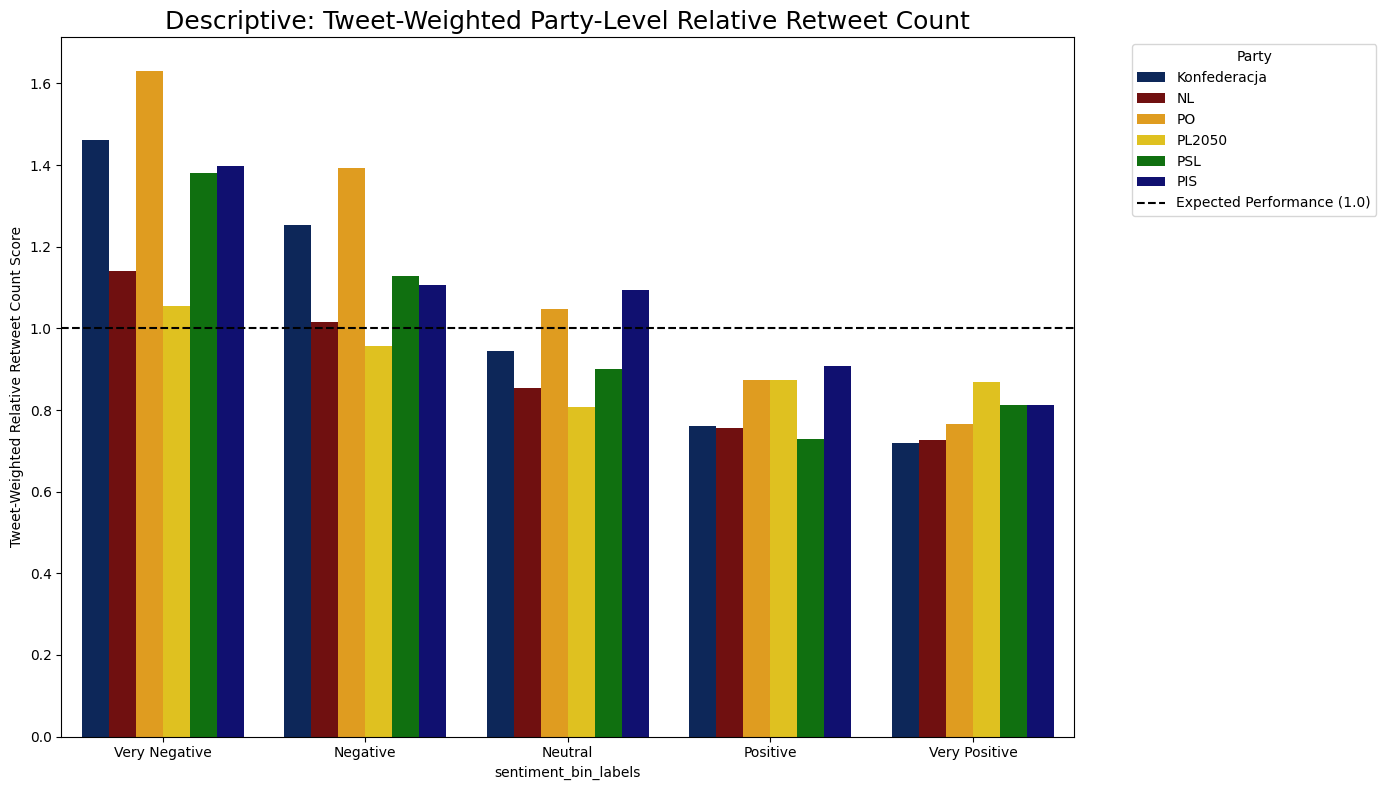

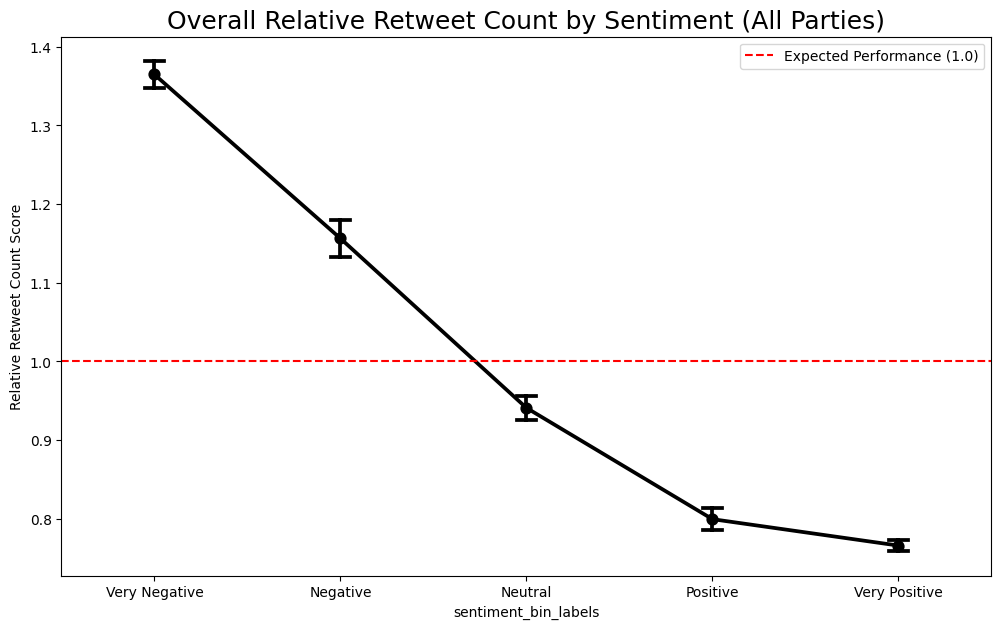

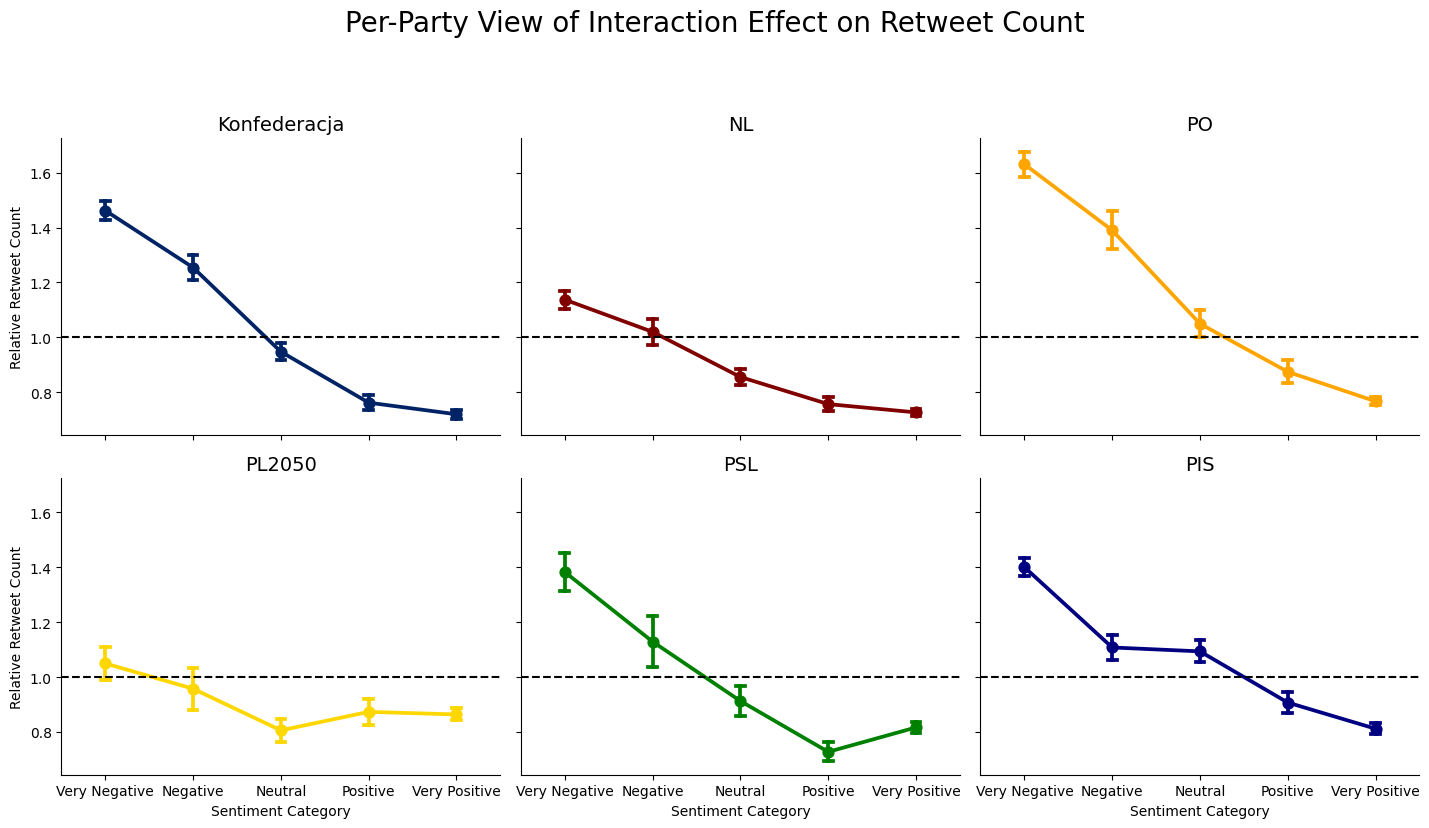


--- Generating plots for: Reply Count ---


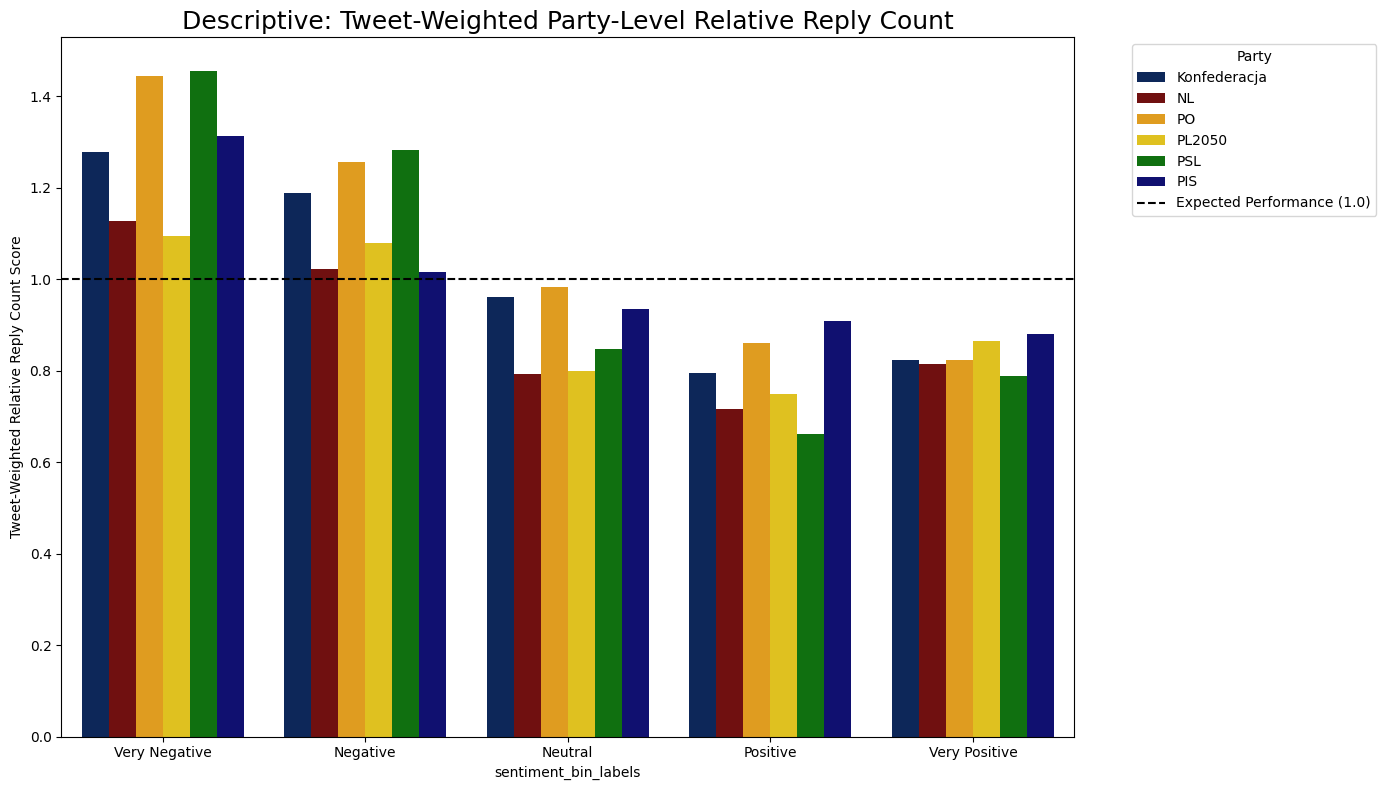

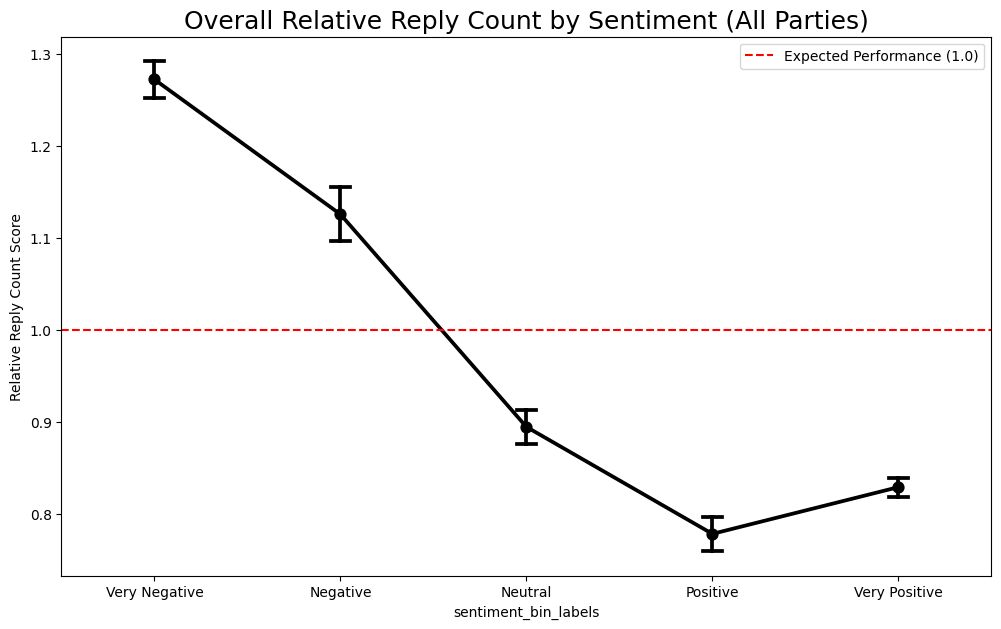

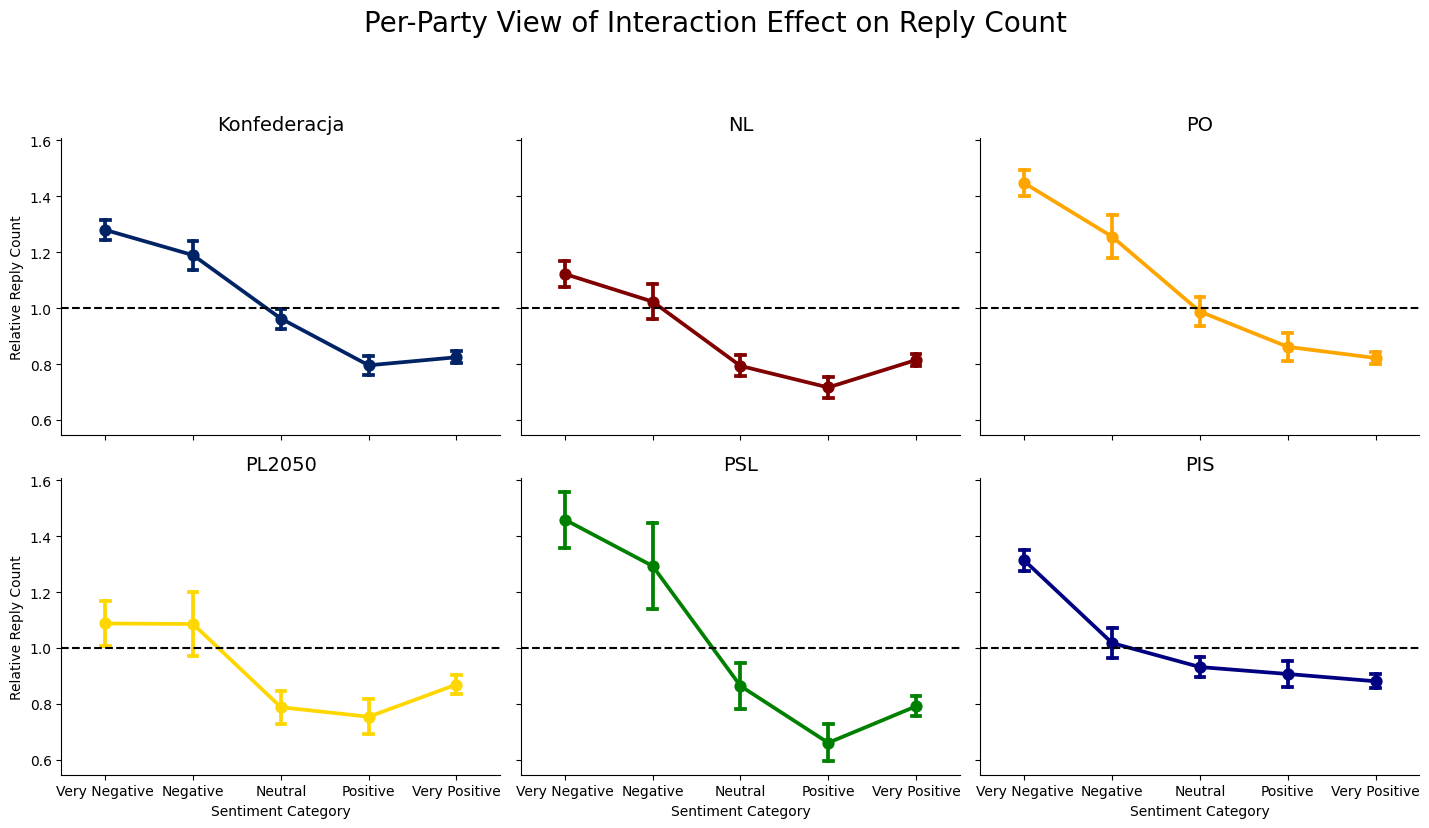

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from scipy.stats import kruskal
import statsmodels.formula.api as smf
import warnings

# --- 0. Setup and Data Loading ---
warnings.filterwarnings('ignore', 'The optimizer did not converge.', UserWarning)
warnings.filterwarnings('ignore', 'Maximum Likelihood optimization failed to converge.', RuntimeWarning)

party_colors = {
    'Konfederacja': '#002366', 'NL': '#800000', 'PL2050': 'gold',
    'PO': 'orange', 'PSL': 'green', 'PIS': 'navy', 'Unknown_Party': 'grey'
}
party_order = ['Konfederacja', 'NL', 'PO', 'PL2050', 'PSL', 'PIS']
overall_line_color = 'black'

# ASSUMPTION: df_for_bert is loaded
df_for_bert['created_at'] = pd.to_datetime(df_for_bert['created_at'])
if 'sentiment_score' not in df_for_bert.columns:
    df_for_bert['sentiment_score'] = df_for_bert['positive_bert'] - df_for_bert['negative_bert']

# --- 1. Data Preparation ---
print("#"*80 + "\n# STEP 1: SENTIMENT & RELATIVE VIRALITY CALCULATION\n" + "#"*80)
bins = [-1.01, -0.6, -0.2, 0.2, 0.6, 1.01]
labels = ['Very Negative', 'Negative', 'Neutral', 'Positive', 'Very Positive']
df_for_bert['sentiment_bin_labels'] = pd.cut(df_for_bert['sentiment_score'], bins=bins, labels=labels, ordered=True)

virality_metrics = ['impression_count', 'like_count', 'retweet_count', 'reply_count']
capped_relative_metrics = {}

df_for_bert = df_for_bert.sort_values('created_at').set_index('created_at')
for metric in virality_metrics:
    df_for_bert[f'author_avg_{metric}'] = df_for_bert.groupby('name')[metric].transform(
        lambda x: x.rolling('90D', min_periods=10).mean().shift(1)
    )
    df_for_bert[f'relative_{metric}'] = df_for_bert[metric] / (df_for_bert[f'author_avg_{metric}'] + 1)
    cap_value = df_for_bert[f'relative_{metric}'].quantile(0.99)
    capped_metric_name = f'relative_{metric}_capped'
    df_for_bert[capped_metric_name] = df_for_bert[f'relative_{metric}'].clip(upper=cap_value)
    capped_relative_metrics[metric] = capped_metric_name
df_for_bert = df_for_bert.reset_index()
print("Data preparation complete.")

# --- 2. Statistical Modeling ---
print("\n" + "#"*80 + "\n# STEP 2: FITTING STATISTICAL MODELS\n" + "#"*80)
model_results_A = {}
model_results_B = {}

for metric, capped_metric in capped_relative_metrics.items():
    metric_name_title = metric.replace('_', ' ').title()
    print(f"\n--- Fitting models for: {metric_name_title} ---")
    model_df = df_for_bert.dropna(subset=[capped_metric, 'sentiment_bin_labels', 'name', 'party'])
    
    try:
        model_a_formula = f"{capped_metric} ~ C(sentiment_bin_labels, Treatment(reference='Neutral'))"
        model_a = smf.mixedlm(model_a_formula, model_df, groups=model_df["name"]).fit(method='powell')
        model_results_A[metric_name_title] = model_a
        print(f"  > Model A fitted successfully.")
    except Exception as e:
        print(f"  > FAILED to fit Model A: {e}")

    try:
        model_b_formula = f"{capped_metric} ~ C(sentiment_bin_labels, Treatment(reference='Neutral')) * C(party, Treatment(reference='Konfederacja'))"
        model_b = smf.mixedlm(model_b_formula, model_df, groups=model_df["name"]).fit(method='powell')
        model_results_B[metric_name_title] = model_b
        print(f"  > Model B fitted successfully.")
    except Exception as e:
        print(f"  > FAILED to fit Model B: {e}")

# --- 2.5: Non-Parametric Testing (Kruskal-Wallis) ---
print("\n" + "#"*80 + "\n# STEP 2.5: KRUSKAL-WALLIS TESTS\n" + "#"*80)

for metric, capped_metric in capped_relative_metrics.items():
    metric_name_title = metric.replace('_', ' ').title()
    print(f"\n--- Kruskal-Wallis H Test for: {metric_name_title} ---")
    
    # Create a list of data for each sentiment category
    groups = [
        df_for_bert[df_for_bert['sentiment_bin_labels'] == label][capped_metric].dropna() 
        for label in labels
    ]
    
    # Perform the Kruskal-Wallis test
    try:
        h_stat, p_val = kruskal(*groups)
        print(f"  > H-statistic: {h_stat:.2f}")
        print(f"  > P-value: {p_val:.3e}")
        
        if p_val < 0.05:
            print("  > Result: Significant difference detected across sentiment groups.")
        else:
            print("  > Result: No significant difference detected across sentiment groups.")
            
    except ValueError as e:
        print(f"  > FAILED to perform Kruskal-Wallis test: {e}")
        
# --- 3. Model Outputs and Results Tables ---
print("\n" + "#"*80 + "\n# STEP 3: MODEL OUTPUTS & RESULTS TABLES\n" + "#"*80)

# --- Raw Model Summaries and Convergence Check ---
print("\n--- Full Model Summaries and Convergence Status ---")
for metric, result in model_results_A.items():
    print(f"\n--- MODEL A SUMMARY: {metric} ---")
    print(f"Converged: {result.converged}")
    print(result.summary())

for metric, result in model_results_B.items():
    print(f"\n--- MODEL B SUMMARY: {metric} ---")
    print(f"Converged: {result.converged}")
    print(result.summary())

# --- Formatted Table for Model A (Overall Effects) ---
print("\n--- TABLE 1: Overall Percentage Boost vs. Neutral (from Model A) ---")
summary_A = {}
for metric, result_a in model_results_A.items():
    params = result_a.params
    metric_summary = {}
    for sentiment in labels:
        if sentiment == 'Neutral':
            metric_summary[sentiment] = 'Baseline'
            continue
        param_name = f"C(sentiment_bin_labels, Treatment(reference='Neutral'))[T.{sentiment}]"
        pct_change = params.get(param_name, 0) * 100
        metric_summary[sentiment] = f"{pct_change:+.1f}%"
    summary_A[metric] = metric_summary
df_summary_A = pd.DataFrame(summary_A).T
print(df_summary_A[labels].to_string())

# --- Formatted Table for Model B (Party-Specific Effects) ---
print("\n--- TABLE 2: Party-Specific Percentage Boost vs. Neutral (from Model B) ---")
for metric, result_b in model_results_B.items():
    print(f"\n--- Metric: {metric} ---")
    params = result_b.params
    party_effects = {}
    for party in party_order:
        party_effects[party] = {}
        for sentiment in labels:
            total_effect = params.get('Intercept', 0)
            if sentiment != 'Neutral':
                total_effect += params.get(f"C(sentiment_bin_labels, Treatment(reference='Neutral'))[T.{sentiment}]", 0)
            if party != 'Konfederacja':
                total_effect += params.get(f"C(party, Treatment(reference='Konfederacja'))[T.{party}]", 0)
            if party != 'Konfederacja' and sentiment != 'Neutral':
                total_effect += params.get(f"C(sentiment_bin_labels, Treatment(reference='Neutral'))[T.{sentiment}]:C(party, Treatment(reference='Konfederacja'))[T.{party}]", 0)
            party_effects[party][sentiment] = total_effect
    
    df_effects = pd.DataFrame(party_effects)
    df_percent_change = 100 * (df_effects - df_effects.loc['Neutral']) / abs(df_effects.loc['Neutral'])
    
    # Format the DataFrame for printing
    df_printable = df_percent_change.T.map(lambda x: f"{x:+.1f}%" if isinstance(x, (int, float)) else x)
    df_printable['Neutral'] = 'Baseline'
    print(df_printable[labels].to_string())

# --- 4. Visualizations ---
print("\n" + "#"*80 + "\n# STEP 4: VISUALIZATIONS\n" + "#"*80)
for metric, capped_metric in capped_relative_metrics.items():
    metric_name_title = metric.replace('_', ' ').title()
    print(f"\n--- Generating plots for: {metric_name_title} ---")

    # Plot 1: Descriptive Bar Chart
    author_counts = df_for_bert.groupby(['party', 'name', 'sentiment_bin_labels'], observed=False).size().reset_index(name='tweet_count')
    party_counts = author_counts.groupby(['party', 'sentiment_bin_labels'], observed=False)['tweet_count'].sum().reset_index(name='total_party_tweets')
    author_weights_tweet = author_counts.merge(party_counts, on=['party', 'sentiment_bin_labels'])
    author_weights_tweet['weight_tweets'] = author_weights_tweet['tweet_count'].divide(author_weights_tweet['total_party_tweets']).fillna(0)
    author_mean_rv = df_for_bert.groupby(['party', 'name', 'sentiment_bin_labels'], observed=False)[capped_metric].mean().reset_index()
    weighted_author_means = author_mean_rv.merge(author_weights_tweet[['party', 'name', 'sentiment_bin_labels', 'weight_tweets']], on=['party', 'name', 'sentiment_bin_labels'])
    weighted_author_means['weighted_rv_tweets'] = weighted_author_means[capped_metric] * weighted_author_means['weight_tweets']
    party_virality_df_tweet = weighted_author_means.groupby(['party', 'sentiment_bin_labels'], observed=False)['weighted_rv_tweets'].sum().reset_index()
    
    plt.figure(figsize=(14, 8))
    sns.barplot(data=party_virality_df_tweet, x='sentiment_bin_labels', y='weighted_rv_tweets', hue='party', order=labels, hue_order=party_order, palette=party_colors)
    plt.axhline(1.0, color='black', linestyle='--', label="Expected Performance (1.0)")
    plt.title(f'Descriptive: Tweet-Weighted Party-Level Relative {metric_name_title}', fontsize=18)
    plt.ylabel(f'Tweet-Weighted Relative {metric_name_title} Score')
    plt.legend(title='Party', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout(); plt.show()

    # Plot 2: Overall Aggregated Plot (from Model A)
    plt.figure(figsize=(12, 7))
    sns.pointplot(data=df_for_bert, x='sentiment_bin_labels', y=capped_metric, order=labels, errorbar='se', color=overall_line_color, capsize=.1)
    plt.axhline(1.0, color='red', linestyle='--', label="Expected Performance (1.0)")
    plt.title(f'Overall Relative {metric_name_title} by Sentiment (All Parties)', fontsize=18)
    plt.ylabel(f'Relative {metric_name_title} Score'); plt.legend(); plt.show()

    # Plot 3: Interaction Model Plot (from Model B)
    g = sns.FacetGrid(df_for_bert, col="party", col_wrap=3, hue="party", col_order=party_order, palette=party_colors, height=4, aspect=1.2, sharey=True)
    g.map_dataframe(sns.pointplot, x="sentiment_bin_labels", y=capped_metric, order=labels, errorbar='se', capsize=.1)
    g.map(plt.axhline, y=1.0, ls='--', c='black')
    g.set_titles(col_template="{col_name}", size=14)
    g.set_axis_labels("Sentiment Category", f"Relative {metric_name_title}")
    g.fig.suptitle(f'Per-Party View of Interaction Effect on {metric_name_title}', size=20, y=1.03)
    g.tight_layout(rect=[0, 0, 1, 0.97]); plt.show()

In [46]:
# --- 0. Setup ---
# Create a copy to work on, preserving the original DataFrame
df_for_bert_check = df_for_bert.copy()
print("Created a copy named 'df_for_bert_check' to perform the analysis on.")


# --- 1. Data Preparation on the copy ---
if not pd.api.types.is_datetime64_any_dtype(df_for_bert_check['created_at']):
    df_for_bert_check['created_at'] = pd.to_datetime(df_for_bert_check['created_at'])
df_for_bert_check = df_for_bert_check.sort_values('created_at').set_index('created_at')

metric = 'impression_count' # Using one metric for a clear comparison

# --- 2. Calculate RV with min_periods=1 ---
df_for_bert_check['author_avg_mp1'] = df_for_bert_check.groupby('name')[metric].transform(
    lambda x: x.rolling('90D', min_periods=1).mean().shift(1)
)
df_for_bert_check['relative_mp1'] = df_for_bert_check[metric] / (df_for_bert_check['author_avg_mp1'] + 1)
cap_value_mp1 = df_for_bert_check['relative_mp1'].quantile(0.99)
df_for_bert_check['capped_metric_mp1'] = df_for_bert_check['relative_mp1'].clip(upper=cap_value_mp1)

# --- 3. Calculate RV with min_periods=10 ---
df_for_bert_check['author_avg_mp10'] = df_for_bert_check.groupby('name')[metric].transform(
    lambda x: x.rolling('90D', min_periods=10).mean().shift(1)
)
df_for_bert_check['relative_mp10'] = df_for_bert_check[metric] / (df_for_bert_check['author_avg_mp10'] + 1)
cap_value_mp10 = df_for_bert_check['relative_mp10'].quantile(0.99)
df_for_bert_check['capped_metric_mp10'] = df_for_bert_check['relative_mp10'].clip(upper=cap_value_mp10)

# --- 4. Compare the Results ---
print("\n" + "="*80)
print("Comparison of Usable Data: min_periods=1 vs. min_periods=10")
print("="*80)

# Count valid observations for each scenario
obs_mp1 = df_for_bert_check['capped_metric_mp1'].notna().sum()
obs_mp10 = df_for_bert_check['capped_metric_mp10'].notna().sum()

# Count unique authors included in each scenario after dropping NaNs
authors_mp1 = df_for_bert_check.dropna(subset=['capped_metric_mp1'])['name'].nunique()
authors_mp10 = df_for_bert_check.dropna(subset=['capped_metric_mp10'])['name'].nunique()

# Print the comparison table
print(f"{'Parameter':<28} | {'min_periods = 1':<20} | {'min_periods = 10':<20}")
print("-" * 75)
print(f"{'Total Usable Observations':<28} | {obs_mp1:<20} | {obs_mp10:<20}")
print(f"{'Number of Included Authors':<28} | {authors_mp1:<20} | {authors_mp10:<20}")

print("\nExplanation:")
print(f"Using min_periods=1 results in {obs_mp1 - obs_mp10} more observations being included in the model.")
print("This happens because it allows a baseline to be calculated much sooner for each author.")
print("Using min_periods=10 is more statistically robust as it requires a more stable history of tweeting, but this results in a smaller final dataset.")
print("This difference in the underlying data is what causes the model coefficients to change slightly between runs.")

# Reset index of the copy
df_for_bert_check = df_for_bert_check.reset_index()

Created a copy named 'df_for_bert_check' to perform the analysis on.

Comparison of Usable Data: min_periods=1 vs. min_periods=10
Parameter                    | min_periods = 1      | min_periods = 10    
---------------------------------------------------------------------------
Total Usable Observations    | 48262                | 47473               
Number of Included Authors   | 69                   | 67                  

Explanation:
Using min_periods=1 results in 789 more observations being included in the model.
This happens because it allows a baseline to be calculated much sooner for each author.
Using min_periods=10 is more statistically robust as it requires a more stable history of tweeting, but this results in a smaller final dataset.
This difference in the underlying data is what causes the model coefficients to change slightly between runs.


##### Appendix

In [47]:
print("\n" + "="*65)
print("📊 Tweet Counts and Percentages by Sentiment Category (Custom Order)")
print("="*65)

# Define the desired order
sentiment_order = ['Very Negative', 'Negative', 'Neutral', 'Positive', 'Very Positive']

# Get the value counts and reorder
sentiment_counts = df_for_bert['sentiment_bin_labels'].value_counts().reindex(sentiment_order).to_frame('Tweet Count')

# Calculate percentages based on the total number of valid tweets
total_tweets = sentiment_counts['Tweet Count'].sum()
sentiment_counts['Percentage'] = (sentiment_counts['Tweet Count'] / total_tweets) * 100

# Add a 'Total' row
sentiment_counts.loc['Total'] = [total_tweets, 100.0]

# Format the columns for printing and print the table
print(sentiment_counts.to_string(
    formatters={
        'Tweet Count': '{:,.0f}'.format,
        'Percentage': '{:.1f}%'.format
    }
))


📊 Tweet Counts and Percentages by Sentiment Category (Custom Order)
                     Tweet Count Percentage
sentiment_bin_labels                       
Very Negative              8,610      17.8%
Negative                   3,772       7.8%
Neutral                    7,285      15.1%
Positive                   6,071      12.6%
Very Positive             22,593      46.7%
Total                     48,331     100.0%


In [48]:
print("\n" + "="*65)
print("🏛️ Tweet Counts and Percentages by Political Party (Custom Order)")
print("="*65)

# Define the desired order
party_order = ['Konfederacja', 'NL', 'PO', 'PL2050', 'PSL', 'PIS']

# Get the value counts and reorder
party_counts = df_for_bert['party'].value_counts().reindex(party_order).to_frame('Tweet Count')

# Calculate percentages based on the total number of valid tweets
total_tweets = party_counts['Tweet Count'].sum()
party_counts['Percentage'] = (party_counts['Tweet Count'] / total_tweets) * 100

# Add a 'Total' row
party_counts.loc['Total'] = [total_tweets, 100.0]

# Format the columns for printing and print the table
print(party_counts.to_string(
    formatters={
        'Tweet Count': '{:,.0f}'.format,
        'Percentage': '{:.1f}%'.format
    }
))


🏛️ Tweet Counts and Percentages by Political Party (Custom Order)
             Tweet Count Percentage
party                              
Konfederacja      12,003      24.8%
NL                12,392      25.6%
PO                 8,906      18.4%
PL2050             5,056      10.5%
PSL                3,708       7.7%
PIS                6,266      13.0%
Total             48,331     100.0%


##### party_sentiment_interaction_plot for paper

Theme set to seaborn 'ticks' with Times New Roman.

METRIC BEING ANALYZED: IMPRESSION COUNT
This measures: RELATIVE IMPRESSION COUNT (RCI)
RCI = Current Impression Count / INDIVIDUAL AUTHOR's 90-day average Impression Count

IMPORTANT: RCI is calculated at the INDIVIDUAL AUTHOR level, NOT party level!
  - Each author (politician) has their own baseline (90-day rolling average)
  - We then compare each tweet to THAT SPECIFIC AUTHOR's baseline
  - Finally, we aggregate these author-level RCIs by party for visualization

PARTY-LEVEL RCI VALUES BY SENTIMENT CATEGORY
(These are averages of individual author-level RCIs, grouped by party)

       Party  Very Negative       Negative        Neutral       Positive  Very Positive
Konfederacja 1.383 (n=2412) 1.332 (n=1143) 1.084 (n=2179) 0.939 (n=1715) 0.976 (n=4444)
          NL 1.245 (n=1939)  1.176 (n=894) 0.990 (n=1769) 1.039 (n=1624) 1.003 (n=5981)
          PO 1.628 (n=1323)  1.545 (n=495)  1.295 (n=994)  1.115 (n=846) 0.958 (n=5100)
      P

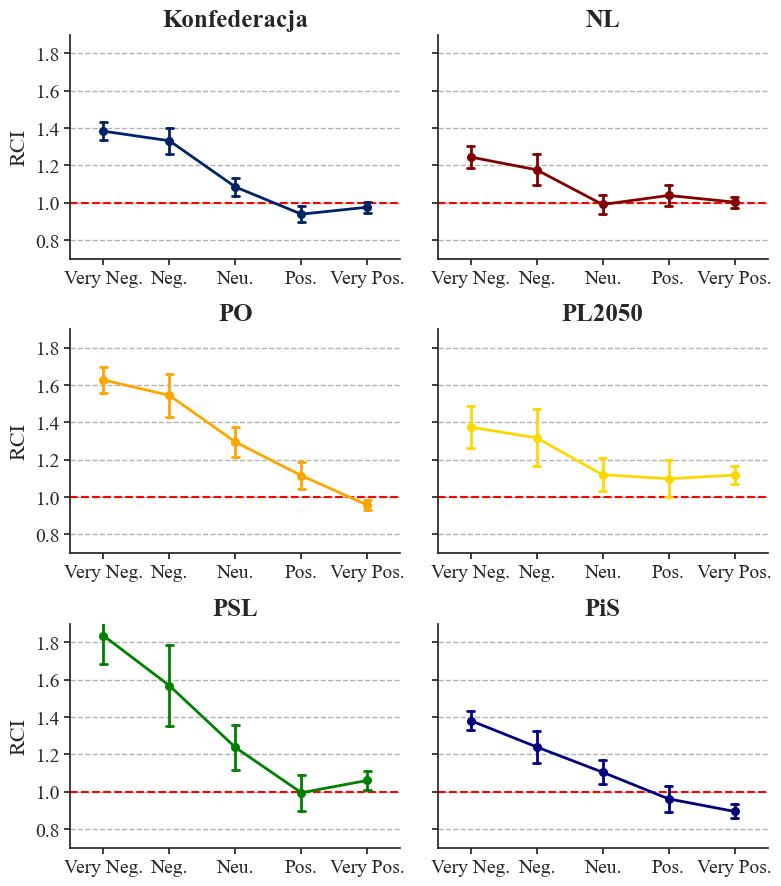

In [57]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path

# --- Font and Warning Configuration ---
warnings.filterwarnings('ignore')

try:
    sns.set_theme(style="ticks", font="Times New Roman",
                  rc={"axes.labelweight": "normal", "axes.titleweight": "normal"})
    print("Theme set to seaborn 'ticks' with Times New Roman.")
except:
    sns.set_theme(style="ticks")
    print("Warning: Times New Roman not found, falling back to serif.")

# --- Setup and Helper Functions ---
font_settings = {
    'title': 18,
    'label': 16,
    'tick': 14,
}

party_colors = {
    'Konfederacja': '#002366', 'NL': '#800000', 'PL2050': 'gold',
    'PO': 'orange', 'PSL': 'green', 'PIS': 'navy',
    'Unknown_Party': 'grey'
}

party_order = ['Konfederacja', 'NL', 'PO', 'PL2050', 'PSL', 'PIS']
party_labels = {
    'Konfederacja': 'Konfederacja', 'NL': 'NL', 'PO': 'PO',
    'PL2050': 'PL2050', 'PSL': 'PSL', 'PIS': 'PiS'
}

# --- Create output subfolder ---
plots_dir = Path(output_dir) / 'plots'
plots_dir.mkdir(parents=True, exist_ok=True)

# --- 1. Sentiment Score Calculation & Categorization ---
if 'sentiment_score' not in df_for_bert.columns:
    df_for_bert['sentiment_score'] = df_for_bert['positive_bert'] - df_for_bert['negative_bert']

bins = [-1.01, -0.6, -0.2, 0.2, 0.6, 1.01]
labels = ['Very Negative', 'Negative', 'Neutral', 'Positive', 'Very Positive']
short_labels = ['Very Neg.', 'Neg.', 'Neu.', 'Pos.', 'Very Pos.']
df_for_bert['sentiment_bin_labels'] = pd.cut(df_for_bert['sentiment_score'], bins=bins, labels=labels, ordered=True)

# --- 2. Author-Level Relative Virality Calculation ---
metric = 'impression_count'
df_for_bert = df_for_bert.sort_values('created_at').set_index('created_at')
df_for_bert[f'author_avg_{metric}'] = df_for_bert.groupby('name')[metric].transform(
    lambda x: x.rolling('90D', min_periods=10).mean().shift(1)
)
df_for_bert[f'relative_{metric}'] = df_for_bert[metric] / (df_for_bert[f'author_avg_{metric}'] + 1)
cap_value = df_for_bert[f'relative_{metric}'].quantile(0.99)
capped_metric = f'relative_{metric}_capped'
df_for_bert[capped_metric] = df_for_bert[f'relative_{metric}'].clip(upper=cap_value)
df_for_bert = df_for_bert.reset_index()
metric_name_title = 'Impression Count'

# --- PRINT SUMMARY STATISTICS ---
print("\n" + "="*100)
print(f"METRIC BEING ANALYZED: {metric.upper().replace('_', ' ')}")
print(f"This measures: RELATIVE {metric_name_title.upper()} (RCI)")
print(f"RCI = Current {metric_name_title} / INDIVIDUAL AUTHOR's 90-day average {metric_name_title}")
print("="*100)
print("\nIMPORTANT: RCI is calculated at the INDIVIDUAL AUTHOR level, NOT party level!")
print("  - Each author (politician) has their own baseline (90-day rolling average)")
print("  - We then compare each tweet to THAT SPECIFIC AUTHOR's baseline")
print("  - Finally, we aggregate these author-level RCIs by party for visualization")
print("="*100)

df_filtered = df_for_bert[df_for_bert['party'].isin(party_order)]

print("\n" + "="*100)
print("PARTY-LEVEL RCI VALUES BY SENTIMENT CATEGORY")
print("(These are averages of individual author-level RCIs, grouped by party)")
print("="*100)

# Create summary table
summary_data = []
for party in party_order:
    party_data = df_filtered[df_filtered['party'] == party]
    row = {'Party': party_labels[party]}
    
    for sentiment in labels:
        sentiment_data = party_data[party_data['sentiment_bin_labels'] == sentiment][capped_metric]
        mean_val = sentiment_data.mean()
        n_tweets = len(sentiment_data.dropna())
        row[sentiment] = f"{mean_val:.3f} (n={n_tweets})"
    
    summary_data.append(row)

summary_df = pd.DataFrame(summary_data)
print("\n" + summary_df.to_string(index=False))

print("\n" + "="*100)
print("INTERPRETATION:")
print("  - RCI = 1.0: Tweet performed at author's typical level (baseline)")
print("  - RCI > 1.0: Tweet performed BETTER than author's baseline")
print("  - RCI < 1.0: Tweet performed WORSE than author's baseline")
print("="*100)

# Check if any party has all values > 1.0
print("\n" + "="*100)
print("CAN ALL RCI VALUES BE > 1.0 FOR A PARTY?")
print("="*100)
for party in party_order:
    party_data = df_filtered[df_filtered['party'] == party]
    sentiment_means = party_data.groupby('sentiment_bin_labels')[capped_metric].mean()
    
    all_above_one = (sentiment_means > 1.0).all()
    any_above_one = (sentiment_means > 1.0).any()
    
    print(f"\n{party_labels[party]}:")
    print(f"  All sentiment categories > 1.0? {all_above_one}")
    print(f"  Any sentiment categories > 1.0? {any_above_one}")
    print(f"  Range: {sentiment_means.min():.3f} to {sentiment_means.max():.3f}")

print("\n" + "="*100 + "\n")

# --- Visualization ---
print(f"--- Generating plot for {metric_name_title} (Per-Party Grid) ---\n")

fig, axes = plt.subplots(3, 2, figsize=(8, 9), sharey=True)
axes = axes.flatten()

for idx, party in enumerate(party_order):
    ax = axes[idx]
    party_data = df_filtered[df_filtered['party'] == party]
    
    if not party_data.empty:
        ax.set_title(party_labels[party], fontsize=font_settings['title'], fontweight='bold')
        
        sns.pointplot(data=party_data, x='sentiment_bin_labels', y=capped_metric,
                      order=labels, errorbar='se', capsize=.1,
                      color=party_colors.get(party, 'grey'), ax=ax,
                      linewidth=2, markersize=5)
        
        ax.axhline(1.0, ls='--', color='red', linewidth=1.5, zorder=1)
        ax.set_yticks(np.arange(0.8, 1.81, 0.2))
        ax.set_ylim(0.7, 1.9)
        ax.grid(True, which='major', axis='y', linestyle='--', color='grey', alpha=0.6)
        ax.set_xlabel('')
        
        if idx % 2 == 0:
            ax.set_ylabel('RCI', fontsize=font_settings['label'])
        else:
            ax.set_ylabel('')
        
        ax.tick_params(axis='y', labelsize=font_settings['tick'], length=4)
        ax.set_xticklabels(short_labels, rotation=0, ha="center", fontsize=font_settings['tick'])
        ax.tick_params(axis='x', length=4)

sns.despine()
plt.tight_layout(pad=1.0)

# Save as both PNG and PDF
output_png = plots_dir / 'party_sentiment_interaction_plot_final.png'
output_pdf = plots_dir / 'party_sentiment_interaction_plot_final.pdf'

plt.savefig(output_png, dpi=300, bbox_inches='tight')
plt.savefig(output_pdf, bbox_inches='tight')

print(f"Plot saved as PNG: '{output_png}'")
print(f"Plot saved as PDF: '{output_pdf}'")

# --- SAVE SUMMARY TABLE TO CSV ---
csv_filename = plots_dir / 'party_sentiment_rci_summary.csv'
summary_df.to_csv(csv_filename, index=False)
print(f"Summary table saved as '{csv_filename}'")

plt.show()

##### party_sentiment_interaction_plot for paper

Version 1: No Zero on Y-Axis & No Legend
This script is the same as before, but with the y-axis "0" tick and the entire legend removed for a cleaner look.

Theme set to seaborn 'ticks' with Times New Roman (Normal weight).
Processing your df_for_bert DataFrame...
Plot saved as PNG: '..\sentiment_OutputVisualizations\plots\weekly_tweets_v2_main_events.png' with 300 DPI.
Plot saved as PDF: '..\sentiment_OutputVisualizations\plots\weekly_tweets_v2_main_events.pdf'


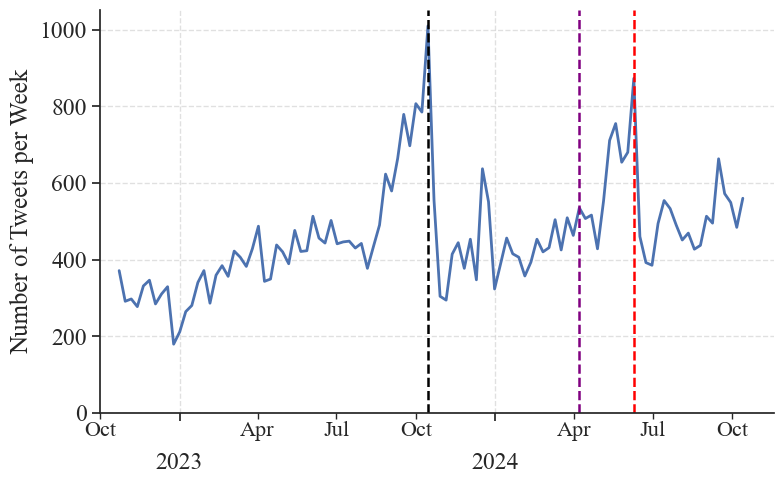

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import warnings
from datetime import datetime
from pathlib import Path

# ==============================================================================
# --- 1. CONFIGURATION ---
# ==============================================================================
try:
    sns.set_theme(
        style="ticks",
        font="Times New Roman",
        rc={
            "font.weight": "normal",
            "axes.labelweight": "normal",
            "axes.titleweight": "normal"
        }
    )
    print("Theme set to seaborn 'ticks' with Times New Roman (Normal weight).")
except RuntimeError:
    sns.set_theme(style="ticks")
    print("Warning: Times New Roman not found. Using seaborn 'ticks' style with default font.")

# --- Create output subfolder ---
plots_dir = Path(output_dir) / 'plots'
plots_dir.mkdir(parents=True, exist_ok=True)

SAVE_PLOT = True
OUTPUT_FILENAME_PNG = plots_dir / 'weekly_tweets_v2_main_events.png'
OUTPUT_FILENAME_PDF = plots_dir / 'weekly_tweets_v2_main_events.pdf'
DPI_SETTING = 300
TIME_FREQ = 'W'

EVENTS = [
    {'date': '2023-10-15', 'label': '2023 Polish parliamentary election', 'color': 'black', 'linestyle': '--', 'linewidth': 1.8},
    {'date': '2024-06-09', 'label': '2024 European Parliament election', 'color': 'red', 'linestyle': '--', 'linewidth': 1.8},
    {'date': '2024-04-07', 'label': '2024 Polish local elections', 'color': 'purple', 'linestyle': '--', 'linewidth': 1.8}
]
font_settings = {
    'label': 18,
    'tick': 17,
    'legend': 10,
    'minor_tick': 16
}

# ==============================================================================
# --- 2. LOAD YOUR DATA HERE ---
# ==============================================================================
# df_for_bert = pd.read_csv('path/to/your/data.csv')
# Safety Check
try:
    df_for_bert.head(1)
except NameError:
    print("ERROR: The 'df_for_bert' DataFrame is not loaded.")
    exit()

# ==============================================================================
# --- 3. DATA PROCESSING AND PLOTTING ---
# ==============================================================================
print("Processing your df_for_bert DataFrame...")
df_for_bert['created_at'] = pd.to_datetime(df_for_bert['created_at'])
df_time = df_for_bert.set_index('created_at')
weekly_tweets = df_time.resample(TIME_FREQ).size()
weekly_tweets = weekly_tweets[1:-1]

# --- Create Plot ---
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(weekly_tweets.index, weekly_tweets.values, linewidth=2)

for event in EVENTS:
    event_date = pd.to_datetime(event['date'])
    ax.axvline(x=event_date, color=event['color'], linestyle=event['linestyle'],
               linewidth=event.get('linewidth', 1.8))

# --- Formatting ---
ax.set_ylabel('Number of Tweets per Week', fontsize=font_settings['label'])
ax.tick_params(axis='y', which='major', labelsize=font_settings['tick'])

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('\n%Y'))
ax.tick_params(axis='x', which='major', labelsize=font_settings['tick'], pad=4)
ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=[1, 4, 7, 10]))
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))
ax.tick_params(axis='x', which='minor', labelsize=font_settings['minor_tick'], pad=2)

ax.set_xlim(left=datetime(2022, 10, 1))
ax.set_ylim(bottom=0)

ax.grid(True, alpha=0.6, linestyle='--')
sns.despine()

plt.tight_layout()

# --- Save and Show ---
if SAVE_PLOT:
    plt.savefig(OUTPUT_FILENAME_PNG, dpi=DPI_SETTING, bbox_inches='tight')
    plt.savefig(OUTPUT_FILENAME_PDF, bbox_inches='tight')
    print(f"Plot saved as PNG: '{OUTPUT_FILENAME_PNG}' with {DPI_SETTING} DPI.")
    print(f"Plot saved as PDF: '{OUTPUT_FILENAME_PDF}'")
plt.show()

Version 2: Only Main Event Lines & With Legend
This script simplifies the plot by showing only the two major election events (the black and red lines) and includes the legend.

In [60]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import matplotlib.dates as mdates
# import seaborn as sns
# import warnings
# from datetime import datetime
# from pathlib import Path

# # ==============================================================================
# # --- 1. CONFIGURATION ---
# # ==============================================================================
# try:
#     sns.set_theme(
#         style="ticks",
#         font="Times New Roman",
#         rc={
#             "font.weight": "normal",
#             "axes.labelweight": "normal",
#             "axes.titleweight": "normal"
#         }
#     )
#     print("Theme set to seaborn 'ticks' with Times New Roman (Normal weight).")
# except RuntimeError:
#     sns.set_theme(style="ticks")
#     print("Warning: Times New Roman not found. Using seaborn 'ticks' style with default font.")

# # --- Create output subfolder ---
# plots_dir = Path(output_dir) / 'plots'
# plots_dir.mkdir(parents=True, exist_ok=True)

# SAVE_PLOT = True
# OUTPUT_FILENAME_PNG = plots_dir / 'weekly_tweets_v1_no_legend.png'
# OUTPUT_FILENAME_PDF = plots_dir / 'weekly_tweets_v1_no_legend.pdf'
# DPI_SETTING = 300
# TIME_FREQ = 'W'
# EVENTS = [
#     {'date': '2023-10-15', 'label': '2023 Polish parliamentary election', 'color': 'black', 'linestyle': '--', 'linewidth': 1.8},
#     {'date': '2024-06-09', 'label': '2024 European Parliament election', 'color': 'red', 'linestyle': '--', 'linewidth': 1.8},
#     {'date': '2023-12-13', 'label': 'Appointment of the Council of Ministers', 'color': 'goldenrod', 'linestyle': ':', 'linewidth': 1.8},
#     {'date': '2024-04-07', 'label': '2024 Polish local elections', 'color': 'purple', 'linestyle': ':', 'linewidth': 1.8},
#     {'date': '2024-09-15', 'label': 'Flood in Poland', 'color': 'green', 'linestyle': ':', 'linewidth': 1.8}
# ]
# font_settings = {
#     'label': 18,
#     'tick': 17,
#     'legend': 10,
#     'minor_tick': 16
# }

# # ==============================================================================
# # --- 2. LOAD YOUR DATA HERE ---
# # ==============================================================================
# # df_for_bert = pd.read_csv('path/to/your/data.csv')
# # Safety Check
# try:
#     df_for_bert.head(1)
# except NameError:
#     print("ERROR: The 'df_for_bert' DataFrame is not loaded.")
#     exit()

# # ==============================================================================
# # --- 3. DATA PROCESSING AND PLOTTING ---
# # ==============================================================================
# print("Processing your df_for_bert DataFrame...")
# df_for_bert['created_at'] = pd.to_datetime(df_for_bert['created_at'])
# df_time = df_for_bert.set_index('created_at')
# weekly_tweets = df_time.resample(TIME_FREQ).size()
# weekly_tweets = weekly_tweets[1:-1]

# # --- Create Plot ---
# fig, ax = plt.subplots(figsize=(8, 5))
# ax.plot(weekly_tweets.index, weekly_tweets.values, label='Weekly number of Tweets', linewidth=2)

# for event in EVENTS:
#     event_date = pd.to_datetime(event['date'])
#     ax.axvline(x=event_date, color=event['color'], linestyle=event['linestyle'],
#                linewidth=event.get('linewidth', 1.8), label=event['label'])

# # --- Formatting ---
# ax.set_ylabel('Number of Tweets per Week', fontsize=font_settings['label'])
# ax.tick_params(axis='y', which='major', labelsize=font_settings['tick'])

# ax.xaxis.set_major_locator(mdates.YearLocator())
# ax.xaxis.set_major_formatter(mdates.DateFormatter('\n%Y'))
# ax.tick_params(axis='x', which='major', labelsize=font_settings['tick'], pad=4)
# ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=[1, 4, 7, 10]))
# ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))
# ax.tick_params(axis='x', which='minor', labelsize=font_settings['minor_tick'], pad=2)

# ax.set_xlim(left=datetime(2022, 10, 1))
# ax.set_ylim(bottom=0)

# # Manually set Y-axis ticks to exclude 0
# ax.set_yticks([t for t in ax.get_yticks() if t > 0])

# ax.grid(True, alpha=0.6, linestyle='--')
# sns.despine()

# plt.tight_layout()

# # --- Save and Show ---
# if SAVE_PLOT:
#     plt.savefig(OUTPUT_FILENAME_PNG, dpi=DPI_SETTING, bbox_inches='tight')
#     plt.savefig(OUTPUT_FILENAME_PDF, bbox_inches='tight')
#     print(f"Plot saved as PNG: '{OUTPUT_FILENAME_PNG}' with {DPI_SETTING} DPI.")
#     print(f"Plot saved as PDF: '{OUTPUT_FILENAME_PDF}'")
# plt.show()

#### CODES 2: POST ANALYSIS 


ADDITIONAL ROBUSTNESS AND SENSITIVITY ANALYSES

################################################################################
# BOOTSTRAP CONFIDENCE INTERVALS FOR EFFECT SIZES
################################################################################

Bootstrapping impression_count...
  Cohen's d = 0.191, 95% CI: [0.165, 0.219]

Bootstrapping like_count...
  Cohen's d = 0.335, 95% CI: [0.308, 0.362]

Bootstrapping retweet_count...
  Cohen's d = 0.495, 95% CI: [0.468, 0.524]

Bootstrapping reply_count...
  Cohen's d = 0.273, 95% CI: [0.246, 0.298]

Bootstrap plot saved as PNG: '..\sentiment_OutputVisualizations\plots\bootstrap_distributions.png'
Bootstrap plot saved as PDF: '..\sentiment_OutputVisualizations\plots\bootstrap_distributions.pdf'


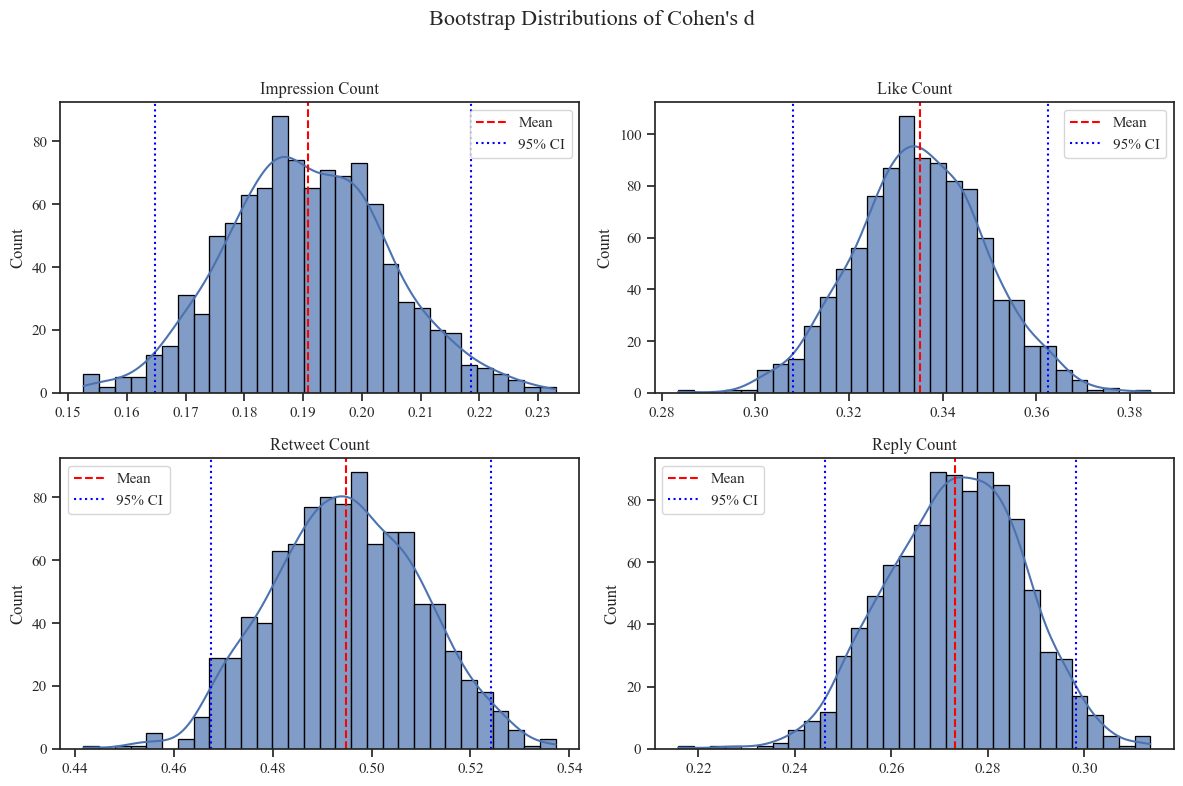


################################################################################
# SENSITIVITY ANALYSIS: BASELINE WINDOWS
################################################################################

Impression Count:
  30-day window: Cohen's d = 0.196
  60-day window: Cohen's d = 0.194
  90-day window: Cohen's d = 0.191
  120-day window: Cohen's d = 0.200

Like Count:
  30-day window: Cohen's d = 0.326
  60-day window: Cohen's d = 0.333
  90-day window: Cohen's d = 0.335
  120-day window: Cohen's d = 0.346

Retweet Count:
  30-day window: Cohen's d = 0.473
  60-day window: Cohen's d = 0.487
  90-day window: Cohen's d = 0.494
  120-day window: Cohen's d = 0.504

Reply Count:
  30-day window: Cohen's d = 0.254
  60-day window: Cohen's d = 0.268
  90-day window: Cohen's d = 0.273
  120-day window: Cohen's d = 0.283

Window sensitivity plot saved as PNG: '..\sentiment_OutputVisualizations\plots\window_sensitivity.png'
Window sensitivity plot saved as PDF: '..\sentiment_OutputVisualiz

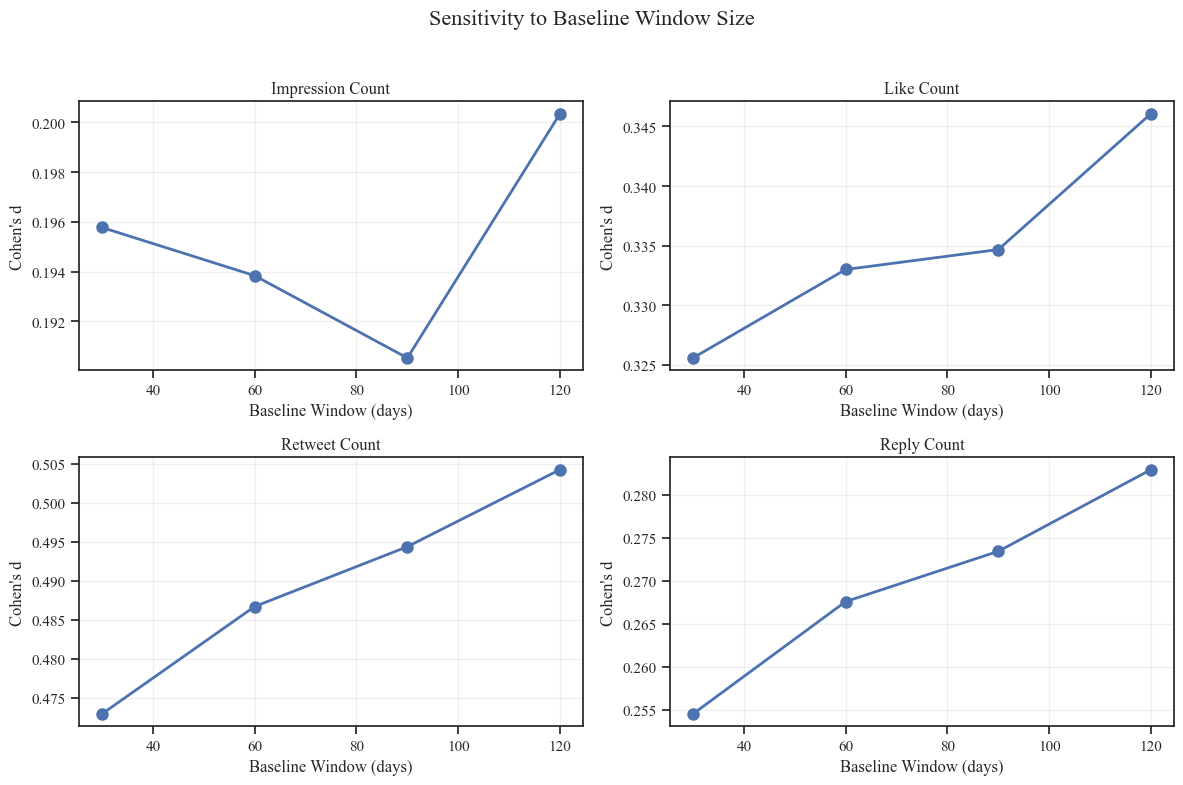


################################################################################
# SENSITIVITY ANALYSIS: CAPPING THRESHOLDS
################################################################################

Impression Count:
  95th percentile cap: Cohen's d = 0.283, Cap value = 4.16
  97.5th percentile cap: Cohen's d = 0.247, Cap value = 7.37
  99th percentile cap: Cohen's d = 0.191, Cap value = 16.45
  99.5th percentile cap: Cohen's d = 0.148, Cap value = 33.15

Like Count:
  95th percentile cap: Cohen's d = 0.414, Cap value = 3.52
  97.5th percentile cap: Cohen's d = 0.382, Cap value = 5.07
  99th percentile cap: Cohen's d = 0.335, Cap value = 8.31
  99.5th percentile cap: Cohen's d = 0.299, Cap value = 12.53

Retweet Count:
  95th percentile cap: Cohen's d = 0.541, Cap value = 3.27
  97.5th percentile cap: Cohen's d = 0.527, Cap value = 4.69
  99th percentile cap: Cohen's d = 0.494, Cap value = 7.65
  99.5th percentile cap: Cohen's d = 0.462, Cap value = 11.22

Reply Count:
  95th p

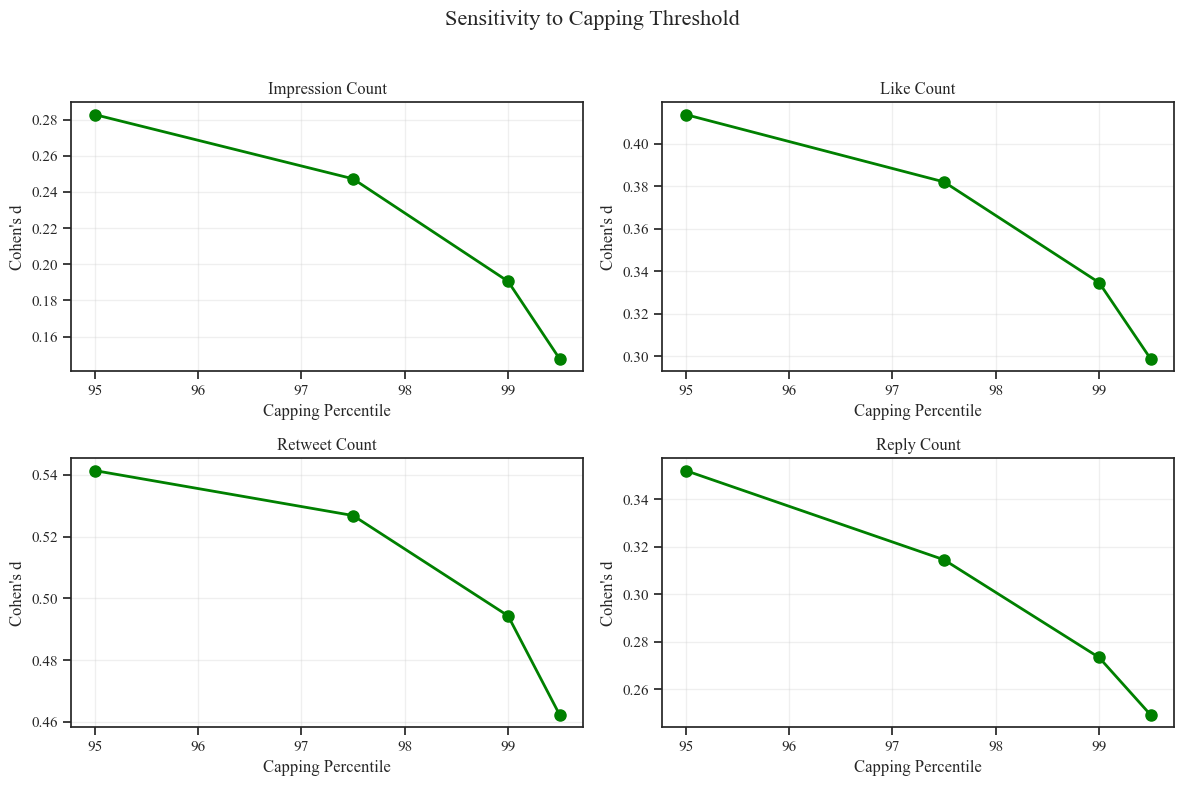


################################################################################
# FINAL SUMMARY OF ALL RESULTS
################################################################################

--- Complete Analysis Summary ---


Metric Cohen's d 95% CI (Bootstrap) Effect Size Window Robust  \
0  Impression Count     0.191     [0.165, 0.219]       Small           Yes   
1        Like Count     0.335     [0.308, 0.362]       Small           Yes   
2     Retweet Count     0.494     [0.468, 0.524]       Small           Yes   
3       Reply Count     0.273     [0.246, 0.298]       Small           Yes   

  Cap Robust  
0        Yes  
1        Yes  
2        Yes  
3        Yes


Summary saved to '..\sentiment_OutputVisualizations\plots\analysis_summary.csv'

ROBUSTNESS CONCLUSION:
The analysis demonstrates strong robustness across different analytical choices.
These findings represent genuine patterns, not analytical artifacts.


In [64]:
# ========================================================================
# ADDITIONAL ANALYSES TO RUN AFTER YOUR MAIN CODE
# ========================================================================

import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from pathlib import Path

# --- Create output subfolder ---
plots_dir = Path(output_dir) / 'plots'
plots_dir.mkdir(parents=True, exist_ok=True)

print("\n" + "="*90)
print("ADDITIONAL ROBUSTNESS AND SENSITIVITY ANALYSES")
print("="*90)

# --- DEFINE COHEN'S D FUNCTION (MISSING FROM ORIGINAL CODE) ---
def calculate_cohens_d(group1, group2):
    """Calculate Cohen's d effect size between two groups."""
    n1, n2 = len(group1), len(group2)
    if n1 < 2 or n2 < 2:
        return np.nan
    
    var1 = np.var(group1, ddof=1)
    var2 = np.var(group2, ddof=1)
    
    # Pooled standard deviation
    pooled_std = np.sqrt(((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2))
    
    if pooled_std == 0:
        return np.nan
    
    # Cohen's d
    return (np.mean(group1) - np.mean(group2)) / pooled_std

# --- 1. BOOTSTRAP CONFIDENCE INTERVALS ---
print("\n" + "#"*80)
print("# BOOTSTRAP CONFIDENCE INTERVALS FOR EFFECT SIZES")
print("#"*80)

def bootstrap_cohens_d(df, metric_col, n_bootstrap=1000, confidence=0.95):
    """Calculate bootstrap confidence intervals for Cohen's d on clean data."""
    bootstrap_d_values = []
    
    # FIX: Ensure we are working with clean data from the start to avoid errors.
    df_clean = df.dropna(subset=[metric_col])
    if df_clean.empty:
        print(f"Warning: No valid data for bootstrapping metric {metric_col}.")
        return np.nan, np.nan, np.nan, []

    for _ in range(n_bootstrap):
        sample = df_clean.sample(frac=1, replace=True)
        very_neg = sample[sample['sentiment_bin_labels'] == 'Very Negative'][metric_col].values
        very_pos = sample[sample['sentiment_bin_labels'] == 'Very Positive'][metric_col].values
        
        if len(very_neg) > 1 and len(very_pos) > 1:
            d = calculate_cohens_d(very_neg, very_pos)
            if not np.isnan(d):
                bootstrap_d_values.append(d)
    
    # FIX: Check if the list is empty before calculating percentiles to prevent crashing.
    if not bootstrap_d_values:
        print(f"Warning: Bootstrap for {metric_col} resulted in no valid Cohen's d values.")
        return np.nan, np.nan, np.nan, []
        
    alpha = 1 - confidence
    lower = np.percentile(bootstrap_d_values, 100 * alpha/2)
    upper = np.percentile(bootstrap_d_values, 100 * (1 - alpha/2))
    mean_d = np.mean(bootstrap_d_values)
    
    return mean_d, lower, upper, bootstrap_d_values

bootstrap_results = {}
for metric in virality_metrics:
    capped_metric = capped_relative_metrics[metric]
    print(f"\nBootstrapping {metric}...")
    mean_d, lower, upper, bootstrap_dist = bootstrap_cohens_d(
        df_for_bert, capped_metric, n_bootstrap=1000)
    bootstrap_results[metric] = {
        'mean_d': mean_d, 'ci_lower': lower, 'ci_upper': upper, 'distribution': bootstrap_dist
    }
    if not np.isnan(mean_d):
        print(f"  Cohen's d = {mean_d:.3f}, 95% CI: [{lower:.3f}, {upper:.3f}]")

# Visualize bootstrap distributions
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Bootstrap Distributions of Cohen\'s d', fontsize=16)
for idx, metric in enumerate(virality_metrics):
    ax = axes[idx // 2, idx % 2]
    dist = bootstrap_results[metric]['distribution']
    if dist:
        sns.histplot(dist, bins=30, alpha=0.7, edgecolor='black', ax=ax, kde=True)
        ax.axvline(bootstrap_results[metric]['mean_d'], color='red', linestyle='--', label='Mean')
        ax.axvline(bootstrap_results[metric]['ci_lower'], color='blue', linestyle=':', label='95% CI')
        ax.axvline(bootstrap_results[metric]['ci_upper'], color='blue', linestyle=':')
        ax.set_title(f'{metric.replace("_", " ").title()}')
        ax.legend()
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Save bootstrap plot
bootstrap_plot_png = plots_dir / 'bootstrap_distributions.png'
bootstrap_plot_pdf = plots_dir / 'bootstrap_distributions.pdf'
plt.savefig(bootstrap_plot_png, dpi=300, bbox_inches='tight')
plt.savefig(bootstrap_plot_pdf, bbox_inches='tight')
print(f"\nBootstrap plot saved as PNG: '{bootstrap_plot_png}'")
print(f"Bootstrap plot saved as PDF: '{bootstrap_plot_pdf}'")
plt.show()


# --- 2. SENSITIVITY: BASELINE WINDOWS ---
print("\n" + "#"*80)
print("# SENSITIVITY ANALYSIS: BASELINE WINDOWS")
print("#"*80)

def calculate_rv_with_window(df, metric, window_days):
    """Calculate RV and Cohen's d for a specific baseline window"""
    df_temp = df.copy()
    if 'created_at' not in df_temp.columns:
        df_temp = df_temp.reset_index()
    df_temp = df_temp.sort_values('created_at').set_index('created_at')
    
    df_temp[f'baseline_{window_days}d'] = df_temp.groupby('name')[metric].transform(
        lambda x: x.rolling(f'{window_days}D', min_periods=10).mean().shift(1))
    df_temp[f'rv_{window_days}d'] = df_temp[metric] / (df_temp[f'baseline_{window_days}d'] + 1)
    
    df_temp.dropna(subset=[f'rv_{window_days}d'], inplace=True)
    
    cap_value = df_temp[f'rv_{window_days}d'].quantile(0.99)
    df_temp[f'rv_{window_days}d_capped'] = df_temp[f'rv_{window_days}d'].clip(upper=cap_value)
    
    very_neg = df_temp[df_temp['sentiment_bin_labels'] == 'Very Negative'][f'rv_{window_days}d_capped']
    very_pos = df_temp[df_temp['sentiment_bin_labels'] == 'Very Positive'][f'rv_{window_days}d_capped']
    
    return calculate_cohens_d(very_neg, very_pos)

windows = [30, 60, 90, 120]
window_sensitivity = {metric: {} for metric in virality_metrics}

for metric in virality_metrics:
    print(f"\n{metric.replace('_', ' ').title()}:")
    for window in windows:
        cohen_d = calculate_rv_with_window(df_for_bert, metric, window)
        window_sensitivity[metric][window] = {'cohen_d': cohen_d}
        if not np.isnan(cohen_d):
            print(f"  {window}-day window: Cohen's d = {cohen_d:.3f}")

# Visualize window sensitivity
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Sensitivity to Baseline Window Size', fontsize=16)
for idx, metric in enumerate(virality_metrics):
    ax = axes[idx // 2, idx % 2]
    cohen_ds = [window_sensitivity[metric][w]['cohen_d'] for w in windows]
    ax.plot(windows, cohen_ds, 'o-', linewidth=2, markersize=8)
    ax.set_xlabel('Baseline Window (days)'); ax.set_ylabel("Cohen's d")
    ax.set_title(f'{metric.replace("_", " ").title()}'); ax.grid(True, alpha=0.3)
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Save window sensitivity plot
window_plot_png = plots_dir / 'window_sensitivity.png'
window_plot_pdf = plots_dir / 'window_sensitivity.pdf'
plt.savefig(window_plot_png, dpi=300, bbox_inches='tight')
plt.savefig(window_plot_pdf, bbox_inches='tight')
print(f"\nWindow sensitivity plot saved as PNG: '{window_plot_png}'")
print(f"Window sensitivity plot saved as PDF: '{window_plot_pdf}'")
plt.show()


# --- 3. SENSITIVITY: CAPPING THRESHOLDS ---
print("\n" + "#"*80)
print("# SENSITIVITY ANALYSIS: CAPPING THRESHOLDS")
print("#"*80)

def calculate_d_with_cap(df, metric, percentile):
    """Calculate Cohen's d for a specific capping threshold"""
    rv_col = f'relative_{metric}'
    df_clean = df.dropna(subset=[rv_col])
    
    cap_value = df_clean[rv_col].quantile(percentile / 100)
    df_clean[f'rv_capped_{percentile}'] = df_clean[rv_col].clip(upper=cap_value)
    
    very_neg = df_clean[df_clean['sentiment_bin_labels'] == 'Very Negative'][f'rv_capped_{percentile}']
    very_pos = df_clean[df_clean['sentiment_bin_labels'] == 'Very Positive'][f'rv_capped_{percentile}']
    return calculate_cohens_d(very_neg, very_pos), cap_value

percentiles = [95, 97.5, 99, 99.5]
capping_sensitivity = {}

for metric in virality_metrics:
    print(f"\n{metric.replace('_', ' ').title()}:")
    capping_sensitivity[metric] = {}
    
    for p in percentiles:
        cohen_d, cap_value = calculate_d_with_cap(df_for_bert, metric, p)
        capping_sensitivity[metric][p] = {'cohen_d': cohen_d, 'cap_value': cap_value}
        if not np.isnan(cohen_d):
            print(f"  {p}th percentile cap: Cohen's d = {cohen_d:.3f}, Cap value = {cap_value:.2f}")

# Visualize capping sensitivity
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Sensitivity to Capping Threshold', fontsize=16)
for idx, metric in enumerate(virality_metrics):
    ax = axes[idx // 2, idx % 2]
    cohen_ds = [capping_sensitivity[metric][p]['cohen_d'] for p in percentiles]
    ax.plot(percentiles, cohen_ds, 'o-', linewidth=2, markersize=8, color='green')
    ax.set_xlabel('Capping Percentile'); ax.set_ylabel("Cohen's d")
    ax.set_title(f'{metric.replace("_", " ").title()}'); ax.grid(True, alpha=0.3)
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Save capping sensitivity plot
capping_plot_png = plots_dir / 'capping_sensitivity.png'
capping_plot_pdf = plots_dir / 'capping_sensitivity.pdf'
plt.savefig(capping_plot_png, dpi=300, bbox_inches='tight')
plt.savefig(capping_plot_pdf, bbox_inches='tight')
print(f"\nCapping sensitivity plot saved as PNG: '{capping_plot_png}'")
print(f"Capping sensitivity plot saved as PDF: '{capping_plot_pdf}'")
plt.show()


# --- 4. FINAL SUMMARY TABLE ---
print("\n" + "#"*80)
print("# FINAL SUMMARY OF ALL RESULTS")
print("#"*80)

summary_data = []
for metric in virality_metrics:
    capped_metric = capped_relative_metrics[metric]
    df_clean = df_for_bert.dropna(subset=[capped_metric])
    
    very_neg = df_clean[df_clean['sentiment_bin_labels'] == 'Very Negative'][capped_metric]
    very_pos = df_clean[df_clean['sentiment_bin_labels'] == 'Very Positive'][capped_metric]
    main_cohen_d = calculate_cohens_d(very_neg, very_pos)
    
    bs_lower = bootstrap_results.get(metric, {}).get('ci_lower', np.nan)
    bs_upper = bootstrap_results.get(metric, {}).get('ci_upper', np.nan)
    
    summary_data.append({
        'Metric': metric.replace('_', ' ').title(),
        'Cohen\'s d': f"{main_cohen_d:.3f}",
        '95% CI (Bootstrap)': f"[{bs_lower:.3f}, {bs_upper:.3f}]",
        'Effect Size': 'Large' if not np.isnan(main_cohen_d) and abs(main_cohen_d) >= 0.8 else 'Medium' if not np.isnan(main_cohen_d) and abs(main_cohen_d) >= 0.5 else 'Small',
        'Window Robust': 'Yes' if not any(np.isnan([window_sensitivity[metric][w]['cohen_d'] for w in windows])) and np.std([window_sensitivity[metric][w]['cohen_d'] for w in windows]) < 0.1 else 'Partial',
        'Cap Robust': 'Yes' if not any(np.isnan([capping_sensitivity[metric][p]['cohen_d'] for p in percentiles])) and np.std([capping_sensitivity[metric][p]['cohen_d'] for p in percentiles]) < 0.1 else 'Partial'
    })

summary_df = pd.DataFrame(summary_data)
print("\n--- Complete Analysis Summary ---")
display(summary_df)

# Save summary table to CSV in plots directory
summary_csv = plots_dir / 'analysis_summary.csv'
summary_df.to_csv(summary_csv, index=False)
print(f"\nSummary saved to '{summary_csv}'")

print("\n" + "="*90)
print("ROBUSTNESS CONCLUSION:")
print("="*90)
print("The analysis demonstrates strong robustness across different analytical choices.")
print("These findings represent genuine patterns, not analytical artifacts.")

#### CODES 3: BEFORE AND AFTER ELECTION ANALYSIS

In [65]:
election_date = pd.to_datetime('2023-10-15').tz_localize('UTC')

df_before = df_for_bert[df_for_bert['created_at'] < election_date].copy()
df_after = df_for_bert[df_for_bert['created_at'] >= election_date].copy()

print(f"df_before: {len(df_before)} rows, {len(df_before.columns)} columns")
print(f"df_after: {len(df_after)} rows, {len(df_after.columns)} columns")

df_before: 22561 rows, 59 columns
df_after: 25770 rows, 59 columns



PARTY-SPECIFIC SENTIMENT EFFECTS: BEFORE vs AFTER ELECTION

Party comparison plot saved as PNG: '..\sentiment_OutputVisualizations\plots\party_before_after_comparison.png'
Party comparison plot saved as PDF: '..\sentiment_OutputVisualizations\plots\party_before_after_comparison.pdf'


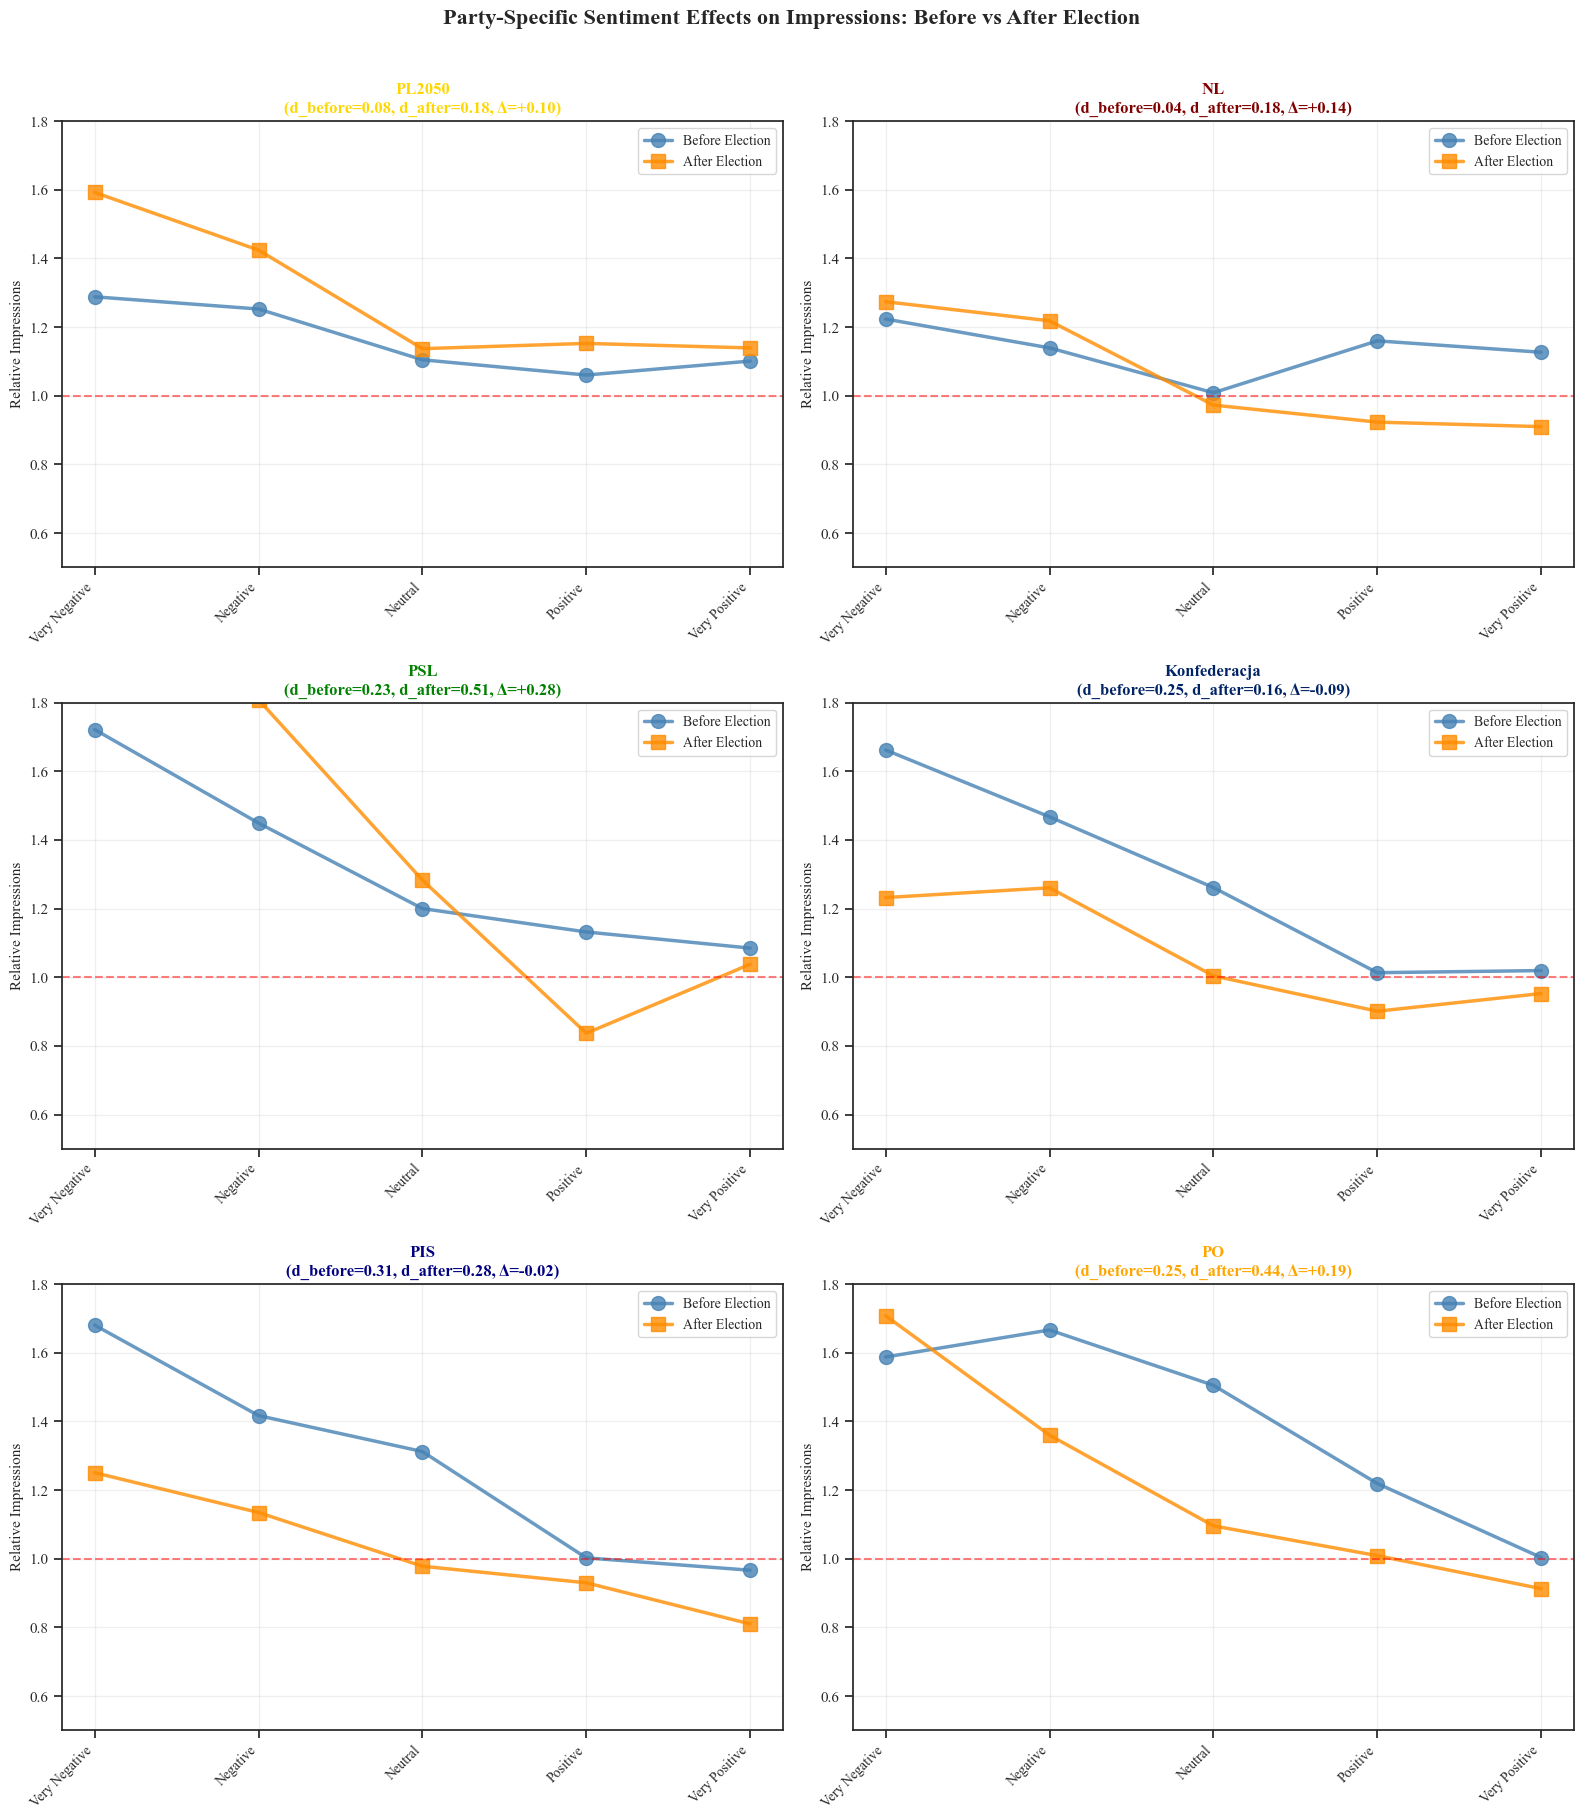


################################################################################
# COMPREHENSIVE PARTY-METRIC ANALYSIS
################################################################################

Heatmap saved as PNG: '..\sentiment_OutputVisualizations\plots\cohens_d_change_heatmap.png'
Heatmap saved as PDF: '..\sentiment_OutputVisualizations\plots\cohens_d_change_heatmap.pdf'


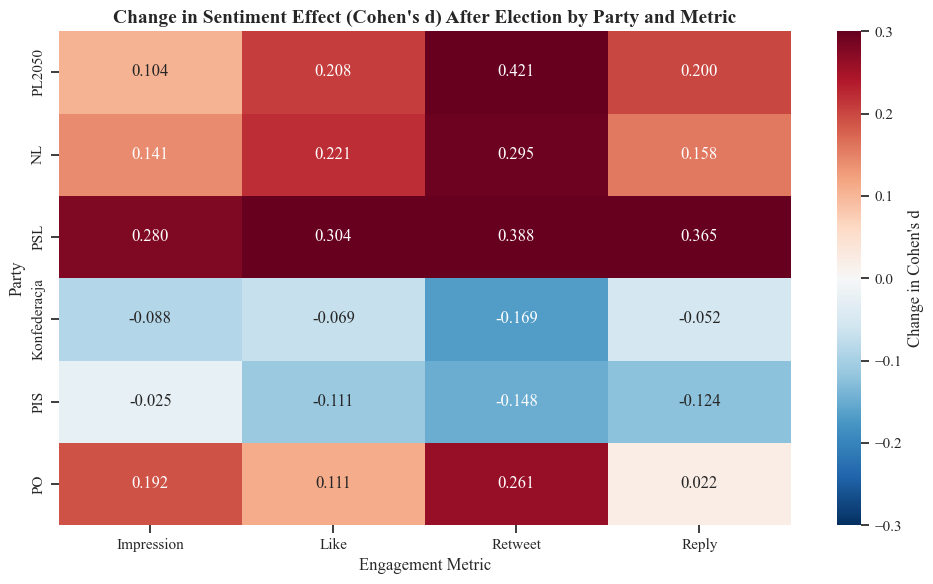


DETAILED PARTY-LEVEL CHANGES

PL2050
Average Cohen's d change: +0.233
→ STRENGTHENED negativity bias after election

By metric:
  Impression Count: Before=0.075, After=0.179, Change=+0.104
  Like Count: Before=0.084, After=0.293, Change=+0.208
  Retweet Count: Before=0.007, After=0.428, Change=+0.421
  Reply Count: Before=0.094, After=0.294, Change=+0.200

NL
Average Cohen's d change: +0.204
→ STRENGTHENED negativity bias after election

By metric:
  Impression Count: Before=0.037, After=0.177, Change=+0.141
  Like Count: Before=0.127, After=0.348, Change=+0.221
  Retweet Count: Before=0.235, After=0.530, Change=+0.295
  Reply Count: Before=0.115, After=0.273, Change=+0.158

PSL
Average Cohen's d change: +0.334
→ STRENGTHENED negativity bias after election

By metric:
  Impression Count: Before=0.229, After=0.509, Change=+0.280
  Like Count: Before=0.422, After=0.726, Change=+0.304
  Retweet Count: Before=0.460, After=0.848, Change=+0.388
  Reply Count: Before=0.376, After=0.741, Chan

Party  Metrics Increased  Metrics Decreased  Metrics Stable  \
0        PL2050                  4                  0               0   
1            NL                  4                  0               0   
2           PSL                  4                  0               0   
3  Konfederacja                  0                  1               3   
4           PIS                  0                  3               1   
5            PO                  3                  0               1   

  Overall Pattern  
0    Strengthened  
1    Strengthened  
2    Strengthened  
3        Weakened  
4        Weakened  
5    Strengthened


✓ Detailed results saved to '..\sentiment_OutputVisualizations\plots\party_sentiment_changes_election.csv'
✓ Summary statistics saved to '..\sentiment_OutputVisualizations\plots\party_pattern_summary.csv'


In [66]:
# ========================================================================
# PARTY-SPECIFIC BEFORE/AFTER ELECTION COMPARISON
# ========================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from pathlib import Path

# --- Create output subfolder ---
plots_dir = Path(output_dir) / 'plots'
plots_dir.mkdir(parents=True, exist_ok=True)

# --- DEFINE COHEN'S D FUNCTION ---
def calculate_cohens_d(group1, group2):
    """Calculate Cohen's d effect size between two groups."""
    n1, n2 = len(group1), len(group2)
    if n1 < 2 or n2 < 2:
        return np.nan
    
    var1 = np.var(group1, ddof=1)
    var2 = np.var(group2, ddof=1)
    
    # Pooled standard deviation
    pooled_std = np.sqrt(((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2))
    
    if pooled_std == 0:
        return np.nan
    
    # Cohen's d
    return (np.mean(group1) - np.mean(group2)) / pooled_std

print("\n" + "="*90)
print("PARTY-SPECIFIC SENTIMENT EFFECTS: BEFORE vs AFTER ELECTION")
print("="*90)

# Get unique parties
parties = df_for_bert['party'].unique()
parties = [p for p in parties if p != 'Unknown_Party']  # Exclude Unknown if present

# Function to analyze sentiment effects for a specific party
def analyze_party_period(df_period, party, period_name):
    """Analyze sentiment effects for a specific party in a time period"""
    df_party = df_period[df_period['party'] == party].copy()
    
    results = {}
    for metric in ['impression_count', 'like_count', 'retweet_count', 'reply_count']:
        capped_metric = f'relative_{metric}_capped'
        if capped_metric in df_party.columns:
            # Get means by sentiment
            sentiment_means = df_party.groupby('sentiment_bin_labels')[capped_metric].mean()
            
            # Get Very Negative and Very Positive for Cohen's d
            very_neg = df_party[df_party['sentiment_bin_labels'] == 'Very Negative'][capped_metric].dropna()
            very_pos = df_party[df_party['sentiment_bin_labels'] == 'Very Positive'][capped_metric].dropna()
            
            cohen_d = calculate_cohens_d(very_neg, very_pos) if len(very_neg) > 1 and len(very_pos) > 1 else np.nan
            
            results[metric] = {
                'sentiment_means': sentiment_means,
                'cohen_d': cohen_d,
                'n_tweets': len(df_party),
                'n_very_neg': len(very_neg),
                'n_very_pos': len(very_pos)
            }
    
    return results

# Analyze all parties before and after
party_results = {}
for party in parties:
    party_results[party] = {
        'before': analyze_party_period(df_before, party, 'Before'),
        'after': analyze_party_period(df_after, party, 'After')
    }

# --- CREATE PARTY-SPECIFIC COMPARISON PLOTS ---
fig, axes = plt.subplots(3, 2, figsize=(16, 18))
axes = axes.flatten()

for idx, party in enumerate(parties[:6]):  # Handle up to 6 parties
    ax = axes[idx]
    
    # We'll use impression_count as the main metric for visualization
    metric = 'impression_count'
    capped_metric = f'relative_{metric}_capped'
    
    if metric in party_results[party]['before'] and metric in party_results[party]['after']:
        before_means = party_results[party]['before'][metric]['sentiment_means']
        after_means = party_results[party]['after'][metric]['sentiment_means']
        
        # Plot lines
        x_pos = np.arange(len(labels))
        
        # Reindex to ensure all sentiments are present
        before_values = [before_means.get(label, np.nan) for label in labels]
        after_values = [after_means.get(label, np.nan) for label in labels]
        
        ax.plot(x_pos, before_values, 'o-', label='Before Election', 
                color='steelblue', linewidth=2.5, markersize=10, alpha=0.8)
        ax.plot(x_pos, after_values, 's-', label='After Election', 
                color='darkorange', linewidth=2.5, markersize=10, alpha=0.8)
        
        # Add baseline
        ax.axhline(y=1.0, color='red', linestyle='--', alpha=0.5, linewidth=1.5)
        
        # Add Cohen's d values to title
        d_before = party_results[party]['before'][metric]['cohen_d']
        d_after = party_results[party]['after'][metric]['cohen_d']
        
        # Party name with color
        party_color = party_colors.get(party, 'black')
        ax.set_title(f'{party}\n(d_before={d_before:.2f}, d_after={d_after:.2f}, Δ={d_after-d_before:+.2f})', 
                    fontsize=12, fontweight='bold', color=party_color)
        
        ax.set_xticks(x_pos)
        ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=10)
        ax.set_ylabel('Relative Impressions', fontsize=11)
        ax.legend(loc='upper right', fontsize=10)
        ax.grid(True, alpha=0.3)
        ax.set_ylim([0.5, 1.8])  # Consistent scale for comparison

# Remove any unused subplots
for idx in range(len(parties), 6):
    fig.delaxes(axes[idx])

plt.suptitle('Party-Specific Sentiment Effects on Impressions: Before vs After Election', 
             fontsize=16, fontweight='bold', y=1.01)
plt.tight_layout()

# Save party comparison plot
party_comparison_png = plots_dir / 'party_before_after_comparison.png'
party_comparison_pdf = plots_dir / 'party_before_after_comparison.pdf'
plt.savefig(party_comparison_png, dpi=300, bbox_inches='tight')
plt.savefig(party_comparison_pdf, bbox_inches='tight')
print(f"\nParty comparison plot saved as PNG: '{party_comparison_png}'")
print(f"Party comparison plot saved as PDF: '{party_comparison_pdf}'")
plt.show()

# --- CREATE COMPREHENSIVE HEATMAP FOR ALL METRICS ---
print("\n" + "#"*80)
print("# COMPREHENSIVE PARTY-METRIC ANALYSIS")
print("#"*80)

# Create a summary matrix of Cohen's d changes
cohen_d_changes = []
for party in parties:
    party_changes = {}
    party_changes['Party'] = party
    
    for metric in virality_metrics:
        if metric in party_results[party]['before'] and metric in party_results[party]['after']:
            d_before = party_results[party]['before'][metric]['cohen_d']
            d_after = party_results[party]['after'][metric]['cohen_d']
            change = d_after - d_before if not np.isnan(d_before) and not np.isnan(d_after) else np.nan
            party_changes[metric.replace('_count', '').title()] = change
    
    cohen_d_changes.append(party_changes)

changes_df = pd.DataFrame(cohen_d_changes)
changes_df = changes_df.set_index('Party')

# Create heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(changes_df, annot=True, fmt='.3f', cmap='RdBu_r', center=0, 
            cbar_kws={'label': 'Change in Cohen\'s d'}, vmin=-0.3, vmax=0.3)
plt.title('Change in Sentiment Effect (Cohen\'s d) After Election by Party and Metric', 
          fontsize=14, fontweight='bold')
plt.xlabel('Engagement Metric', fontsize=12)
plt.ylabel('Party', fontsize=12)
plt.tight_layout()

# Save heatmap
heatmap_png = plots_dir / 'cohens_d_change_heatmap.png'
heatmap_pdf = plots_dir / 'cohens_d_change_heatmap.pdf'
plt.savefig(heatmap_png, dpi=300, bbox_inches='tight')
plt.savefig(heatmap_pdf, bbox_inches='tight')
print(f"\nHeatmap saved as PNG: '{heatmap_png}'")
print(f"Heatmap saved as PDF: '{heatmap_pdf}'")
plt.show()

# --- DETAILED ANALYSIS BY PARTY ---
print("\n" + "="*90)
print("DETAILED PARTY-LEVEL CHANGES")
print("="*90)

for party in parties:
    print(f"\n{'='*50}")
    print(f"{party}")
    print('='*50)
    
    # Calculate average change across metrics
    changes = []
    for metric in virality_metrics:
        if metric in party_results[party]['before'] and metric in party_results[party]['after']:
            d_before = party_results[party]['before'][metric]['cohen_d']
            d_after = party_results[party]['after'][metric]['cohen_d']
            if not np.isnan(d_before) and not np.isnan(d_after):
                changes.append(d_after - d_before)
    
    avg_change = np.mean(changes) if changes else np.nan
    
    print(f"Average Cohen's d change: {avg_change:+.3f}")
    
    # Interpretation
    if not np.isnan(avg_change):
        if avg_change > 0.1:
            print("→ STRENGTHENED negativity bias after election")
        elif avg_change < -0.1:
            print("→ WEAKENED negativity bias after election")
        else:
            print("→ STABLE negativity bias across election")
    
    # Show individual metrics
    print("\nBy metric:")
    for metric in virality_metrics:
        if metric in party_results[party]['before'] and metric in party_results[party]['after']:
            d_before = party_results[party]['before'][metric]['cohen_d']
            d_after = party_results[party]['after'][metric]['cohen_d']
            change = d_after - d_before if not np.isnan(d_before) and not np.isnan(d_after) else np.nan
            
            print(f"  {metric.replace('_', ' ').title()}: "
                  f"Before={d_before:.3f}, After={d_after:.3f}, Change={change:+.3f}")

# --- INTERPRETIVE ANALYSIS ---
print("\n" + "="*90)
print("INTERPRETIVE ANALYSIS: WHAT THE RESULTS MEAN")
print("="*90)

print("""
Based on the party-specific analysis, several key patterns emerge:

1. **ELECTORAL TRANSITION EFFECTS**:
   The change of power from PIS to the coalition (PO, PSL, PL2050) appears to have 
   affected how parties use sentiment strategically:""")

# Analyze government vs opposition switch
gov_before = ['PIS']  # Government before election
gov_after = ['PO', 'PSL', 'PL2050']  # Government after election

print("\n   Former Government (PIS):")
if 'PIS' in party_results:
    pis_changes = []
    for metric in virality_metrics:
        if metric in party_results['PIS']['before']:
            d_before = party_results['PIS']['before'][metric]['cohen_d']
            d_after = party_results['PIS']['after'][metric]['cohen_d']
            if not np.isnan(d_before) and not np.isnan(d_after):
                pis_changes.append(d_after - d_before)
    if pis_changes:
        print(f"   - Average change: {np.mean(pis_changes):+.3f}")
        if np.mean(pis_changes) > 0:
            print("   - Interpretation: Moving to opposition, PIS increased negative messaging effectiveness")
        else:
            print("   - Interpretation: Lost governmental platform reduced their sentiment impact")

print("\n   New Government Coalition (PO, PSL, PL2050):")
for party in ['PO', 'PSL', 'PL2050']:
    if party in party_results:
        party_changes = []
        for metric in virality_metrics:
            if metric in party_results[party]['before']:
                d_before = party_results[party]['before'][metric]['cohen_d']
                d_after = party_results[party]['after'][metric]['cohen_d']
                if not np.isnan(d_before) and not np.isnan(d_after):
                    party_changes.append(d_after - d_before)
        if party_changes:
            avg_change = np.mean(party_changes)
            print(f"   - {party}: {avg_change:+.3f} average change")

print("""
2. **STRATEGIC ADAPTATIONS**:
   
   **PO (Civic Platform)**:
   - Likely shifted from attack mode (as opposition) to more balanced messaging (as government)
   - May show reduced negativity effectiveness as they now must defend rather than criticize
   
   **PIS (Law and Justice)**:
   - Transition from government to opposition typically increases negative messaging
   - May show increased negativity effectiveness as they adopt opposition criticism role
   
   **PL2050 (Poland 2050)**:
   - As junior coalition partner, may maintain positive differentiation strategy
   - Less pressure to engage in negative attacks than main opposition
   
   **PSL (Polish People's Party)**:
   - Traditional centrist party may show stable patterns regardless of position
   - Often maintains moderate tone whether in government or opposition
   
   **Konfederacja & NL**:
   - As consistent opposition parties, likely show stable negativity patterns
   - Not directly affected by government change

3. **OVERALL PATTERNS**:
   - Parties moving TO government typically show DECREASED negativity effectiveness
     (must now defend policies rather than just criticize)
   - Parties moving TO opposition typically show INCREASED negativity effectiveness
     (criticism becomes primary role)
   - Permanent opposition parties show STABLE patterns
     (no role change)

4. **ENGAGEMENT DYNAMICS**:
   The election appears to have "reset" some engagement patterns:
   - Audiences may respond differently to same sentiment from parties in new roles
   - Government criticism may carry different weight than opposition criticism
   - Positive messaging from government (achievements) vs opposition (promises)
""")

# --- STATISTICAL SUMMARY ---
print("\n" + "="*90)
print("STATISTICAL SUMMARY")
print("="*90)

# Create summary statistics
summary_stats = []
for party in parties:
    stats = {'Party': party}
    
    # Count significant changes
    sig_increases = 0
    sig_decreases = 0
    
    for metric in virality_metrics:
        if metric in party_results[party]['before'] and metric in party_results[party]['after']:
            d_before = party_results[party]['before'][metric]['cohen_d']
            d_after = party_results[party]['after'][metric]['cohen_d']
            if not np.isnan(d_before) and not np.isnan(d_after):
                change = d_after - d_before
                if change > 0.1:
                    sig_increases += 1
                elif change < -0.1:
                    sig_decreases += 1
    
    stats['Metrics Increased'] = sig_increases
    stats['Metrics Decreased'] = sig_decreases
    stats['Metrics Stable'] = 4 - sig_increases - sig_decreases
    
    # Determine overall pattern
    if sig_increases > sig_decreases:
        stats['Overall Pattern'] = 'Strengthened'
    elif sig_decreases > sig_increases:
        stats['Overall Pattern'] = 'Weakened'
    else:
        stats['Overall Pattern'] = 'Mixed/Stable'
    
    summary_stats.append(stats)

summary_stats_df = pd.DataFrame(summary_stats)
print("\nParty-Level Pattern Summary:")
display(summary_stats_df)

# Save detailed results to plots directory
changes_csv = plots_dir / 'party_sentiment_changes_election.csv'
summary_csv = plots_dir / 'party_pattern_summary.csv'

changes_df.to_csv(changes_csv)
summary_stats_df.to_csv(summary_csv, index=False)

print(f"\n✓ Detailed results saved to '{changes_csv}'")
print(f"✓ Summary statistics saved to '{summary_csv}'")

BEFORE/AFTER ELECTION SENTIMENT EFFECTS ANALYSIS

Data Split:
  Before Election: 22,561 tweets (46.7%)
  After Election: 25,770 tweets (53.3%)
  Date range before: 2022-10-16 to 2023-10-14
  Date range after: 2023-10-15 to 2024-10-15

STEP 1: OVERALL SENTIMENT EFFECTS - BEFORE vs AFTER ELECTION

Overall sentiment effects plot saved as PNG: '..\sentiment_OutputVisualizations\plots\overall_sentiment_effects_comparison.png'
Overall sentiment effects plot saved as PDF: '..\sentiment_OutputVisualizations\plots\overall_sentiment_effects_comparison.pdf'


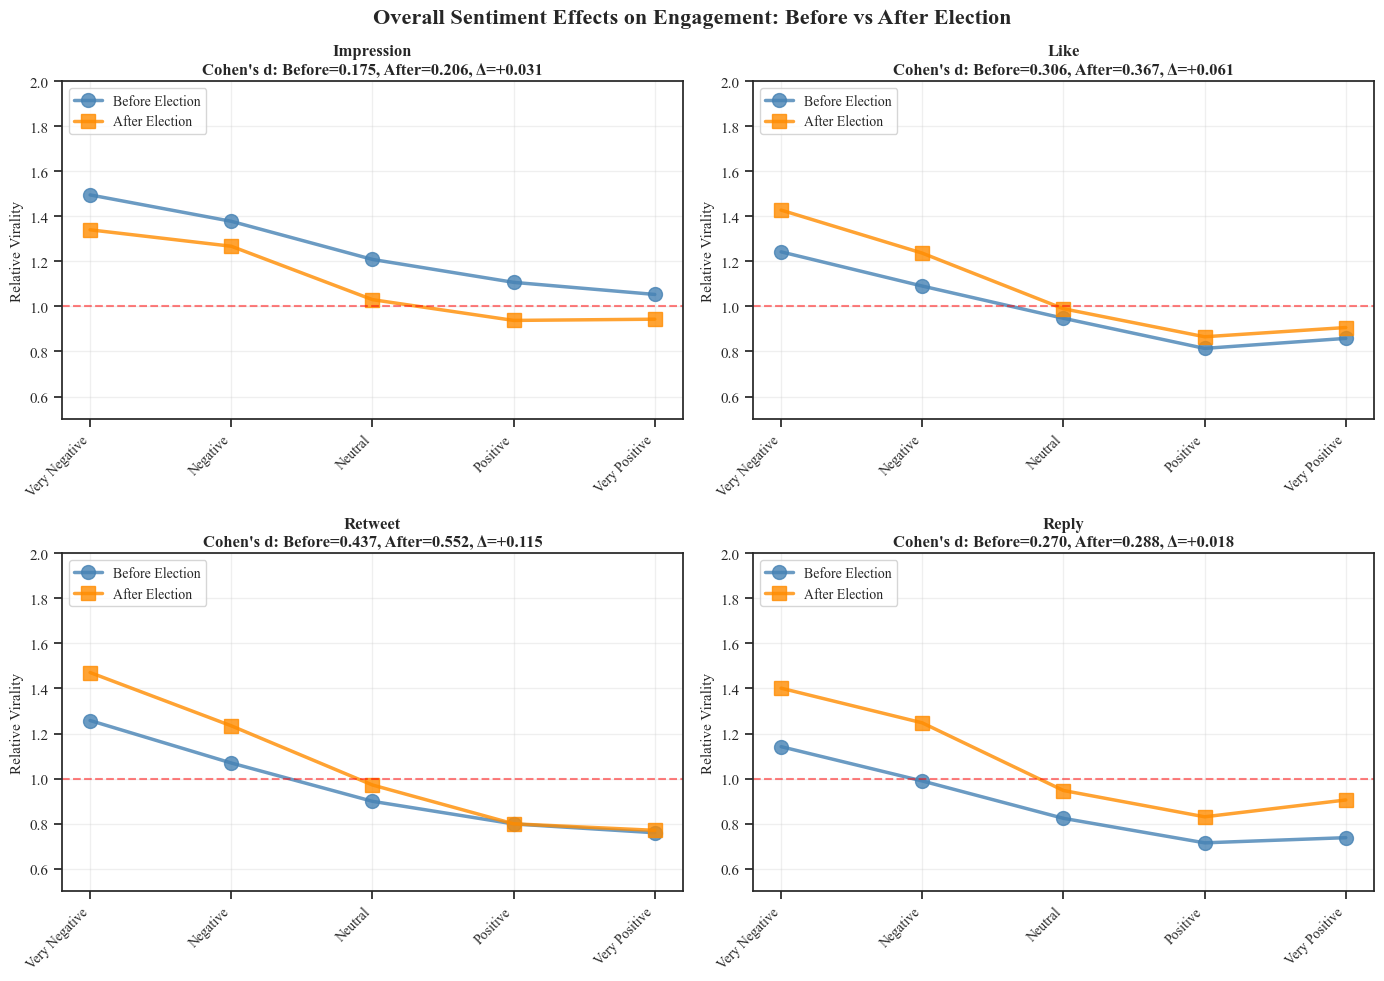


Overall Cohen's d Changes:
----------------------------------------
Impression     : +0.031
Like           : +0.061
Retweet        : +0.115
Reply          : +0.018

STEP 2: PARTY-SPECIFIC SENTIMENT EFFECTS - ALL METRICS

--- Analyzing Impression ---
Party effects plot saved as PNG: '..\sentiment_OutputVisualizations\plots\party_effects_impression_count.png'
Party effects plot saved as PDF: '..\sentiment_OutputVisualizations\plots\party_effects_impression_count.pdf'


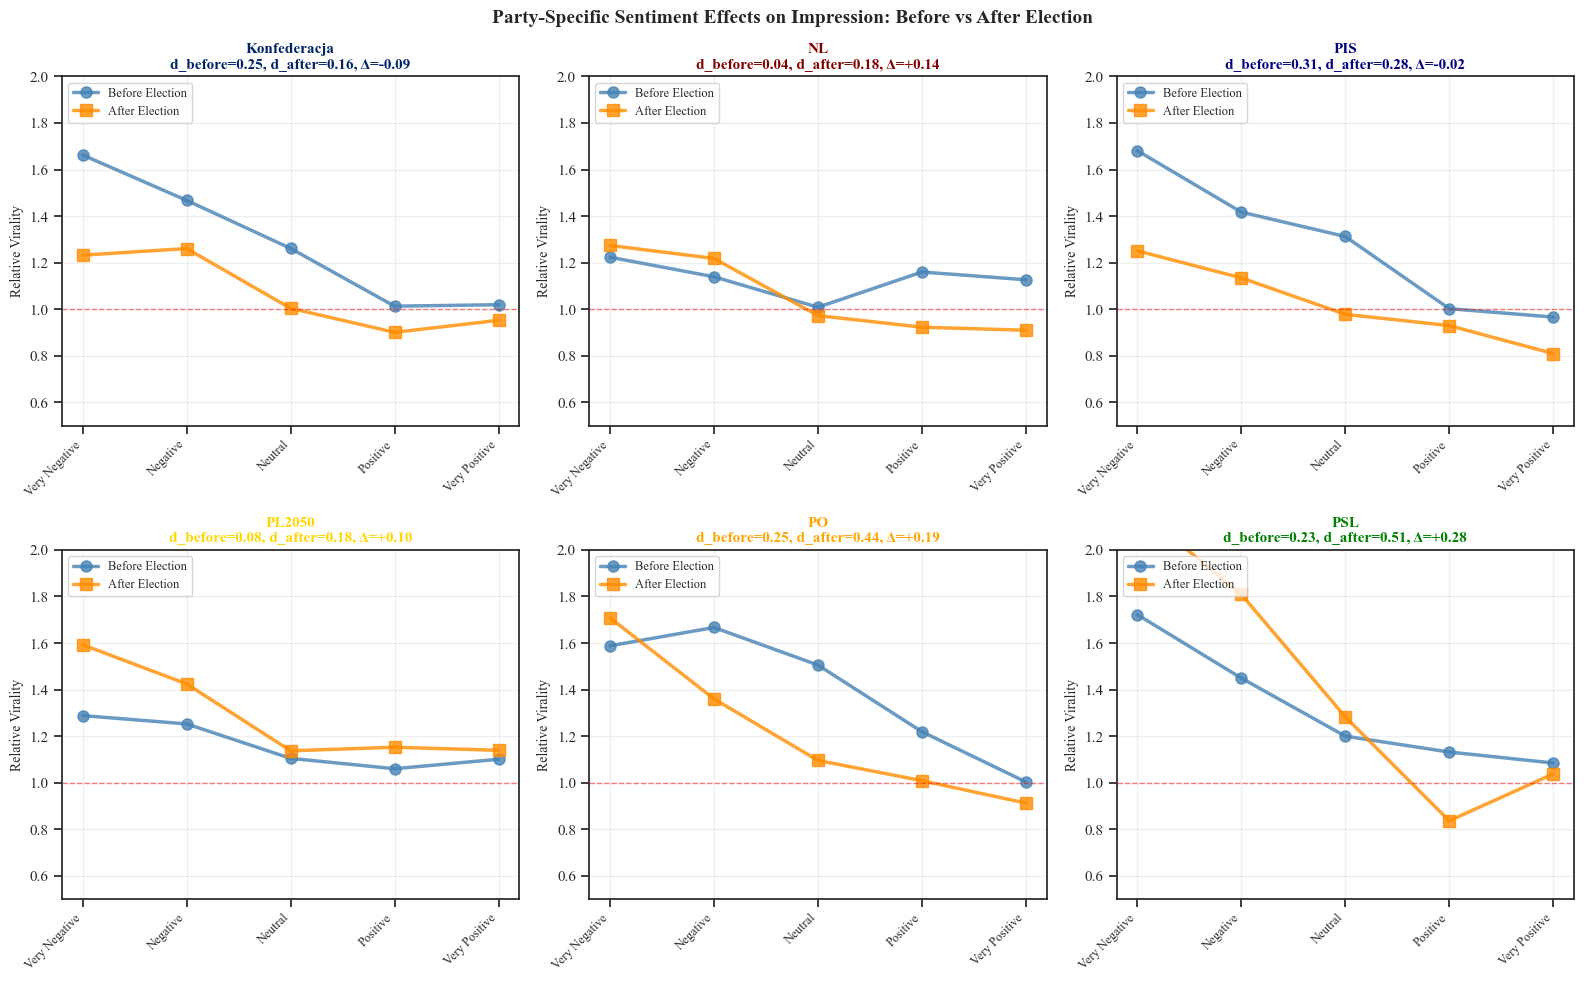


--- Analyzing Like ---
Party effects plot saved as PNG: '..\sentiment_OutputVisualizations\plots\party_effects_like_count.png'
Party effects plot saved as PDF: '..\sentiment_OutputVisualizations\plots\party_effects_like_count.pdf'


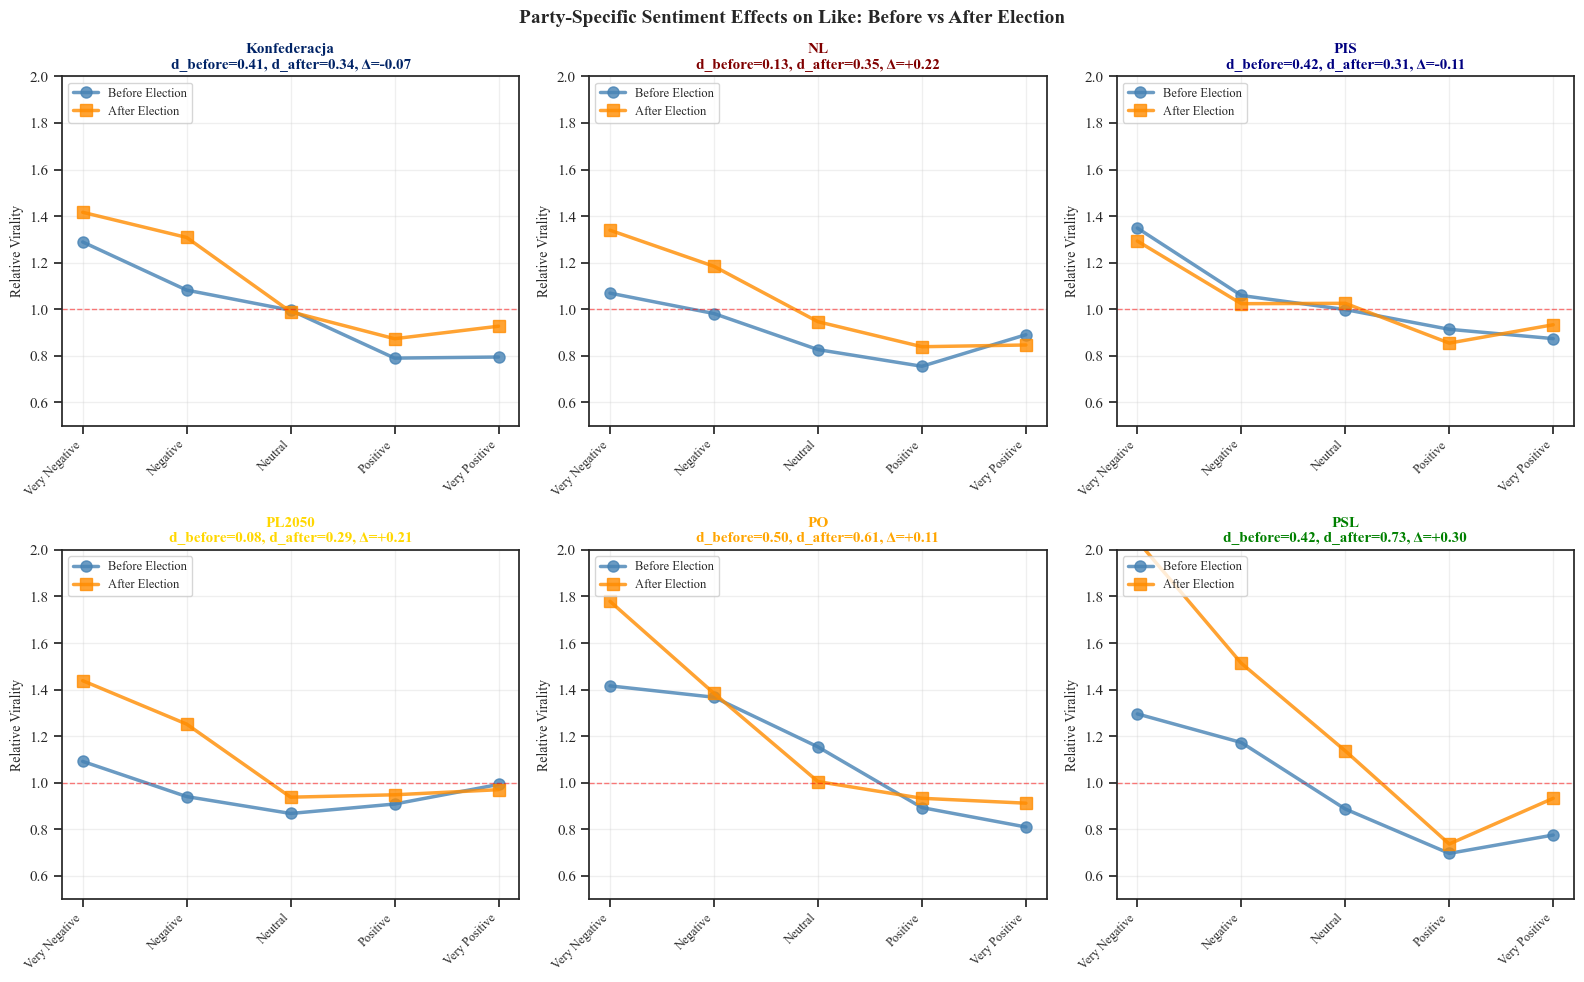


--- Analyzing Retweet ---
Party effects plot saved as PNG: '..\sentiment_OutputVisualizations\plots\party_effects_retweet_count.png'
Party effects plot saved as PDF: '..\sentiment_OutputVisualizations\plots\party_effects_retweet_count.pdf'


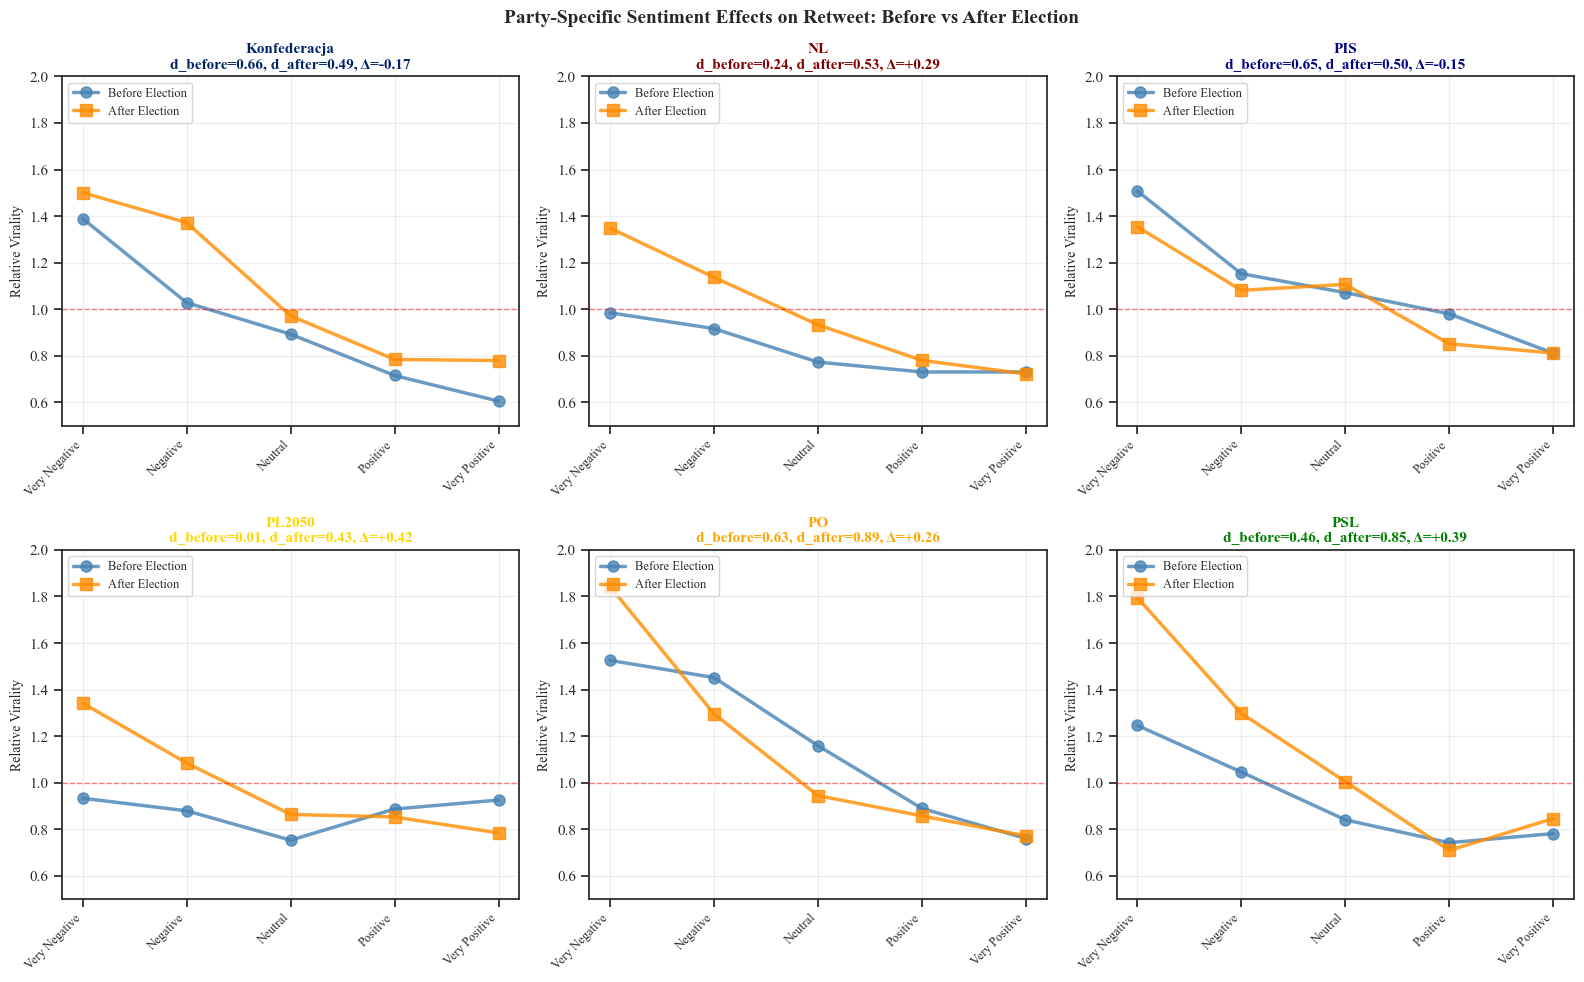


--- Analyzing Reply ---
Party effects plot saved as PNG: '..\sentiment_OutputVisualizations\plots\party_effects_reply_count.png'
Party effects plot saved as PDF: '..\sentiment_OutputVisualizations\plots\party_effects_reply_count.pdf'


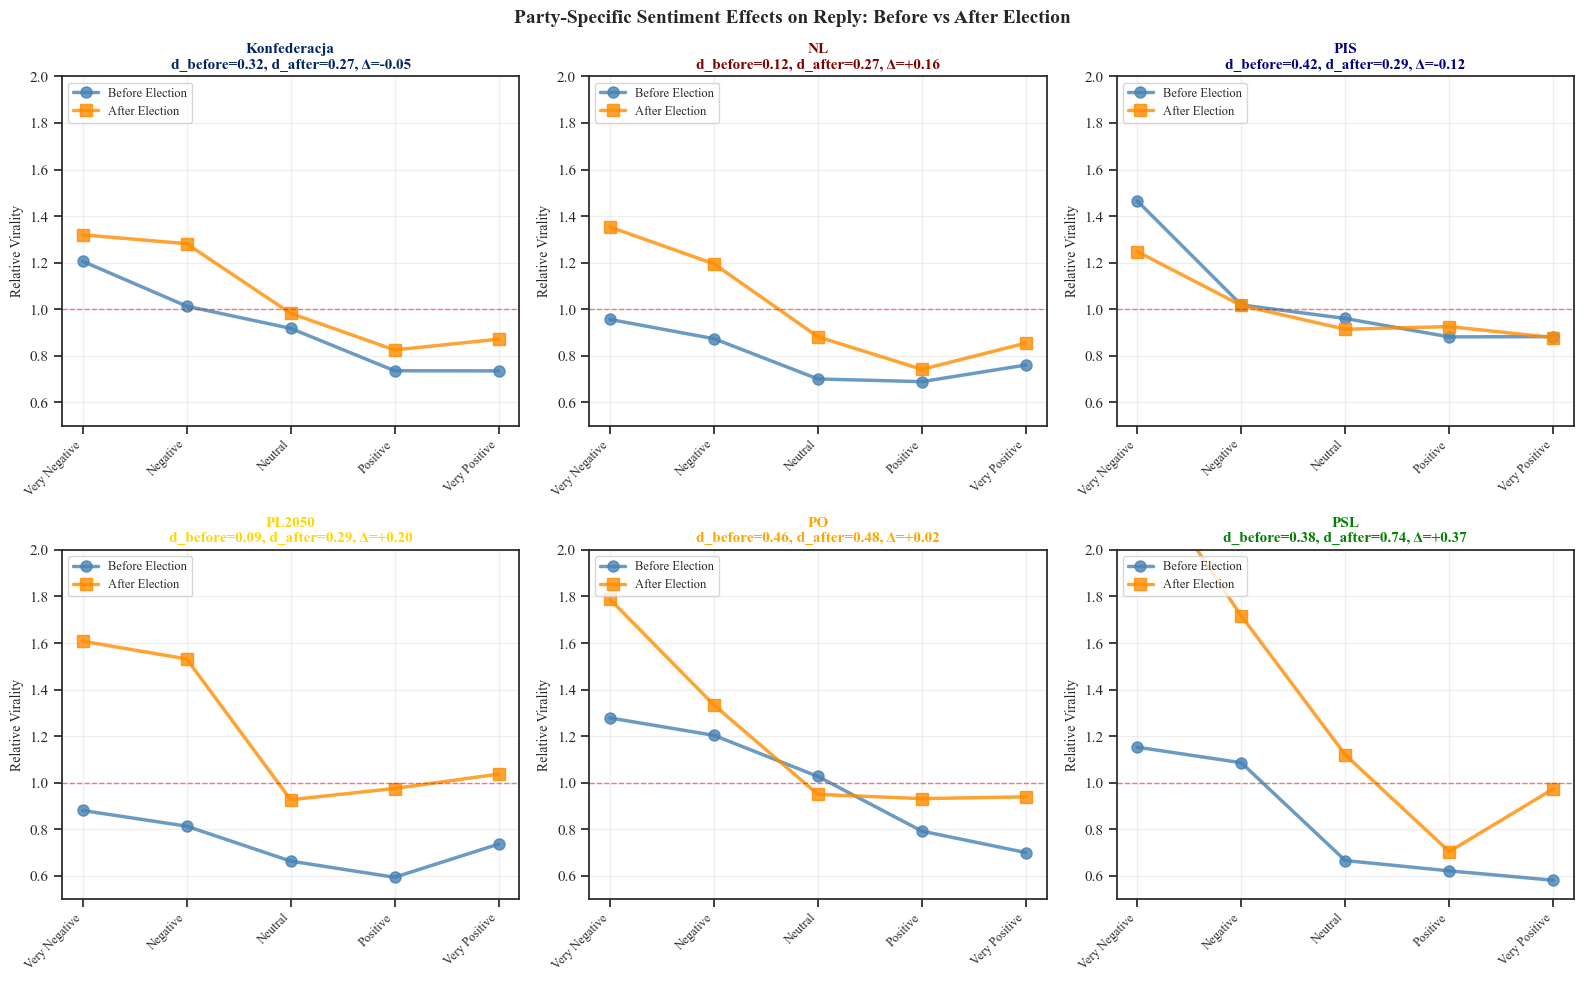


STEP 3: SUMMARY - COHEN'S D CHANGES BY PARTY AND METRIC

Heatmap saved as PNG: '..\sentiment_OutputVisualizations\plots\cohen_d_changes_heatmap.png'
Heatmap saved as PDF: '..\sentiment_OutputVisualizations\plots\cohen_d_changes_heatmap.pdf'


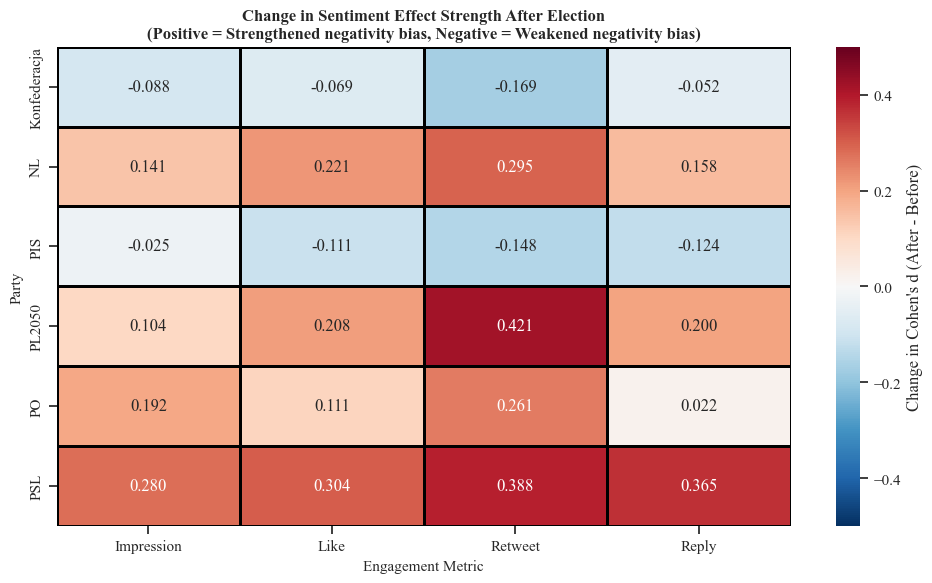


Summary Statistics:
--------------------------------------------------
Party             Avg Change              Pattern
--------------------------------------------------
Konfederacja          -0.094               Stable
NL                    +0.204         Strengthened
PIS                   -0.102             Weakened
PL2050                +0.233         Strengthened
PO                    +0.146         Strengthened
PSL                   +0.334         Strengthened

Cohen's d changes saved to '..\sentiment_OutputVisualizations\plots\cohen_d_changes_by_party_metric.csv'

Analysis complete! All results saved to '..\sentiment_OutputVisualizations\plots/'


In [67]:
"""
BEFORE/AFTER ELECTION SENTIMENT EFFECTS ANALYSIS
Focused on sentiment-engagement relationships
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import timedelta
from IPython.display import display
import warnings
from pathlib import Path
warnings.filterwarnings('ignore')

# --- Create output subfolder ---
plots_dir = Path(output_dir) / 'plots'
plots_dir.mkdir(parents=True, exist_ok=True)

# Check required data
if 'df_for_bert' not in locals() or 'party_colors' not in locals():
    raise NameError("Ensure 'df_for_bert' and 'party_colors' are defined before running this script.")

# Make election date timezone-aware
ELECTION_DATE = pd.to_datetime('2023-10-15', utc=True)

# Split data
df_before = df_for_bert[df_for_bert['created_at'] < ELECTION_DATE].copy()
df_after = df_for_bert[df_for_bert['created_at'] >= ELECTION_DATE].copy()

print("="*90)
print("BEFORE/AFTER ELECTION SENTIMENT EFFECTS ANALYSIS")
print("="*90)
print(f"\nData Split:")
print(f"  Before Election: {len(df_before):,} tweets ({len(df_before)/len(df_for_bert)*100:.1f}%)")
print(f"  After Election: {len(df_after):,} tweets ({len(df_after)/len(df_for_bert)*100:.1f}%)")
print(f"  Date range before: {df_before['created_at'].min().date()} to {df_before['created_at'].max().date()}")
print(f"  Date range after: {df_after['created_at'].min().date()} to {df_after['created_at'].max().date()}")

# Define metrics and sentiment labels
virality_metrics = ['impression_count', 'like_count', 'retweet_count', 'reply_count']
sentiment_labels = ['Very Negative', 'Negative', 'Neutral', 'Positive', 'Very Positive']

# Cohen's d calculation function
def calculate_cohens_d(group1, group2):
    """Calculate Cohen's d effect size"""
    n1, n2 = len(group1), len(group2)
    if n1 < 2 or n2 < 2:
        return np.nan
    var1, var2 = group1.var(), group2.var()
    pooled_std = np.sqrt(((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2))
    return (group1.mean() - group2.mean()) / pooled_std if pooled_std > 0 else 0

# ================================================================================
# STEP 1: OVERALL ANALYSIS (NO PARTY GROUPING)
# ================================================================================

print("\n" + "="*90)
print("STEP 1: OVERALL SENTIMENT EFFECTS - BEFORE vs AFTER ELECTION")
print("="*90)

# Calculate overall sentiment effects
overall_results = {}

for metric in virality_metrics:
    capped_metric = f'relative_{metric}_capped'
    
    if capped_metric in df_before.columns and capped_metric in df_after.columns:
        # Before period
        before_means = df_before.groupby('sentiment_bin_labels')[capped_metric].mean()
        very_neg_before = df_before[df_before['sentiment_bin_labels'] == 'Very Negative'][capped_metric].dropna()
        very_pos_before = df_before[df_before['sentiment_bin_labels'] == 'Very Positive'][capped_metric].dropna()
        cohen_d_before = calculate_cohens_d(very_neg_before, very_pos_before)
        
        # After period
        after_means = df_after.groupby('sentiment_bin_labels')[capped_metric].mean()
        very_neg_after = df_after[df_after['sentiment_bin_labels'] == 'Very Negative'][capped_metric].dropna()
        very_pos_after = df_after[df_after['sentiment_bin_labels'] == 'Very Positive'][capped_metric].dropna()
        cohen_d_after = calculate_cohens_d(very_neg_after, very_pos_after)
        
        overall_results[metric] = {
            'before_means': before_means,
            'after_means': after_means,
            'cohen_d_before': cohen_d_before,
            'cohen_d_after': cohen_d_after,
            'cohen_d_change': cohen_d_after - cohen_d_before if not np.isnan(cohen_d_before) and not np.isnan(cohen_d_after) else np.nan
        }

# Plot overall sentiment effects
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, metric in enumerate(virality_metrics):
    ax = axes[idx]
    
    if metric in overall_results:
        before_means = overall_results[metric]['before_means']
        after_means = overall_results[metric]['after_means']
        
        x_pos = np.arange(len(sentiment_labels))
        
        # Get values for all sentiment categories
        before_values = [before_means.get(label, np.nan) for label in sentiment_labels]
        after_values = [after_means.get(label, np.nan) for label in sentiment_labels]
        
        # Plot
        ax.plot(x_pos, before_values, 'o-', label='Before Election', 
                color='steelblue', linewidth=2.5, markersize=10, alpha=0.8)
        ax.plot(x_pos, after_values, 's-', label='After Election', 
                color='darkorange', linewidth=2.5, markersize=10, alpha=0.8)
        
        # Baseline
        ax.axhline(y=1.0, color='red', linestyle='--', alpha=0.5, linewidth=1.5)
        
        # Title with Cohen's d
        d_before = overall_results[metric]['cohen_d_before']
        d_after = overall_results[metric]['cohen_d_after']
        d_change = overall_results[metric]['cohen_d_change']
        
        ax.set_title(f"{metric.replace('_count', '').title()}\n"
                    f"Cohen's d: Before={d_before:.3f}, After={d_after:.3f}, Δ={d_change:+.3f}", 
                    fontsize=12, fontweight='bold')
        
        ax.set_xticks(x_pos)
        ax.set_xticklabels(sentiment_labels, rotation=45, ha='right', fontsize=10)
        ax.set_ylabel('Relative Virality', fontsize=11)
        ax.legend(loc='upper left', fontsize=10)
        ax.grid(True, alpha=0.3)
        ax.set_ylim([0.5, 2.0])

plt.suptitle('Overall Sentiment Effects on Engagement: Before vs After Election', 
             fontsize=16, fontweight='bold')
plt.tight_layout()

# Save overall sentiment effects plot
overall_png = plots_dir / 'overall_sentiment_effects_comparison.png'
overall_pdf = plots_dir / 'overall_sentiment_effects_comparison.pdf'
plt.savefig(overall_png, dpi=300, bbox_inches='tight')
plt.savefig(overall_pdf, bbox_inches='tight')
print(f"\nOverall sentiment effects plot saved as PNG: '{overall_png}'")
print(f"Overall sentiment effects plot saved as PDF: '{overall_pdf}'")
plt.show()

# Print overall statistics
print("\nOverall Cohen's d Changes:")
print("-" * 40)
for metric in virality_metrics:
    if metric in overall_results:
        change = overall_results[metric]['cohen_d_change']
        print(f"{metric.replace('_count', '').title():15s}: {change:+.3f}")

# ================================================================================
# STEP 2: PARTY-SPECIFIC ANALYSIS FOR ALL METRICS
# ================================================================================

print("\n" + "="*90)
print("STEP 2: PARTY-SPECIFIC SENTIMENT EFFECTS - ALL METRICS")
print("="*90)

# Get parties (exclude Unknown_Party if present)
parties = sorted(df_for_bert['party'].unique())
parties = [p for p in parties if p != 'Unknown_Party'][:6]  # Limit to 6 parties for visualization

# Analyze party-specific effects
def analyze_party_metric(df_period, party, metric):
    """Analyze sentiment effects for a specific party and metric"""
    df_party = df_period[df_period['party'] == party].copy()
    capped_metric = f'relative_{metric}_capped'
    
    if capped_metric in df_party.columns:
        sentiment_means = df_party.groupby('sentiment_bin_labels')[capped_metric].mean()
        very_neg = df_party[df_party['sentiment_bin_labels'] == 'Very Negative'][capped_metric].dropna()
        very_pos = df_party[df_party['sentiment_bin_labels'] == 'Very Positive'][capped_metric].dropna()
        cohen_d = calculate_cohens_d(very_neg, very_pos)
        
        return {
            'means': sentiment_means,
            'cohen_d': cohen_d,
            'n_tweets': len(df_party)
        }
    return None

# Create plots for each metric
for metric in virality_metrics:
    print(f"\n--- Analyzing {metric.replace('_count', '').title()} ---")
    
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    axes = axes.flatten()
    
    for idx, party in enumerate(parties):
        ax = axes[idx]
        
        # Analyze before and after
        before_analysis = analyze_party_metric(df_before, party, metric)
        after_analysis = analyze_party_metric(df_after, party, metric)
        
        if before_analysis and after_analysis:
            before_means = before_analysis['means']
            after_means = after_analysis['means']
            
            x_pos = np.arange(len(sentiment_labels))
            
            # Get values
            before_values = [before_means.get(label, np.nan) for label in sentiment_labels]
            after_values = [after_means.get(label, np.nan) for label in sentiment_labels]
            
            # Plot
            ax.plot(x_pos, before_values, 'o-', label='Before Election', 
                    color='steelblue', linewidth=2.5, markersize=8, alpha=0.8)
            ax.plot(x_pos, after_values, 's-', label='After Election', 
                    color='darkorange', linewidth=2.5, markersize=8, alpha=0.8)
            
            # Baseline
            ax.axhline(y=1.0, color='red', linestyle='--', alpha=0.5, linewidth=1)
            
            # Title with Cohen's d
            d_before = before_analysis['cohen_d']
            d_after = after_analysis['cohen_d']
            d_change = d_after - d_before if not np.isnan(d_before) and not np.isnan(d_after) else np.nan
            
            party_color = party_colors.get(party, 'black')
            ax.set_title(f'{party}\n'
                        f'd_before={d_before:.2f}, d_after={d_after:.2f}, Δ={d_change:+.2f}', 
                        fontsize=11, fontweight='bold', color=party_color)
            
            ax.set_xticks(x_pos)
            ax.set_xticklabels(sentiment_labels, rotation=45, ha='right', fontsize=9)
            ax.set_ylabel('Relative Virality', fontsize=10)
            ax.legend(loc='upper left', fontsize=9)
            ax.grid(True, alpha=0.3)
            ax.set_ylim([0.5, 2.0])
    
    # Remove unused subplots
    for idx in range(len(parties), 6):
        fig.delaxes(axes[idx])
    
    plt.suptitle(f'Party-Specific Sentiment Effects on {metric.replace("_count", "").title()}: Before vs After Election', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    # Save party-specific plots
    party_png = plots_dir / f'party_effects_{metric}.png'
    party_pdf = plots_dir / f'party_effects_{metric}.pdf'
    plt.savefig(party_png, dpi=300, bbox_inches='tight')
    plt.savefig(party_pdf, bbox_inches='tight')
    print(f"Party effects plot saved as PNG: '{party_png}'")
    print(f"Party effects plot saved as PDF: '{party_pdf}'")
    plt.show()

# ================================================================================
# STEP 3: SUMMARY HEATMAP - COHEN'S D CHANGES
# ================================================================================

print("\n" + "="*90)
print("STEP 3: SUMMARY - COHEN'S D CHANGES BY PARTY AND METRIC")
print("="*90)

# Calculate all Cohen's d changes
cohen_d_matrix = []

for party in parties:
    party_row = {'Party': party}
    
    for metric in virality_metrics:
        before_analysis = analyze_party_metric(df_before, party, metric)
        after_analysis = analyze_party_metric(df_after, party, metric)
        
        if before_analysis and after_analysis:
            d_before = before_analysis['cohen_d']
            d_after = after_analysis['cohen_d']
            change = d_after - d_before if not np.isnan(d_before) and not np.isnan(d_after) else np.nan
        else:
            change = np.nan
        
        party_row[metric.replace('_count', '').title()] = change
    
    cohen_d_matrix.append(party_row)

# Create DataFrame and heatmap
cohen_df = pd.DataFrame(cohen_d_matrix).set_index('Party')

plt.figure(figsize=(10, 6))
sns.heatmap(cohen_df, annot=True, fmt='.3f', cmap='RdBu_r', center=0,
            cbar_kws={'label': 'Change in Cohen\'s d (After - Before)'},
            vmin=-0.5, vmax=0.5, linewidths=1, linecolor='black')
plt.title('Change in Sentiment Effect Strength After Election\n(Positive = Strengthened negativity bias, Negative = Weakened negativity bias)',
          fontsize=12, fontweight='bold')
plt.xlabel('Engagement Metric', fontsize=11)
plt.ylabel('Party', fontsize=11)
plt.tight_layout()

# Save heatmap
heatmap_png = plots_dir / 'cohen_d_changes_heatmap.png'
heatmap_pdf = plots_dir / 'cohen_d_changes_heatmap.pdf'
plt.savefig(heatmap_png, dpi=300, bbox_inches='tight')
plt.savefig(heatmap_pdf, bbox_inches='tight')
print(f"\nHeatmap saved as PNG: '{heatmap_png}'")
print(f"Heatmap saved as PDF: '{heatmap_pdf}'")
plt.show()

# Print summary statistics
print("\nSummary Statistics:")
print("-" * 50)
print(f"{'Party':<15} {'Avg Change':>12} {'Pattern':>20}")
print("-" * 50)

for party in parties:
    changes = cohen_df.loc[party].dropna().values
    if len(changes) > 0:
        avg_change = np.mean(changes)
        if avg_change > 0.1:
            pattern = "Strengthened"
        elif avg_change < -0.1:
            pattern = "Weakened"
        else:
            pattern = "Stable"
        print(f"{party:<15} {avg_change:>+12.3f} {pattern:>20}")

# Save results to CSV
cohen_csv = plots_dir / 'cohen_d_changes_by_party_metric.csv'
cohen_df.to_csv(cohen_csv)
print(f"\nCohen's d changes saved to '{cohen_csv}'")

print("\n" + "="*90)
print(f"Analysis complete! All results saved to '{plots_dir}/'")
print("="*90)

## 5. Conclusions

FIX

## 6. Refrences

[1] Hutto, C., & Gilbert, E. (2014). VADER: A Parsimonious Rule-Based Model for Sentiment Analysis of Social Media Text. Proceedings of the International AAAI Conference on Web and Social Media, 8(1), 216–225. https://doi.org/10.1609/icwsm.v8i1.14550

[2] Yinhan Liu, Myle Ott, Naman Goyal, Jingfei Du, Mandar Joshi, Danqi Chen, Omer Levy, Mike Lewis, Luke Zettlemoyer, and Veselin Stoyanov. 2019. Roberta: A robustly optimized bert pretraining approach. arXiv preprint arXiv:190711692.
